In [ ]:
!pip install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successful

# Install and Import Necessary Libraries

In [ ]:
!pip install seaborn
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 100.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import joblib
import mne

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from scipy.stats import pearsonr
from scipy.fft import fft
from tabulate import tabulate

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import ELU, ReLU

from tensorflow import keras
print(tf.version.VERSION)

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.17.0
Mounted at /content/drive


In [ ]:
def set_seed(seed: int = 42) -> None:

  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

set_seed(42) #attach weights and biases citation

#https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy

Random seed set as 42


# Directories (Local and Google Drive)

In [ ]:
#local Drive

#seg_dir = r'C://Users//123100025//Downloads//h_seg_data' #segmented EEG files
#seg_label_dir = r'C://Users//123100025//Downloads//h_seg_data/segment_labels' #EEG labels

#google drive
seg_dir = '/content/drive/MyDrive/h_seg_data' #segmented EEG files
seg_label_dir = '/content/drive/MyDrive/h_seg_data/segment_labels' #EEG labels

# Load The Data

In [ ]:
#initialize lists to store the loaded files
eeg_segments = []
eeg_labels = []

#check if the segment directory exists
if os.path.exists(seg_dir):

    #list the files/folders within the directory
    files = os.listdir(seg_dir)
    print(f"The folder consists of the following files:\n{files}")

    #for each patient ID from 1 to 79
    for p_id in range(1, 80):

        #define the paths for patient wise EEG segments and labels
        segment_fpath = os.path.join(seg_dir, f'eeg{p_id}_segments.npy')
        label_fpath = os.path.join(seg_label_dir, f'eeg{p_id}_labels.npy')

        #check if the segment and label files for that patient ID exist in their respective paths
        if os.path.exists(segment_fpath) and os.path.exists(label_fpath):

            #load the segments and labels
            segment = np.load(segment_fpath)
            label = np.load(label_fpath)

            #add it to their corresponding lists
            eeg_segments.append(segment)
            eeg_labels.append(label)

        #if the file for that patient ID doesn't exist
        else:

            print(f"Patient file {p_id} missing.")

    #stack the 3D arrays vertically
    eeg_segments = np.vstack(eeg_segments)
    #combine all the labels one after another
    eeg_labels = np.concatenate(eeg_labels, axis = 0)

    #transpose the array to the shape [samples, time steps, channels]
    eeg_Tsegments = np.transpose(eeg_segments, (0, 2, 1))

    print(f'Original EEG Segments shape: {eeg_segments.shape}')
    print(f'Transposed EEG Segments shape: {eeg_Tsegments.shape}')

else:

    print("Directory doesn't exist.")

The folder consists of the following files:
['eeg2_segments.npy', 'eeg1_segments.npy', 'eeg4_segments.npy', 'eeg3_segments.npy', 'eeg5_segments.npy', 'eeg6_segments.npy', 'eeg7_segments.npy', 'eeg8_segments.npy', 'eeg9_segments.npy', 'eeg10_segments.npy', 'eeg11_segments.npy', 'eeg12_segments.npy', 'eeg13_segments.npy', 'eeg14_segments.npy', 'eeg15_segments.npy', 'eeg16_segments.npy', 'eeg18_segments.npy', 'eeg17_segments.npy', 'eeg20_segments.npy', 'eeg19_segments.npy', 'eeg21_segments.npy', 'eeg23_segments.npy', 'eeg22_segments.npy', 'eeg24_segments.npy', 'eeg26_segments.npy', 'eeg25_segments.npy', 'eeg27_segments.npy', 'eeg28_segments.npy', 'eeg29_segments.npy', 'eeg30_segments.npy', 'eeg31_segments.npy', 'eeg33_segments.npy', 'eeg32_segments.npy', 'eeg34_segments.npy', 'eeg36_segments.npy', 'eeg35_segments.npy', 'eeg37_segments.npy', 'eeg38_segments.npy', 'eeg39_segments.npy', 'eeg40_segments.npy', 'eeg41_segments.npy', 'eeg42_segments.npy', 'eeg43_segments.npy', 'eeg44_segments.np

# Split The Data


In [ ]:
#split data into training (80%) and test (20%) sets
train_seg, test_seg, train_labels, test_labels = train_test_split(eeg_Tsegments,
                                                                  eeg_labels,
                                                                  test_size=0.2,
                                                                  random_state=42,
                                                                  stratify=eeg_labels)

#split the training data into 70% train and 10% validation
x_train, val_seg, y_train, val_labels = train_test_split(train_seg,
                                                         train_labels,
                                                         test_size=0.125,
                                                         random_state=42,
                                                         stratify=train_labels)

#split the remaining training set into 20% labelled set (x_train_lseg) and 50% unlabelled set
#(assume for pseudo labelling process) (x_train_unseg)
x_train_lseg, x_train_unseg, y_train_labels, y_train_unlabels = train_test_split(x_train,
                                                                                 y_train,
                                                                                 test_size=0.715,
                                                                                 random_state=42,
                                                                                 stratify=y_train)

print(f'\nEntire data shape: {eeg_Tsegments.shape}') #100% data
print(f'\nEntire Labels Shape: {eeg_labels.shape}')

print(f'Training Data Shape: {x_train.shape}') #80% train
print(f'Training Labels Shape: {y_train.shape}')

print(f"Test data shape: {test_seg.shape}") #20% test
print(f"Test labels shape: {test_labels.shape}")

print(f'Validation Data Shape: {val_seg.shape}') #10% validation during training
print(f'Validation Labels Shape: {val_labels.shape}')

print(f"\nLabelled training data shape: {x_train_lseg.shape}") #20% labelled training set
print(f"\nLabelled training labels shape: {y_train_labels.shape}")

print(f"Unlabelled training data shape: {x_train_unseg.shape}") #50% unlabelled training set
print(f"Unlabelled training labels shape: {y_train_unlabels.shape}")


Entire data shape: (100441, 1024, 18)

Entire Labels Shape: (100441,)
Training Data Shape: (70308, 1024, 18)
Training Labels Shape: (70308,)
Test data shape: (20089, 1024, 18)
Test labels shape: (20089,)
Validation Data Shape: (10044, 1024, 18)
Validation Labels Shape: (10044,)

Labelled training data shape: (20037, 1024, 18)

Labelled training labels shape: (20037,)
Unlabelled training data shape: (50271, 1024, 18)
Unlabelled training labels shape: (50271,)


Class Distribution of the Entire Dataset: Counter({0: 87650, 1: 12791})
Total Number of Data Samples = 100441
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


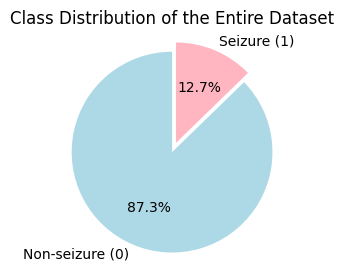

Class Distribution of the Labelled Training Dataset: Counter({0: 17485, 1: 2552})
Total Number of Data Samples = 20037
Non-seizure class distribution =  87.26%
Seizure class distribution = 12.74%


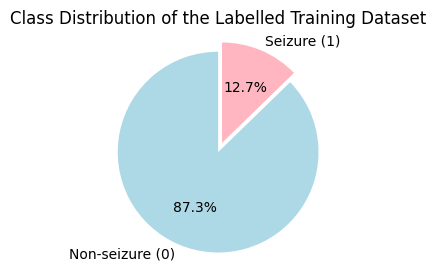

Class Distribution of the Unlabelled Training Dataset: Counter({0: 43869, 1: 6402})
Total Number of Data Samples = 50271
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


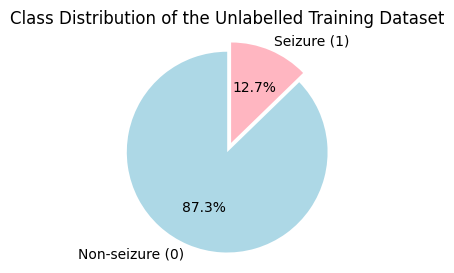

Class Distribution of the Validation Dataset: Counter({0: 8765, 1: 1279})
Total Number of Data Samples = 10044
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


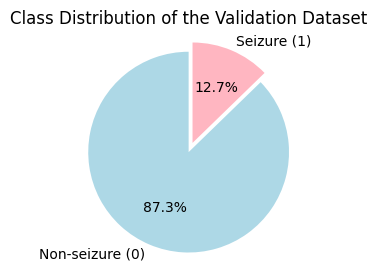

Class Distribution of the Test Dataset: Counter({0: 17531, 1: 2558})
Total Number of Data Samples = 20089
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


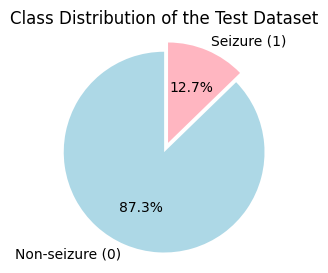

In [ ]:
#function to calculate the class imbalances across the datasets
def data_balance(dataset, name):

    #count the occurences of each class
    samples_counter = Counter(dataset)
    print(f'Class Distribution of the {name}: {samples_counter}')

    #calculate the distribution
    total_samples = len(dataset)
    class_0 = (samples_counter[0] / total_samples) * 100 #nonseizure
    class_1 = (samples_counter[1] / total_samples) * 100 #seizure

    print(f'Total Number of Data Samples = {total_samples}')
    print(f'Non-seizure class distribution =  {class_0:.2f}%')
    print(f'Seizure class distribution = {class_1:.2f}%')

    #plot the distribution
    labels = ['Non-seizure (0)', 'Seizure (1)']
    sizes = [class_0, class_1]
    colors = ['lightblue', 'lightpink']
    explode = (0, 0.1)

    plt.figure(figsize=(3,3))

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal') #circle
    plt.title(f'Class Distribution of the {name}')
    plt.show()

data_balance(eeg_labels, "Entire Dataset")
data_balance(y_train_labels, "Labelled Training Dataset")
data_balance(y_train_unlabels, "Unlabelled Training Dataset")
data_balance(val_labels, "Validation Dataset")
data_balance(test_labels, "Test Dataset")

# Base Model and Ideal Model

## Build The Model

In [ ]:
#define the 1D CNN model
def CNN_1D(input_shape):

    model = Sequential()

    #layer 1
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=input_shape))

    #layer2
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

    #layer3
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    #layer4
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    #layer5
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    model.add(GlobalMaxPooling1D())

    model.add(Flatten())

    #dense layer1
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    #dense layer2
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    #output dense layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = (x_train_lseg.shape[1], x_train_lseg.shape[2])
model = CNN_1D(input_shape)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1022, 32)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1020, 32)            │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1018, 32)            │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1018, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1016, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1016, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 1014, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1014, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,793 (116.38 KB)

 Trainable params: 29,473 (115.13 KB)

 Non-trainable params: 320 (1.25 KB)

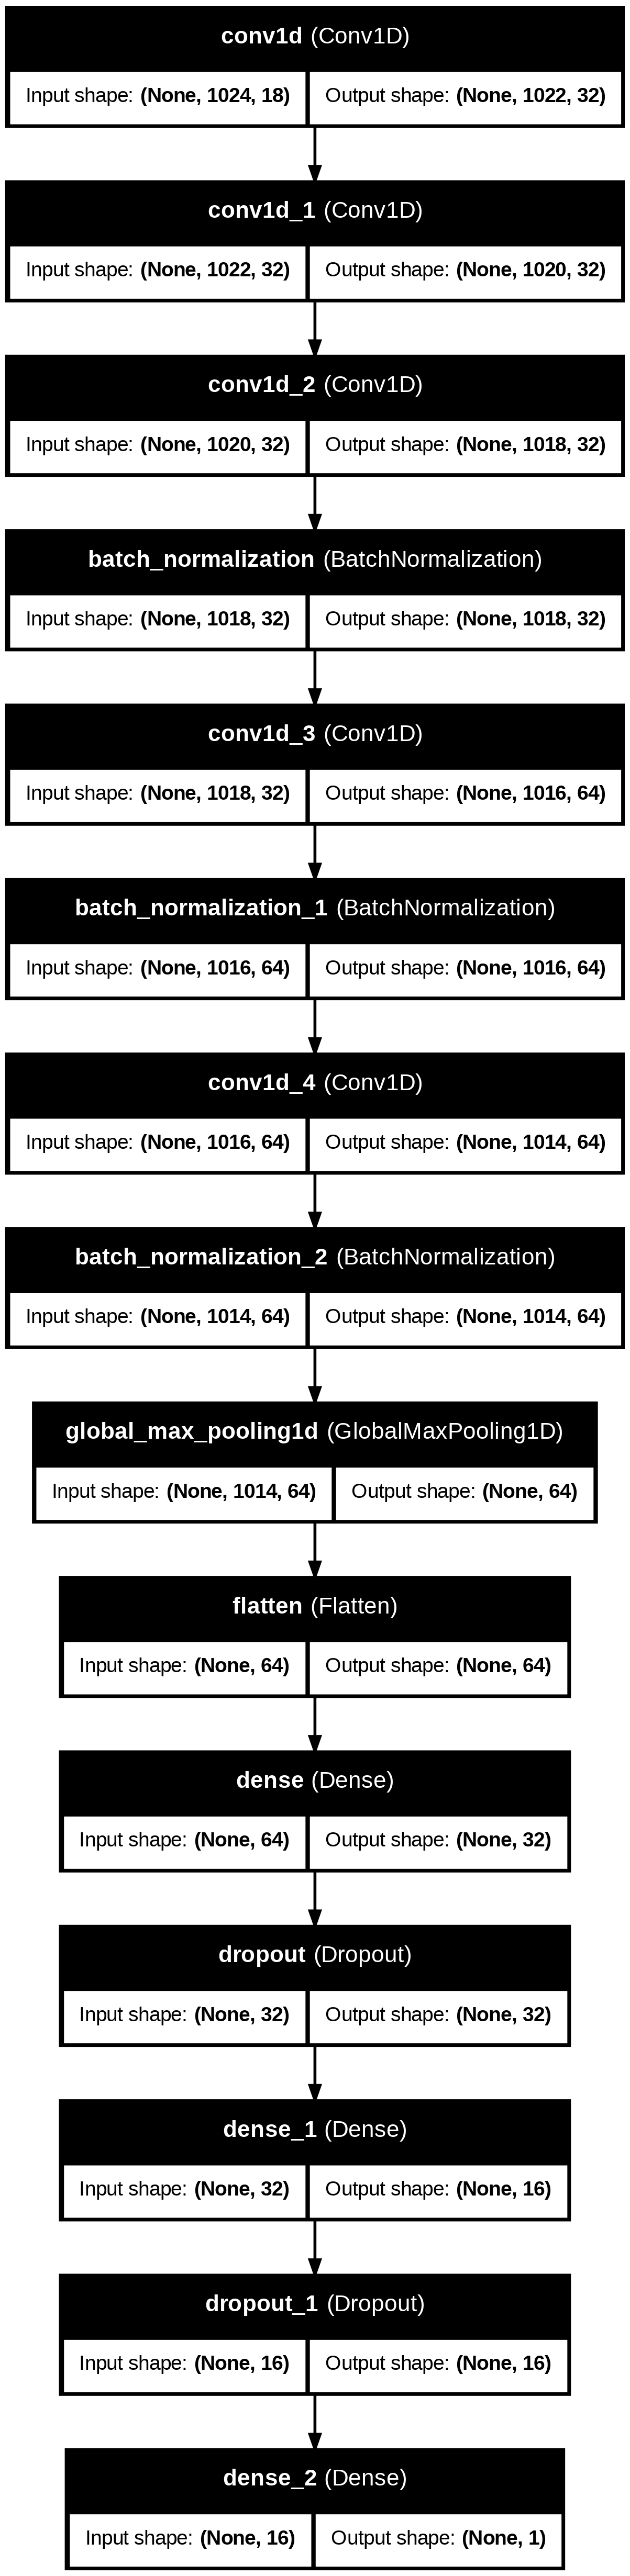

In [ ]:
from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

## Load and Evaluate The Base Model

628/628 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8895 - loss: 0.2637
Test Loss: 0.2545, Test Accuracy: 0.8929
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Pearson Correlation Coefficient: 0.6845
Matthews Correlation Coefficient : 0.6181
AUC-ROC: 0.9354


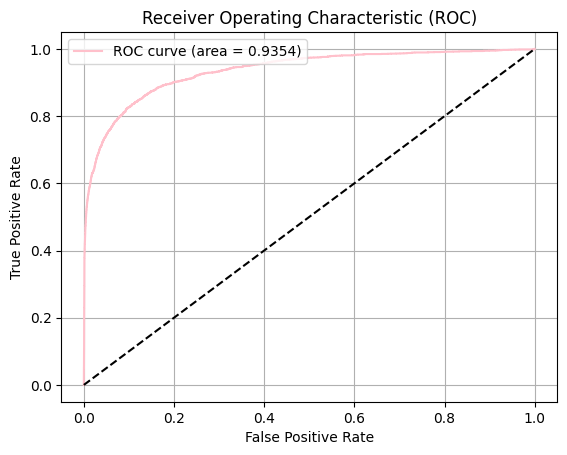

In [ ]:
#load the base model
base_model = tf.keras.models.load_model('base_model.h5')

#evaluate the model
test_loss, test_acc = base_model.evaluate(test_seg, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#predictions and probabilities
test_probs = base_model.predict(test_seg).ravel()
test_preds = (test_probs > 0.5).astype(int)

#Pearson correlation coefficient
pcc = pearsonr(test_probs, test_labels)[0]
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

#Matthews correlation coefficient
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"Matthews Correlation Coefficient : {mcc:.4f}")

#AUC-ROC
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)

#plot ROC Curve
plt.figure()
plt.plot(fpr, tpr,  color='pink', label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Load and Evaluate The Ideal Model

628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9439 - loss: 0.1573
Test Loss: 0.1505, Test Accuracy: 0.9449%
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Pearson Correlation Coefficient: 0.8049
Matthews Correlation Coefficient : 0.7555
AUC-ROC: 0.9693


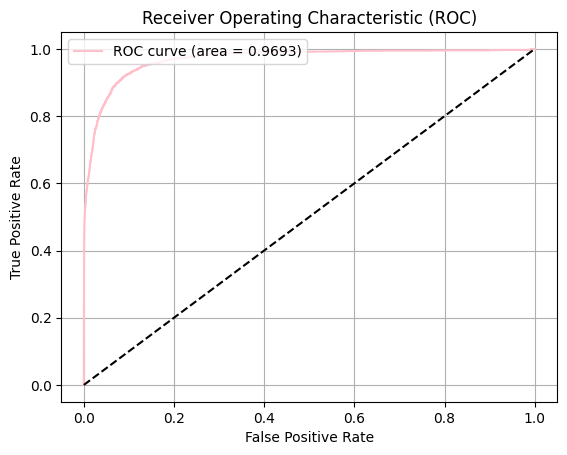

In [ ]:
#load the base model
ideal_model = tf.keras.models.load_model('ideal_model.h5')

# Evaluate the model
test_loss, test_acc = ideal_model.evaluate(test_seg, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}%")

#predictions and probabilities
test_probs = ideal_model.predict(test_seg).ravel()
test_preds = (test_probs > 0.5).astype(int)

#Pearson correlation coefficient
pcc = pearsonr(test_probs, test_labels)[0]
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

#Matthews correlation coefficient
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"Matthews Correlation Coefficient : {mcc:.4f}")

#AUC-ROC
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)

#plot ROC Curve
plt.figure()
plt.plot(fpr, tpr,  color='pink', label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Experiments Dictionary

In [ ]:
experiments = {

#conf threshold no reclassification

    #exp 1 - Taking all the labels above the defined confidence threshold, no reclassification
    'exp_1': {'conf_thresh': 0.99,
              'add_both': True,
              'equal': False,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': False,
              'fixed_percentage': None},

    #exp 2 - Taking all the seizure labels above the defined threshold and an equal number of confident nonseizure labels, no reclassification
    'exp_2': {'conf_thresh': 0.99,
              'add_both': True,
              'equal': True,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': False,
              'fixed_percentage': None},

    #exp 3 - Taking all the seizure labels above the defined threshold only, no reclassification
    'exp_3': {'conf_thresh': 0.99,
              'add_both': False,
              'equal': False,
              'seizure_only': True,
              'nonseizure_only': False,
              'reclassify': False,
              'fixed_percentage': None},

    #exp 4 - Taking all the nonseizure labels below the defined threshold only, no reclassification
    'exp_4': {'conf_thresh': 0.01,
              'add_both': False,
              'equal': False,
              'seizure_only': False,
              'nonseizure_only': True,
              'reclassify': False,
              'fixed_percentage': None},

#conf threshold, with reclassification

    #exp 5 - Taking all the labels above the defined confidence threshold, with reclassification
    'exp_5': {'conf_thresh': 0.99,
              'add_both': True,
              'equal': False,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': True,
              'fixed_percentage': None},

    #exp 6 - Taking all the seizure labels above the defined threshold and an equal number of confident nonseizure labels, with reclassification
    'exp_6': {'conf_thresh': 0.99,
              'add_both': True,
              'equal': True,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': True,
              'fixed_percentage': None},

    #exp 7 - Taking all the seizure labels above the defined threshold only, with reclassification
    'exp_7': {'conf_thresh': 0.99,
              'add_both': False,
              'equal': False,
              'seizure_only': True,
              'nonseizure_only': False,
              'reclassify': True,
              'fixed_percentage': None},

    #exp 8 - Taking all the nonseizure labels below the defined threshold only, with reclassification
    'exp_8': {'conf_thresh': 0.01,
              'add_both': False,
              'equal': False,
              'seizure_only': False,
              'nonseizure_only': True,
              'reclassify': True,
              'fixed_percentage': None},

#fixed percentage, with reclassification

    #exp 9 - Taking an equal fixed percentage of confident seizure and nonseizure labels, with reclassification
    'exp_9': {'conf_thresh': None,
              'add_both': True,
              'equal': True,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': True,
              'fixed_percentage': 0.001},

    #exp 10 - Taking a fixed percentage of confident seizure labels only, with reclassification
    'exp_10': {'conf_thresh': None,
               'add_both': False,
               'equal': False,
               'seizure_only': True,
               'nonseizure_only': False,
               'reclassify': True,
               'fixed_percentage': 0.002},

    #exp 11 - Taking a fixed percentage of confident nonseizure labels only, with reclassification
    'exp_11': {'conf_thresh': None,
               'add_both': False,
               'equal': False,
               'seizure_only': False,
               'nonseizure_only': True,
               'reclassify': True,
               'fixed_percentage': 0.002}
}

In [ ]:
#track the performance metrics

metrics_history = {'Iteration': [],
                   'Number of Confident Indices Added': [],
                    'Train Accuracy': [],
                    'Train Loss': [],
                    'Validation Accuracy': [],
                    'Validation Loss': [],
                    'Validation PCC': [],
                    'Validation MCC': [],
                    'Validation AUC': [],
                    'Test Accuracy': [],
                    'Test Loss': [],
                    'Test PCC': [],
                    'Test MCC': [],
                    'Test AUC': []
}

#track the segment indices = with their predicted pseudo labels
pseudo_labelled_segments = {
    'Indices': [],
    'Predicted Labels': [],
    'Confidence Values': []
}

correct_seizures = []
correct_nonseizures = []

#initialize the variables
i = 0
prev_mcc = 0
best_mcc = 0
#mcc_drop_count = 0
#max_mcc_drops = 3

#store augmented models based on the iteration round
augmented_model_v = {}
best_augmented_model = None

#original training model, labelled and unlabelled training set
iter_base_model = base_model
iter_unlabelled_segments = x_train_unseg

#number of iterations
num_iterations = 10

#store AUC-ROC data
val_roc_curves = {
    'fpr': [],
    'tpr': [],
    'val_auc': []
}

test_roc_curves = {
    'fpr': [],
    'tpr': [],
    'test_auc': []
}

# Functions

In [ ]:
#function to select confident pseudo labels based on the mode of the experiment

def pseudo_labeling(i,iter_base_model, unlabelled_data,
                    conf_thresh=None, fixed_percentage=None,
                    add_both=False, equal= False,
                    seizure_only=False, nonseizure_only=False):

    conf_indices = []
    conf_segments = []
    conf_labels = []
    conf_values = []

    #model predictions on the unlabelled data
    predictions = iter_base_model.predict(unlabelled_data).ravel()
    predicted_labels = (predictions > 0.5).astype(int)

    if conf_thresh is not None:

        if add_both == True:

            if equal == False: #for exp1 and exp5

                #select the most confident indices
                conf_indices = np.where((predictions > conf_thresh) | (predictions < (1 - conf_thresh)))[0] #conf_thresh = 0.99

            if equal == True: #for exp2, exp6

                #select the most confident seizure indices
                conf_seizure_indices = np.where((predictions > conf_thresh))[0] #conf_thresh = 0.99

                #count the number of conf seizure indices
                count_seizure_indices = len(conf_seizure_indices)

                #select an equal number of confident nonseizure indices
                conf_nonseizure_indices = np.where(predictions < (1 - conf_thresh))[0] #conf_thresh = 0.99
                conf_nonseizure_indices = conf_nonseizure_indices[:count_seizure_indices]

                #combine the indices
                conf_indices = np.concatenate((conf_seizure_indices, conf_nonseizure_indices))

        elif seizure_only == True: #for exp3, exp7

            #select the most confident seizure indices
            conf_indices = np.where((predictions > conf_thresh))[0] #conf_thresh = 0.99

        elif nonseizure_only == True: #for exp4, exp8

            #select the most confident non-seizure indices
            conf_indices = np.where((predictions < conf_thresh))[0] #conf_thresh = 0.01

    elif fixed_percentage is not None:

        #cumulative fixed percentage calculation
        cumulative_percentage = fixed_percentage * i

        if add_both == True and equal == True: #for exp9

            #calculate the number of seizure and non-seizure indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #sort the probability indices

            #select the most confident seizure indices
            seizure_indices = np.argsort(-predictions) #descending order
            seizure_indices = seizure_indices[:num_indices]

            #select the most confident non-seizure indices
            nonseizure_indices = np.argsort(predictions) #ascending order
            nonseizure_indices = nonseizure_indices[:num_indices]

            #combine the indices
            conf_indices = np.concatenate((seizure_indices, nonseizure_indices))

        if add_both == True and equal == False:  # for exp12

            #calculate the total number of indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #calculate the number of seizure and non-seizure indices
            num_seizure_indices = int(num_indices * 0.13)  #13% for seizures
            num_nonseizure_indices = num_indices - num_seizure_indices  #remaining 87% for non-seizures

            #select the most confident seizure indices
            seizure_indices = np.argsort(-predictions)  #descending order
            seizure_indices = seizure_indices[:num_seizure_indices]

            #select the most confident non-seizure indices
            nonseizure_indices = np.argsort(predictions)  #ascending order
            nonseizure_indices = nonseizure_indices[:num_nonseizure_indices]

            #combine the indices
            conf_indices = np.concatenate((seizure_indices, nonseizure_indices))

        elif seizure_only == True: #for exp10

            #calculate the number of seizure indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #sort the probability indices

            #select the most confident seizure indices
            seizure_indices = np.argsort(-predictions) #descending order
            seizure_indices = seizure_indices[:num_indices]

            #combine the indices
            conf_indices = seizure_indices

        elif nonseizure_only == True: #for exp11

            #calculate the number of non-seizure indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #sort the probability indices

            #select the most confident non-seizure indices
            nonseizure_indices = np.argsort(predictions) #ascending order
            nonseizure_indices = nonseizure_indices[:num_indices]

            #combine the indices
            conf_indices = nonseizure_indices

    conf_segments = unlabelled_data[conf_indices]
    conf_labels = predicted_labels[conf_indices]
    conf_values = predictions[conf_indices]

    return conf_indices, conf_segments, conf_labels, conf_values


In [ ]:
#function to update the pseudo labels df to comapre b/w predicted and actual labels

def overwrite_pseudo_labels(conf_indices, conf_labels, conf_values, pseudo_labelled_segments, reclassify):

    if reclassify == False: #since there is no reclassification, pseudo labelled segments are iterativly deleted as they get added to the training data
        #so no repeated segments with multiple labels
        pseudo_labelled_segments['Indices'].extend(conf_indices)
        pseudo_labelled_segments['Predicted Labels'].extend(conf_labels)
        pseudo_labelled_segments['Confidence Values'].extend(conf_values)

    elif reclassify == True: #complete overwrite mode

        for idx in enumerate(conf_indices):

            idx = idx[0]

            if idx not in pseudo_labelled_segments['Indices']: #for iteration 1 or unique indices
                pseudo_labelled_segments['Indices'].append(idx)
                pseudo_labelled_segments['Predicted Labels'].append(conf_labels[idx])
                pseudo_labelled_segments['Confidence Values'].append(conf_values[idx])

            else: #to avoid repeated indices with multiple labels
                pseudo_labelled_segments['Predicted Labels'][pseudo_labelled_segments['Indices'].index(idx)] = conf_labels[idx]
                pseudo_labelled_segments['Confidence Values'][pseudo_labelled_segments['Indices'].index(idx)] = conf_values[idx]

    return pseudo_labelled_segments


In [ ]:
#function to retrain the augmented models on the new combined training data

def retrain_model(i,
                  augmented_model,
                  x_train_lseg, y_train_labels,
                  conf_segments, conf_labels,
                  augmented_segments, augmented_labels,
                  iter_base_model,
                  val_seg, val_labels,
                  reclassify):

    if reclassify == False:

        if i == 1:  # First iteration

            augmented_segments = np.concatenate((x_train_lseg, conf_segments))
            augmented_labels = np.concatenate((y_train_labels, conf_labels))

        else:
            #append new pseudo-labels to the existing ones
            augmented_segments = np.concatenate((augmented_segments, conf_segments))
            augmented_labels = np.concatenate((augmented_labels, conf_labels))

    elif reclassify == True:

        #combine labelled data with current pseudo-labelled data only
        augmented_segments = np.concatenate((x_train_lseg, conf_segments))
        augmented_labels = np.concatenate((y_train_labels, conf_labels))

    #Reinitialize to create a new augmented model
    input_shape = (augmented_segments.shape[1], augmented_segments.shape[2])
    augmented_model = CNN_1D(input_shape)

    #set model weights to the base model's weights
    #augmented_model.set_weights(iter_base_model.get_weights())

    #augmented_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    #calculate class weights for the combined training set
    class_pweights = class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes= np.unique(augmented_labels),
        y = augmented_labels
    )

    cw_pdict = {0: class_pweights[0], 1: class_pweights[1]}

    #train the model with the class weights

    phistory = augmented_model.fit(augmented_segments,
                                   augmented_labels,
                                   epochs = 30,
                                   batch_size = 32,
                                   validation_data = (val_seg, val_labels),
                                   class_weight = cw_pdict)

    return augmented_model, augmented_segments, augmented_labels


In [ ]:
#function to evaluate and update the model performance df

def evaluate_model(conf_indices, augmented_model, augmented_segments, augmented_labels,
                   val_seg, val_labels, test_seg, test_labels,
                   metrics_history,
                   val_roc_curves, test_roc_curves,i):

    #model evaluation on the training and validation sets

    train_predictions = augmented_model.predict(augmented_segments).ravel()
    train_predicted_labels = (train_predictions > 0.5).astype(int)

    val_predictions = augmented_model.predict(val_seg).ravel()
    val_predicted_labels = (val_predictions > 0.5).astype(int)

    #calculate the performance metrics

    train_acc = accuracy_score(augmented_labels, train_predicted_labels)
    val_acc = accuracy_score(val_labels, val_predicted_labels)
    train_loss = augmented_model.evaluate(augmented_segments, augmented_labels)[0]
    val_loss = augmented_model.evaluate(val_seg, val_labels)[0]
    val_pcc = pearsonr(val_predictions, val_labels)[0]
    val_mcc = matthews_corrcoef(val_labels, val_predicted_labels)
    val_auc = roc_auc_score(val_labels, val_predictions)

    fpr, tpr, _ = roc_curve(val_labels, val_predictions)

    #store the fpr, tpr, and roc_auc for each iteration
    val_roc_curves['fpr'].append(fpr)
    val_roc_curves['tpr'].append(tpr)
    val_roc_curves['val_auc'].append(val_auc)

    #model evaluation on the test data

    test_loss, test_acc = augmented_model.evaluate(test_seg, test_labels)

    #predictions and probabilities
    test_predictions = augmented_model.predict(test_seg).ravel()
    test_predicted_labels = (test_predictions > 0.5).astype(int)

    #Pearson correlation coefficient
    test_pcc = pearsonr(test_predictions, test_labels)[0]

    #Matthews correlation coefficient
    test_mcc = matthews_corrcoef(test_labels, test_predicted_labels)

    #AUC-ROC
    test_auc = roc_auc_score(test_labels, test_predictions)

    fpr, tpr, _ = roc_curve(test_labels, test_predictions)

    num_conf_indices = len(conf_indices)

    #store the fpr, tpr, and roc_auc for each iteration
    test_roc_curves['fpr'].append(fpr)
    test_roc_curves['tpr'].append(tpr)
    test_roc_curves['test_auc'].append(test_auc)

    metrics_history['Iteration'].append(i)
    metrics_history['Number of Confident Indices Added'].append(num_conf_indices)
    metrics_history['Train Accuracy'].append(train_acc)
    metrics_history['Train Loss'].append(train_loss)
    metrics_history['Validation Accuracy'].append(val_acc)
    metrics_history['Validation Loss'].append(val_loss)
    metrics_history['Validation PCC'].append(val_pcc)
    metrics_history['Validation MCC'].append(val_mcc)
    metrics_history['Validation AUC'].append(val_auc)

    metrics_history['Test Accuracy'].append(test_acc)
    metrics_history['Test Loss'].append(test_loss)
    metrics_history['Test PCC'].append(test_pcc)
    metrics_history['Test MCC'].append(test_mcc)
    metrics_history['Test AUC'].append(test_auc)

    return metrics_history, val_roc_curves, test_roc_curves


# Experiments Main Run

## Experiment 1

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_1']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp1.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp1.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp1.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp1.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp1.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 1.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp1.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp1.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step

Number of confident indices: 19797
Number of confident pseudo-labelled segments = 19797 out of 50271
Percentage of confident pseudo labels = 39.38%
Previous shape of training data: (20037, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - accuracy: 0.6437 - loss: 0.6682 - val_accuracy: 0.9013 - val_loss: 0.4071
Epoch 2/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8541 - loss: 0.4551 - val_accuracy: 0.8596 - val_loss: 0.3670
Epoch 3/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.8741 - loss: 0.3595 - val_accuracy: 0.8973 - val_loss: 0.3063
Epoch 4/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.8902 - loss: 0.3135 - val_accuracy: 0.8820 - val_loss: 0.3060
Epoch 5/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9017 - loss: 0.2882 - val_accuracy: 0.8670 - val_loss: 0.3249
Epoch 6/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9067 - loss: 0.2687 - val_accuracy: 0.8427 - val_loss: 0.3547
Epoch 7/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9166 - loss: 0.2466 - val_accuracy: 0.8535 - val_loss: 0.3187
Epoch 8/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9078 -

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.6184 - loss: 0.7531 - val_accuracy: 0.8501 - val_loss: 0.3883
Epoch 2/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8444 - loss: 0.4331 - val_accuracy: 0.8960 - val_loss: 0.3372
Epoch 3/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8908 - loss: 0.3384 - val_accuracy: 0.8980 - val_loss: 0.3167
Epoch 4/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9073 - loss: 0.3120 - val_accuracy: 0.8979 - val_loss: 0.2931
Epoch 5/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9128 - loss: 0.2868 - val_accuracy: 0.9102 - val_loss: 0.2828
Epoch 6/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9170 - loss: 0.2594 - val_accuracy: 0.8771 - val_loss: 0.3119
Epoch 7/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.9202 - loss: 0.2505 - val_accuracy: 0.9031 - val_loss: 0.2553
Epoch 8/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.9195 -

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.5579 - loss: 0.8935 - val_accuracy: 0.8453 - val_loss: 0.4361
Epoch 2/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.8785 - loss: 0.3700 - val_accuracy: 0.8479 - val_loss: 0.3998
Epoch 3/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9168 - loss: 0.3072 - val_accuracy: 0.8945 - val_loss: 0.3452
Epoch 4/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9199 - loss: 0.2838 - val_accuracy: 0.8977 - val_loss: 0.2931
Epoch 5/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9281 - loss: 0.2647 - val_accuracy: 0.8913 - val_loss: 0.2924
Epoch 6/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9136 - loss: 0.2544 - val_accuracy: 0.9134 - val_loss: 0.2359
Epoch 7/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - accuracy: 0.9202 - loss: 0.2373 - val_accuracy: 0.9003 - val_loss: 0.2467
Epoch 8/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9186 -

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.5650 - loss: 0.6950 - val_accuracy: 0.9095 - val_loss: 0.3697
Epoch 2/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.9044 - loss: 0.3788 - val_accuracy: 0.9120 - val_loss: 0.3069
Epoch 3/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9269 - loss: 0.3091 - val_accuracy: 0.9265 - val_loss: 0.2539
Epoch 4/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9313 - loss: 0.2928 - val_accuracy: 0.9216 - val_loss: 0.2535
Epoch 5/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - accuracy: 0.9360 - loss: 0.2654 - val_accuracy: 0.9277 - val_loss: 0.2384
Epoch 6/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9310 - loss: 0.2566 - val_accuracy: 0.9291 - val_loss: 0.2267
Epoch 7/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9326 - loss: 0.2334 - val_accuracy: 0.9178 - val_loss: 0.2511
Epoch 8/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9377 -

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.5562 - loss: 0.6881 - val_accuracy: 0.8841 - val_loss: 0.3408
Epoch 2/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.8914 - loss: 0.3711 - val_accuracy: 0.9010 - val_loss: 0.3251
Epoch 3/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9122 - loss: 0.3009 - val_accuracy: 0.8743 - val_loss: 0.3502
Epoch 4/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9208 - loss: 0.2582 - val_accuracy: 0.9319 - val_loss: 0.2230
Epoch 5/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.9284 - loss: 0.2425 - val_accuracy: 0.9239 - val_loss: 0.2325
Epoch 6/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.9280 - loss: 0.2345 - val_accuracy: 0.9202 - val_loss: 0.2431
Epoch 7/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.9361 - loss: 0.2201 - val_accuracy: 0.9281 - val_loss: 0.2107
Epoch 8/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9390 -

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 89s 39ms/step - accuracy: 0.6478 - loss: 0.7549 - val_accuracy: 0.9091 - val_loss: 0.3263
Epoch 2/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 70s 36ms/step - accuracy: 0.9058 - loss: 0.3358 - val_accuracy: 0.9059 - val_loss: 0.3379
Epoch 3/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9201 - loss: 0.2929 - val_accuracy: 0.9115 - val_loss: 0.3243
Epoch 4/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9232 - loss: 0.2697 - val_accuracy: 0.9206 - val_loss: 0.2781
Epoch 5/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - accuracy: 0.9333 - loss: 0.2490 - val_accuracy: 0.9308 - val_loss: 0.2478
Epoch 6/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9352 - loss: 0.2386 - val_accuracy: 0.9206 - val_loss: 0.2574
Epoch 7/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9369 - loss: 0.2239 - val_accuracy: 0.9161 - val_loss: 0.2582
Epoch 8/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9414 -

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step - accuracy: 0.7079 - loss: 0.6032 - val_accuracy: 0.9088 - val_loss: 0.2823
Epoch 2/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9164 - loss: 0.3193 - val_accuracy: 0.9178 - val_loss: 0.2857
Epoch 3/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9266 - loss: 0.2793 - val_accuracy: 0.9320 - val_loss: 0.2611
Epoch 4/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.9298 - loss: 0.2559 - val_accuracy: 0.9276 - val_loss: 0.2606
Epoch 5/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.9357 - loss: 0.2400 - val_accuracy: 0.9027 - val_loss: 0.2950
Epoch 6/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.9392 - loss: 0.2195 - val_accuracy: 0.8963 - val_loss: 0.3274
Epoch 7/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9423 - loss: 0.2077 - val_accuracy: 0.9213 - val_loss: 0.2610
Epoch 8/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9435 -

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.6219 - loss: 0.6144 - val_accuracy: 0.8959 - val_loss: 0.3534
Epoch 2/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.9086 - loss: 0.3279 - val_accuracy: 0.9234 - val_loss: 0.2326
Epoch 3/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.9277 - loss: 0.2790 - val_accuracy: 0.9280 - val_loss: 0.2161
Epoch 4/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9281 - loss: 0.2635 - val_accuracy: 0.9241 - val_loss: 0.2326
Epoch 5/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9358 - loss: 0.2403 - val_accuracy: 0.9328 - val_loss: 0.1985
Epoch 6/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9389 - loss: 0.2270 - val_accuracy: 0.9354 - val_loss: 0.1963
Epoch 7/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9396 - loss: 0.2203 - val_accuracy: 0.9284 - val_loss: 0.2007
Epoch 8/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9429 -

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.5602 - loss: 0.7361 - val_accuracy: 0.8998 - val_loss: 0.3527
Epoch 2/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.8988 - loss: 0.3487 - val_accuracy: 0.9223 - val_loss: 0.2875
Epoch 3/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9193 - loss: 0.3022 - val_accuracy: 0.9273 - val_loss: 0.2556
Epoch 4/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9262 - loss: 0.2690 - val_accuracy: 0.9268 - val_loss: 0.2413
Epoch 5/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9323 - loss: 0.2511 - val_accuracy: 0.9315 - val_loss: 0.2233
Epoch 6/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9370 - loss: 0.2314 - val_accuracy: 0.9319 - val_loss: 0.2256
Epoch 7/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9363 - loss: 0.2309 - val_accuracy: 0.9302 - val_loss: 0.2408
Epoch 8/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.9415 -

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 89s 39ms/step - accuracy: 0.6523 - loss: 0.7149 - val_accuracy: 0.8847 - val_loss: 0.3692
Epoch 2/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9048 - loss: 0.3425 - val_accuracy: 0.9252 - val_loss: 0.2384
Epoch 3/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9225 - loss: 0.2919 - val_accuracy: 0.9269 - val_loss: 0.2435
Epoch 4/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9306 - loss: 0.2692 - val_accuracy: 0.9311 - val_loss: 0.2386
Epoch 5/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9272 - loss: 0.2634 - val_accuracy: 0.9289 - val_loss: 0.2214
Epoch 6/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9312 - loss: 0.2474 - val_accuracy: 0.9322 - val_loss: 0.2282
Epoch 7/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9363 - loss: 0.2345 - val_accuracy: 0.9270 - val_loss: 0.2340
Epoch 8/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9429 -

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.94

Number of unlabelled samples remaining: 4542
Iteration 10 complete. Test MCC: 0.7138934327155614, Best MCC so far: 0.7142702717013124
Best model found after 10 iterations with MCC: 0.7142702717013124

aug_model_v10 saved as the best augmented model of experiment 1.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+========

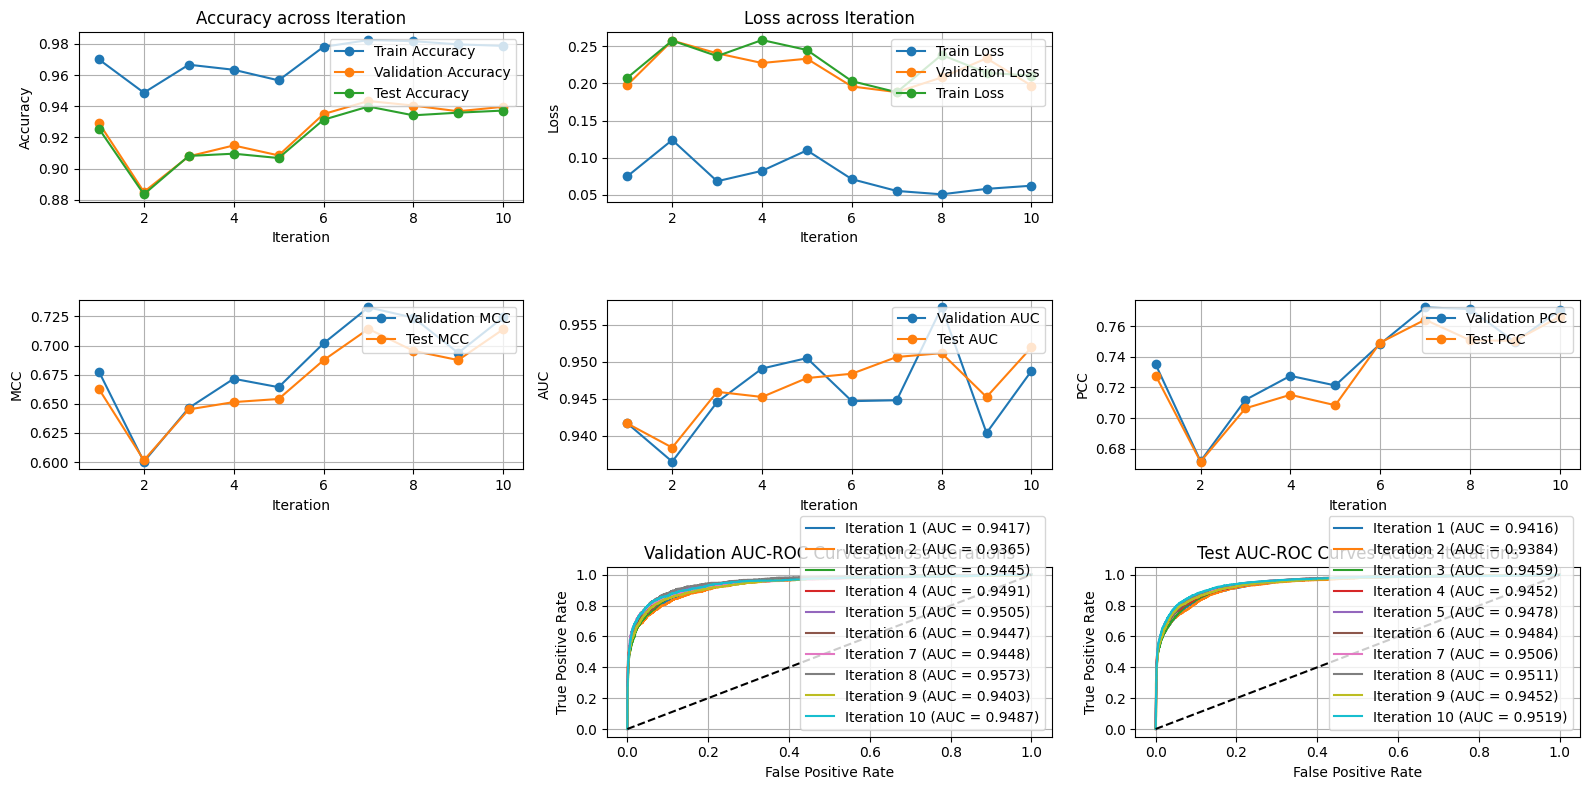

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment1.png')
plt.show()

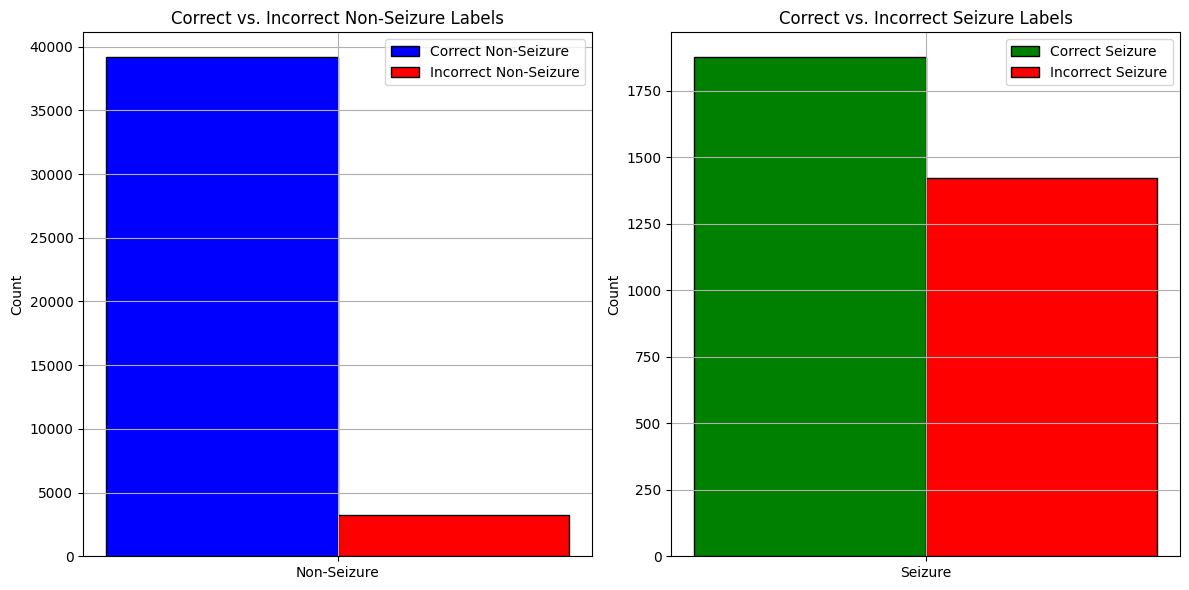

In [ ]:
#extract the indices and their corresponding pseudo labels

pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 2

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_2']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp2.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp2.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp2.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp2.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp2.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 2.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp2.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp2.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Number of confident indices: 3426
Number of confident pseudo-labelled segments = 3426 out of 50271
Percentage of confident pseudo labels = 6.82%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5791 - loss: 0.7522 - val_accuracy: 0.8691 - val_loss: 0.4762
Epoch 2/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8100 - loss: 0.4837 - val_accuracy: 0.8317 - val_loss: 0.4600
Epoch 3/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8706 - loss: 0.3868 - val_accuracy: 0.8454 - val_loss: 0.4208
Epoch 4/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8935 - loss: 0.3445 - val_accuracy: 0.9025 - val_loss: 0.3037
Epoch 5/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8998 - loss: 0.3182 - val_accuracy: 0.9164 - val_loss: 0.3027
Epoch 6/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8979 - loss: 0.2960 - val_accuracy: 0.8759 - val_loss: 0.3553
Epoch 7/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9073 - loss: 0.2860 - val_accuracy: 0.9205 - val_loss: 0.2683
Epoch 8/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9115 - loss: 0.2669 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5586 - loss: 0.7133 - val_accuracy: 0.8977 - val_loss: 0.3776
Epoch 2/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7998 - loss: 0.4803 - val_accuracy: 0.8901 - val_loss: 0.3552
Epoch 3/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8764 - loss: 0.3760 - val_accuracy: 0.9084 - val_loss: 0.3112
Epoch 4/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9002 - loss: 0.3331 - val_accuracy: 0.9045 - val_loss: 0.2639
Epoch 5/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8997 - loss: 0.3119 - val_accuracy: 0.9277 - val_loss: 0.2555
Epoch 6/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9117 - loss: 0.2870 - val_accuracy: 0.9251 - val_loss: 0.2300
Epoch 7/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9096 - loss: 0.2789 - val_accuracy: 0.9265 - val_loss: 0.2130
Epoch 8/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9156 - loss: 0.2749 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6378 - loss: 0.8042 - val_accuracy: 0.8647 - val_loss: 0.3990
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8272 - loss: 0.4380 - val_accuracy: 0.8820 - val_loss: 0.3755
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8729 - loss: 0.3551 - val_accuracy: 0.9169 - val_loss: 0.2786
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8916 - loss: 0.3247 - val_accuracy: 0.9208 - val_loss: 0.2868
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9105 - loss: 0.2956 - val_accuracy: 0.9259 - val_loss: 0.2627
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9155 - loss: 0.2731 - val_accuracy: 0.9237 - val_loss: 0.2762
Epoch 7/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9211 - loss: 0.2588 - val_accuracy: 0.9223 - val_loss: 0.2555
Epoch 8/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9210 - loss: 0.2530 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5487 - loss: 0.8202 - val_accuracy: 0.9064 - val_loss: 0.3971
Epoch 2/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8462 - loss: 0.4331 - val_accuracy: 0.9071 - val_loss: 0.3102
Epoch 3/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8927 - loss: 0.3517 - val_accuracy: 0.9139 - val_loss: 0.3021
Epoch 4/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9038 - loss: 0.3155 - val_accuracy: 0.9216 - val_loss: 0.2484
Epoch 5/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9108 - loss: 0.2915 - val_accuracy: 0.9325 - val_loss: 0.2296
Epoch 6/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9217 - loss: 0.2647 - val_accuracy: 0.9315 - val_loss: 0.2140
Epoch 7/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9209 - loss: 0.2544 - val_accuracy: 0.9129 - val_loss: 0.2507
Epoch 8/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9140 - loss: 0.2570 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4864 - loss: 0.7427 - val_accuracy: 0.8609 - val_loss: 0.4867
Epoch 2/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8136 - loss: 0.4637 - val_accuracy: 0.8617 - val_loss: 0.4397
Epoch 3/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8781 - loss: 0.3581 - val_accuracy: 0.9080 - val_loss: 0.3274
Epoch 4/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9038 - loss: 0.3066 - val_accuracy: 0.9080 - val_loss: 0.3108
Epoch 5/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9107 - loss: 0.2847 - val_accuracy: 0.9060 - val_loss: 0.3060
Epoch 6/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9155 - loss: 0.2737 - val_accuracy: 0.9245 - val_loss: 0.2398
Epoch 7/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9250 - loss: 0.2525 - val_accuracy: 0.9202 - val_loss: 0.2701
Epoch 8/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9245 - loss: 0.2385 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5511 - loss: 0.7395 - val_accuracy: 0.9027 - val_loss: 0.3713
Epoch 2/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8217 - loss: 0.4546 - val_accuracy: 0.9127 - val_loss: 0.2983
Epoch 3/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8818 - loss: 0.3541 - val_accuracy: 0.9224 - val_loss: 0.2480
Epoch 4/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8985 - loss: 0.3084 - val_accuracy: 0.9282 - val_loss: 0.2200
Epoch 5/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9134 - loss: 0.2765 - val_accuracy: 0.9316 - val_loss: 0.2189
Epoch 6/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9155 - loss: 0.2645 - val_accuracy: 0.9270 - val_loss: 0.2487
Epoch 7/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9255 - loss: 0.2485 - val_accuracy: 0.9215 - val_loss: 0.2449
Epoch 8/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9226 - loss: 0.2354 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5844 - loss: 0.8645 - val_accuracy: 0.9042 - val_loss: 0.4421
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8385 - loss: 0.4474 - val_accuracy: 0.9096 - val_loss: 0.3586
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8875 - loss: 0.3641 - val_accuracy: 0.9041 - val_loss: 0.3205
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8993 - loss: 0.3179 - val_accuracy: 0.8849 - val_loss: 0.3491
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9099 - loss: 0.2971 - val_accuracy: 0.8658 - val_loss: 0.3789
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9172 - loss: 0.2745 - val_accuracy: 0.9095 - val_loss: 0.2692
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9237 - loss: 0.2582 - val_accuracy: 0.8490 - val_loss: 0.3667
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9224 - loss: 0.2442 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6383 - loss: 0.7023 - val_accuracy: 0.9049 - val_loss: 0.3392
Epoch 2/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8484 - loss: 0.4166 - val_accuracy: 0.9266 - val_loss: 0.2460
Epoch 3/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8921 - loss: 0.3385 - val_accuracy: 0.9274 - val_loss: 0.2279
Epoch 4/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8937 - loss: 0.3148 - val_accuracy: 0.9315 - val_loss: 0.2130
Epoch 5/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9054 - loss: 0.2838 - val_accuracy: 0.9245 - val_loss: 0.2304
Epoch 6/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9125 - loss: 0.2736 - val_accuracy: 0.9280 - val_loss: 0.2122
Epoch 7/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9133 - loss: 0.2532 - val_accuracy: 0.9313 - val_loss: 0.2054
Epoch 8/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9176 - loss: 0.2398 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5305 - loss: 0.7116 - val_accuracy: 0.8808 - val_loss: 0.3987
Epoch 2/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8195 - loss: 0.4558 - val_accuracy: 0.8711 - val_loss: 0.3519
Epoch 3/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8766 - loss: 0.3591 - val_accuracy: 0.9225 - val_loss: 0.2456
Epoch 4/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8940 - loss: 0.3150 - val_accuracy: 0.9210 - val_loss: 0.2305
Epoch 5/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9035 - loss: 0.2922 - val_accuracy: 0.9279 - val_loss: 0.2215
Epoch 6/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9098 - loss: 0.2616 - val_accuracy: 0.9320 - val_loss: 0.2035
Epoch 7/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9168 - loss: 0.2444 - val_accuracy: 0.9314 - val_loss: 0.2150
Epoch 8/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9209 - loss: 0.2281 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5354 - loss: 0.8920 - val_accuracy: 0.8953 - val_loss: 0.4476
Epoch 2/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7935 - loss: 0.4991 - val_accuracy: 0.9171 - val_loss: 0.3192
Epoch 3/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8594 - loss: 0.4018 - val_accuracy: 0.9243 - val_loss: 0.2730
Epoch 4/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8868 - loss: 0.3416 - val_accuracy: 0.9185 - val_loss: 0.2923
Epoch 5/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8979 - loss: 0.3112 - val_accuracy: 0.9294 - val_loss: 0.2476
Epoch 6/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9029 - loss: 0.2942 - val_accuracy: 0.9290 - val_loss: 0.2293
Epoch 7/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9088 - loss: 0.2770 - val_accuracy: 0.9160 - val_loss: 0.2737
Epoch 8/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9100 - loss: 0.2638 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.94

Number of unlabelled samples remaining: 42273
Iteration 10 complete. Test MCC: 0.5855240388041657, Best MCC so far: 0.7235132554294607
Best model found after 10 iterations with MCC: 0.7235132554294607

aug_model_v10 saved as the best augmented model of experiment 2.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=======

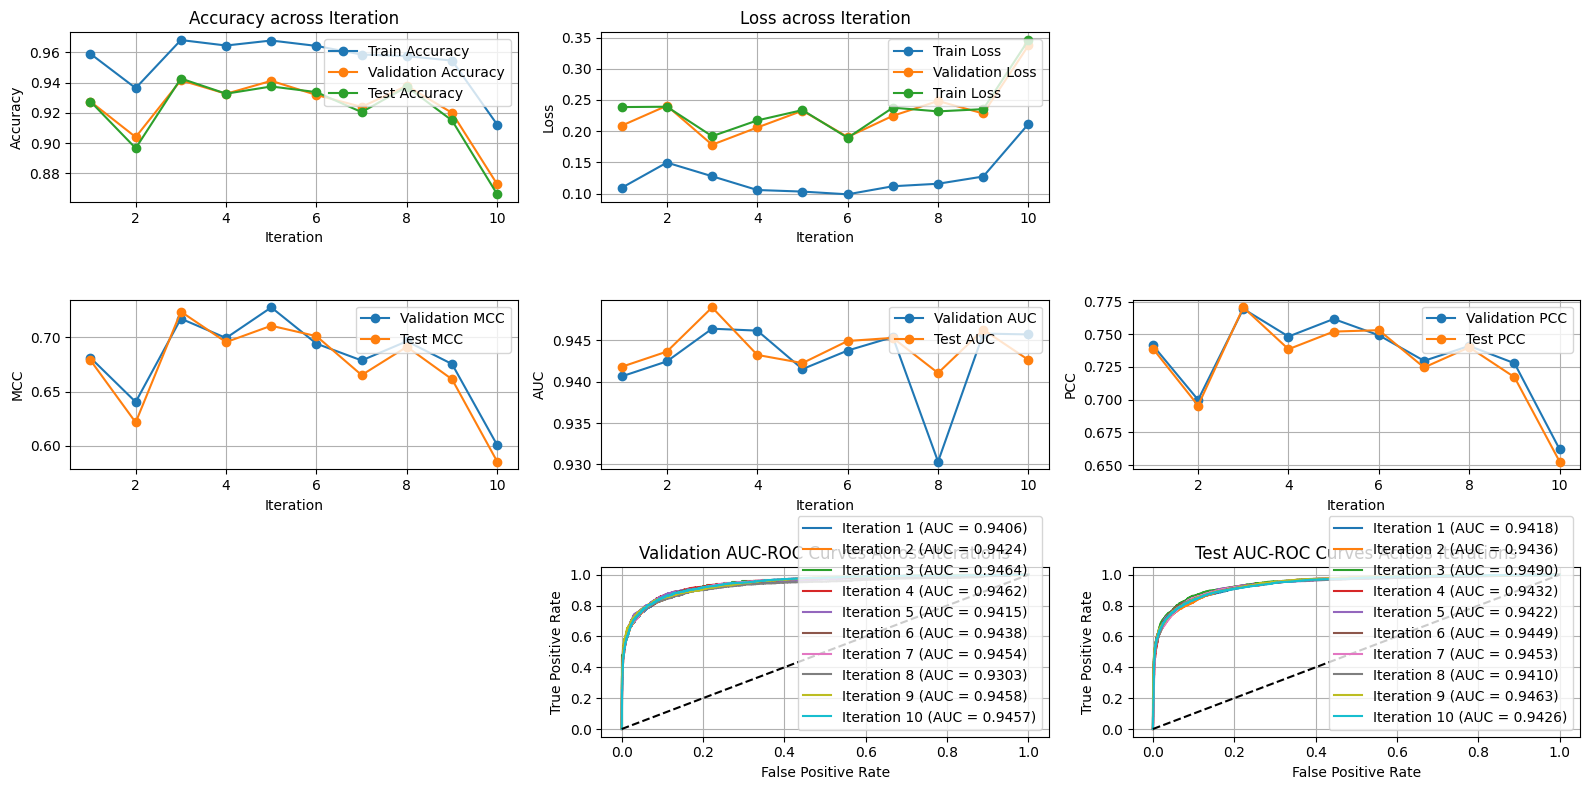

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment2.png')
plt.show()

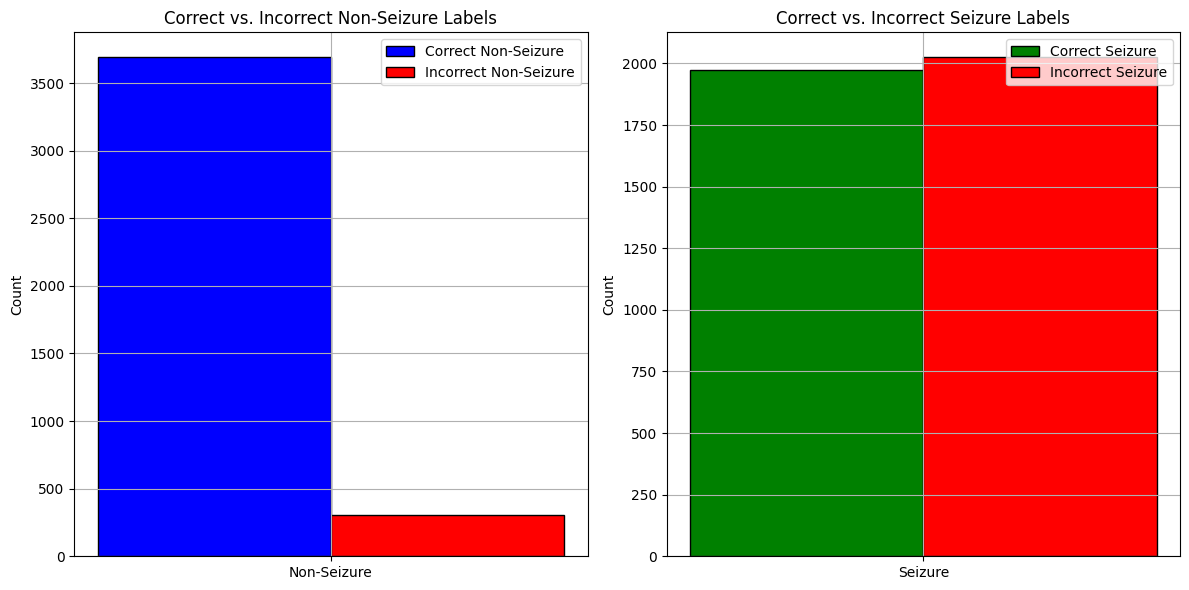

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 3

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_3']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp3.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp3.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp3.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp3.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp3.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 3.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp3.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp3.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Number of confident indices: 1713
Number of confident pseudo-labelled segments = 1713 out of 50271
Percentage of confident pseudo labels = 3.41%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5774 - loss: 0.7732 - val_accuracy: 0.9091 - val_loss: 0.3164
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8330 - loss: 0.4476 - val_accuracy: 0.9236 - val_loss: 0.2924
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8865 - loss: 0.3712 - val_accuracy: 0.9227 - val_loss: 0.2615
Epoch 4/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8900 - loss: 0.3309 - val_accuracy: 0.9177 - val_loss: 0.2549
Epoch 5/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8911 - loss: 0.3067 - val_accuracy: 0.9257 - val_loss: 0.2176
Epoch 6/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8985 - loss: 0.3002 - val_accuracy: 0.9288 - val_loss: 0.2094
Epoch 7/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9039 - loss: 0.2889 - val_accuracy: 0.9204 - val_loss: 0.2175
Epoch 8/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9074 - loss: 0.2732 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6051 - loss: 0.8064 - val_accuracy: 0.9063 - val_loss: 0.3692
Epoch 2/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8548 - loss: 0.4518 - val_accuracy: 0.9225 - val_loss: 0.2965
Epoch 3/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8836 - loss: 0.3944 - val_accuracy: 0.9249 - val_loss: 0.2510
Epoch 4/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9002 - loss: 0.3505 - val_accuracy: 0.9248 - val_loss: 0.2746
Epoch 5/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9016 - loss: 0.3393 - val_accuracy: 0.9284 - val_loss: 0.2662
Epoch 6/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9078 - loss: 0.3065 - val_accuracy: 0.9262 - val_loss: 0.2406
Epoch 7/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9046 - loss: 0.2997 - val_accuracy: 0.9155 - val_loss: 0.2781
Epoch 8/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9132 - loss: 0.2862 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5843 - loss: 0.7746 - val_accuracy: 0.8441 - val_loss: 0.5250
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8397 - loss: 0.4312 - val_accuracy: 0.9203 - val_loss: 0.3105
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8952 - loss: 0.3584 - val_accuracy: 0.9205 - val_loss: 0.3083
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9075 - loss: 0.3064 - val_accuracy: 0.9256 - val_loss: 0.3141
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9141 - loss: 0.2913 - val_accuracy: 0.9220 - val_loss: 0.2668
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9167 - loss: 0.2781 - val_accuracy: 0.9296 - val_loss: 0.2250
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9181 - loss: 0.2670 - val_accuracy: 0.9325 - val_loss: 0.2115
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9182 - loss: 0.2443 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6232 - loss: 0.7281 - val_accuracy: 0.9000 - val_loss: 0.3525
Epoch 2/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8281 - loss: 0.4681 - val_accuracy: 0.9103 - val_loss: 0.3098
Epoch 3/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8739 - loss: 0.3832 - val_accuracy: 0.9230 - val_loss: 0.2800
Epoch 4/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8845 - loss: 0.3549 - val_accuracy: 0.9159 - val_loss: 0.2724
Epoch 5/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8914 - loss: 0.3405 - val_accuracy: 0.9237 - val_loss: 0.2484
Epoch 6/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8968 - loss: 0.3073 - val_accuracy: 0.8967 - val_loss: 0.3478
Epoch 7/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9054 - loss: 0.2859 - val_accuracy: 0.9103 - val_loss: 0.2759
Epoch 8/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9015 - loss: 0.2820 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5723 - loss: 0.7034 - val_accuracy: 0.9030 - val_loss: 0.3545
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8503 - loss: 0.4395 - val_accuracy: 0.9078 - val_loss: 0.3005
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8720 - loss: 0.3666 - val_accuracy: 0.9029 - val_loss: 0.3067
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8966 - loss: 0.3265 - val_accuracy: 0.9231 - val_loss: 0.2489
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9050 - loss: 0.3021 - val_accuracy: 0.9266 - val_loss: 0.2546
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8976 - loss: 0.2921 - val_accuracy: 0.9197 - val_loss: 0.2678
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9110 - loss: 0.2617 - val_accuracy: 0.9230 - val_loss: 0.2375
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9171 - loss: 0.2538 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5796 - loss: 0.6852 - val_accuracy: 0.8790 - val_loss: 0.4135
Epoch 2/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8384 - loss: 0.4319 - val_accuracy: 0.9112 - val_loss: 0.3447
Epoch 3/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8789 - loss: 0.3599 - val_accuracy: 0.9183 - val_loss: 0.3005
Epoch 4/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8925 - loss: 0.3217 - val_accuracy: 0.8794 - val_loss: 0.3556
Epoch 5/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8986 - loss: 0.3012 - val_accuracy: 0.9225 - val_loss: 0.2420
Epoch 6/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9079 - loss: 0.2772 - val_accuracy: 0.9287 - val_loss: 0.2562
Epoch 7/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9172 - loss: 0.2603 - val_accuracy: 0.8307 - val_loss: 0.4006
Epoch 8/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9134 - loss: 0.2504 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5597 - loss: 0.7231 - val_accuracy: 0.9021 - val_loss: 0.3906
Epoch 2/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8454 - loss: 0.4327 - val_accuracy: 0.9176 - val_loss: 0.3136
Epoch 3/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8840 - loss: 0.3664 - val_accuracy: 0.9094 - val_loss: 0.2937
Epoch 4/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9014 - loss: 0.3217 - val_accuracy: 0.9287 - val_loss: 0.2191
Epoch 5/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9120 - loss: 0.2981 - val_accuracy: 0.9304 - val_loss: 0.2162
Epoch 6/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9189 - loss: 0.2761 - val_accuracy: 0.9294 - val_loss: 0.2146
Epoch 7/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9187 - loss: 0.2637 - val_accuracy: 0.9347 - val_loss: 0.1973
Epoch 8/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9215 - loss: 0.2605 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5496 - loss: 0.7732 - val_accuracy: 0.9072 - val_loss: 0.3826
Epoch 2/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8497 - loss: 0.4127 - val_accuracy: 0.9252 - val_loss: 0.2411
Epoch 3/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8958 - loss: 0.3330 - val_accuracy: 0.9294 - val_loss: 0.2226
Epoch 4/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9038 - loss: 0.3045 - val_accuracy: 0.9156 - val_loss: 0.2615
Epoch 5/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9124 - loss: 0.2922 - val_accuracy: 0.9336 - val_loss: 0.2097
Epoch 6/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9183 - loss: 0.2642 - val_accuracy: 0.9231 - val_loss: 0.2256
Epoch 7/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9227 - loss: 0.2518 - val_accuracy: 0.9358 - val_loss: 0.1927
Epoch 8/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9266 - loss: 0.2363 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5755 - loss: 0.8151 - val_accuracy: 0.8824 - val_loss: 0.4124
Epoch 2/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7700 - loss: 0.5202 - val_accuracy: 0.9127 - val_loss: 0.3019
Epoch 3/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8613 - loss: 0.3896 - val_accuracy: 0.9255 - val_loss: 0.2795
Epoch 4/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8875 - loss: 0.3379 - val_accuracy: 0.9268 - val_loss: 0.2688
Epoch 5/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8968 - loss: 0.3145 - val_accuracy: 0.9257 - val_loss: 0.2490
Epoch 6/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9046 - loss: 0.2954 - val_accuracy: 0.9228 - val_loss: 0.2759
Epoch 7/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9085 - loss: 0.2808 - val_accuracy: 0.9328 - val_loss: 0.2368
Epoch 8/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9156 - loss: 0.2561 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.4839 - loss: 0.7726 - val_accuracy: 0.8939 - val_loss: 0.4000
Epoch 2/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7676 - loss: 0.5197 - val_accuracy: 0.9146 - val_loss: 0.3092
Epoch 3/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8678 - loss: 0.3830 - val_accuracy: 0.9284 - val_loss: 0.2775
Epoch 4/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8972 - loss: 0.3209 - val_accuracy: 0.9125 - val_loss: 0.2975
Epoch 5/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9022 - loss: 0.2987 - val_accuracy: 0.9318 - val_loss: 0.2266
Epoch 6/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9054 - loss: 0.2863 - val_accuracy: 0.9343 - val_loss: 0.2031
Epoch 7/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9130 - loss: 0.2622 - val_accuracy: 0.9326 - val_loss: 0.1975
Epoch 8/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9172 - loss: 0.2459 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.94

Number of unlabelled samples remaining: 46906
Iteration 10 complete. Test MCC: 0.67754023724436, Best MCC so far: 0.709280227495074
Best model found after 10 iterations with MCC: 0.709280227495074

aug_model_v10 saved as the best augmented model of experiment 3.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+===========

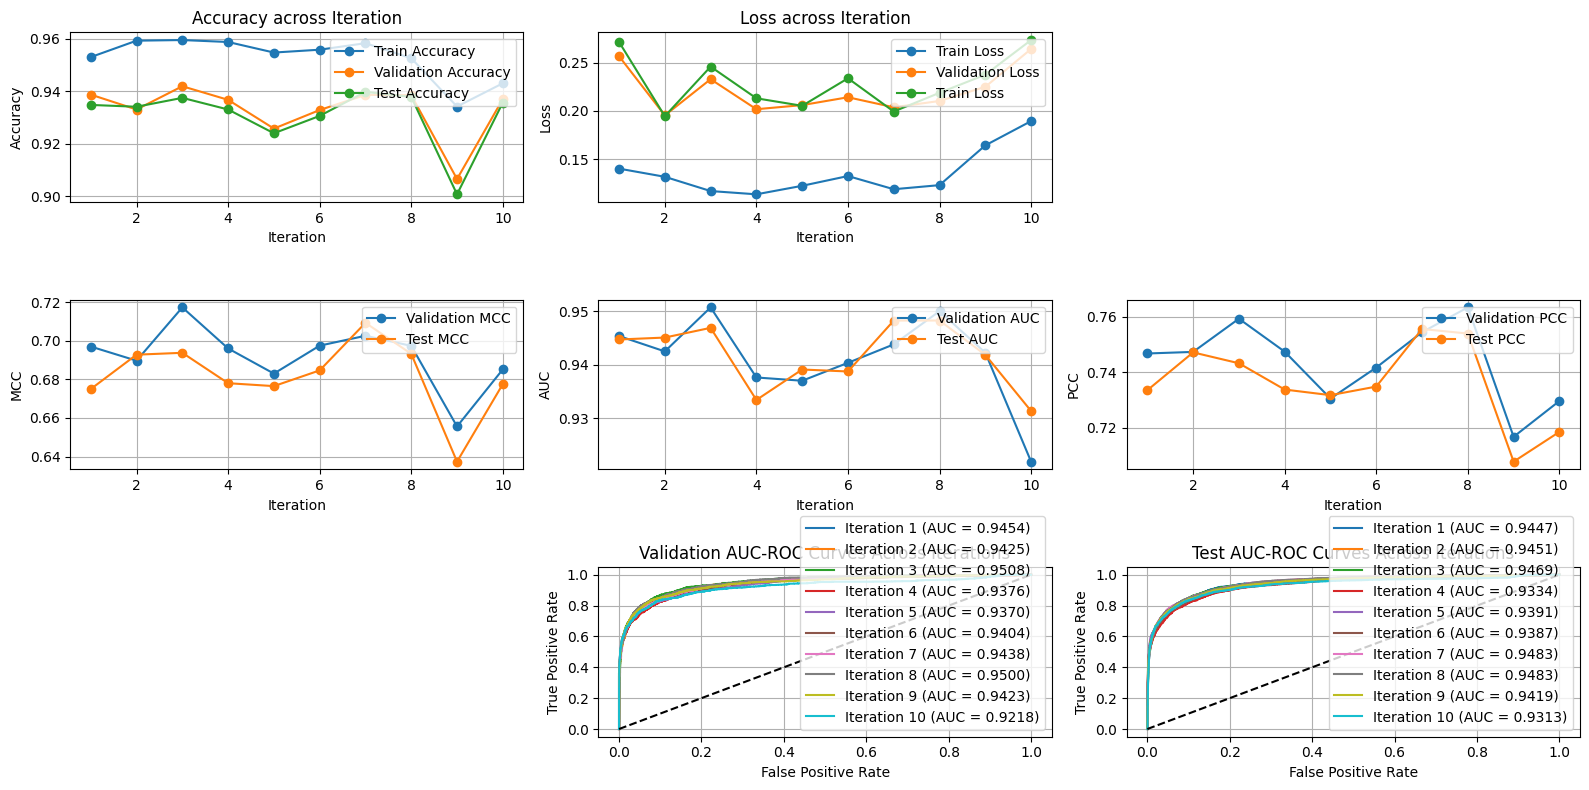

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment3.png')
plt.show()

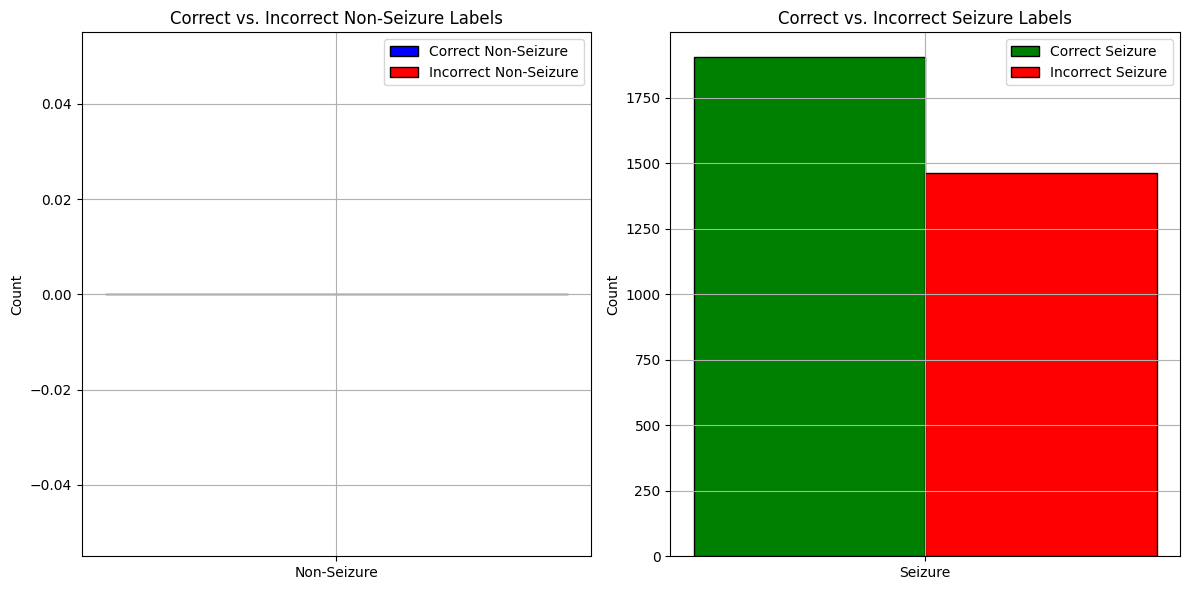

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 4

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_4']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp4.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp4.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp4.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp4.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp4.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 4.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp4.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp4.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step

Number of confident indices: 18082
Number of confident pseudo-labelled segments = 18082 out of 50271
Percentage of confident pseudo labels = 35.97%
Previous shape of training data: (20037, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.5281 - loss: 0.8177 - val_accuracy: 0.6273 - val_loss: 0.6578
Epoch 2/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.6757 - loss: 0.5989 - val_accuracy: 0.7558 - val_loss: 0.6017
Epoch 3/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8099 - loss: 0.5253 - val_accuracy: 0.8129 - val_loss: 0.5067
Epoch 4/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8336 - loss: 0.4395 - val_accuracy: 0.8437 - val_loss: 0.4223
Epoch 5/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8531 - loss: 0.3856 - val_accuracy: 0.6682 - val_loss: 0.5880
Epoch 6/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8593 - loss: 0.3701 - val_accuracy: 0.8523 - val_loss: 0.3762
Epoch 7/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8686 - loss: 0.3356 - val_accuracy: 0.8542 - val_loss: 0.3647
Epoch 8/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8713 -

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |           0.27505 |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 60s 37ms/step - accuracy: 0.4912 - loss: 0.7327 - val_accuracy: 0.7324 - val_loss: 0.6365
Epoch 2/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.6826 - loss: 0.6159 - val_accuracy: 0.8292 - val_loss: 0.4657
Epoch 3/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.7896 - loss: 0.5377 - val_accuracy: 0.8903 - val_loss: 0.3723
Epoch 4/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8269 - loss: 0.4576 - val_accuracy: 0.8472 - val_loss: 0.4234
Epoch 5/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8306 - loss: 0.4068 - val_accuracy: 0.7735 - val_loss: 0.4995
Epoch 6/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8400 - loss: 0.3951 - val_accuracy: 0.6998 - val_loss: 0.5708
Epoch 7/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.8411 - loss: 0.3955 - val_accuracy: 0.8033 - val_loss: 0.4657
Epoch 8/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8633 -

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.5541 - loss: 0.8224 - val_accuracy: 0.7944 - val_loss: 0.5617
Epoch 2/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.7847 - loss: 0.5194 - val_accuracy: 0.8636 - val_loss: 0.3818
Epoch 3/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8292 - loss: 0.4507 - val_accuracy: 0.8379 - val_loss: 0.4115
Epoch 4/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8599 - loss: 0.3936 - val_accuracy: 0.8428 - val_loss: 0.4021
Epoch 5/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8772 - loss: 0.3540 - val_accuracy: 0.8588 - val_loss: 0.3711
Epoch 6/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8781 - loss: 0.3291 - val_accuracy: 0.8771 - val_loss: 0.2869
Epoch 7/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8824 - loss: 0.3057 - val_accuracy: 0.8466 - val_loss: 0.3664
Epoch 8/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8818 -

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.5421 - loss: 0.8184 - val_accuracy: 0.7172 - val_loss: 0.6531
Epoch 2/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8072 - loss: 0.5891 - val_accuracy: 0.8283 - val_loss: 0.5211
Epoch 3/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8422 - loss: 0.4956 - val_accuracy: 0.8642 - val_loss: 0.4295
Epoch 4/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8472 - loss: 0.4481 - val_accuracy: 0.8819 - val_loss: 0.3738
Epoch 5/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8595 - loss: 0.4046 - val_accuracy: 0.8872 - val_loss: 0.3166
Epoch 6/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8755 - loss: 0.3771 - val_accuracy: 0.8791 - val_loss: 0.3192
Epoch 7/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8784 - loss: 0.3704 - val_accuracy: 0.9024 - val_loss: 0.2713
Epoch 8/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8843 -

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.5516 - loss: 0.7322 - val_accuracy: 0.6207 - val_loss: 0.7079
Epoch 2/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.7818 - loss: 0.5783 - val_accuracy: 0.7198 - val_loss: 0.6115
Epoch 3/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.8525 - loss: 0.4550 - val_accuracy: 0.8051 - val_loss: 0.4767
Epoch 4/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.8536 - loss: 0.4108 - val_accuracy: 0.7398 - val_loss: 0.5519
Epoch 5/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.8646 - loss: 0.3793 - val_accuracy: 0.7890 - val_loss: 0.5013
Epoch 6/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.8619 - loss: 0.3696 - val_accuracy: 0.8484 - val_loss: 0.3490
Epoch 7/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.8801 - loss: 0.3276 - val_accuracy: 0.8919 - val_loss: 0.2963
Epoch 8/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.8884 -

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 68s 37ms/step - accuracy: 0.4617 - loss: 0.7506 - val_accuracy: 0.6536 - val_loss: 0.6594
Epoch 2/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.7628 - loss: 0.6167 - val_accuracy: 0.8791 - val_loss: 0.5007
Epoch 3/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.8339 - loss: 0.5295 - val_accuracy: 0.8790 - val_loss: 0.4250
Epoch 4/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8337 - loss: 0.4747 - val_accuracy: 0.8537 - val_loss: 0.4695
Epoch 5/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8481 - loss: 0.4481 - val_accuracy: 0.8363 - val_loss: 0.4646
Epoch 6/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8540 - loss: 0.4378 - val_accuracy: 0.8746 - val_loss: 0.3913
Epoch 7/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8809 - loss: 0.3813 - val_accuracy: 0.8896 - val_loss: 0.3353
Epoch 8/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8782 -

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - accuracy: 0.5491 - loss: 0.8595 - val_accuracy: 0.7574 - val_loss: 0.6075
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7945 - loss: 0.5373 - val_accuracy: 0.8484 - val_loss: 0.4456
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.8396 - loss: 0.4668 - val_accuracy: 0.8558 - val_loss: 0.3626
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8185 - loss: 0.4533 - val_accuracy: 0.8803 - val_loss: 0.3415
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.8619 - loss: 0.3987 - val_accuracy: 0.8763 - val_loss: 0.3179
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.8737 - loss: 0.3781 - val_accuracy: 0.8994 - val_loss: 0.2914
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8768 - loss: 0.3418 - val_accuracy: 0.8479 - val_loss: 0.3618
Epoch 8/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8684 -

+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929505 |        0.890288 |    0.27707  |

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.6166 - loss: 0.7126 - val_accuracy: 0.8583 - val_loss: 0.5570
Epoch 2/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8444 - loss: 0.5126 - val_accuracy: 0.8527 - val_loss: 0.4627
Epoch 3/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8629 - loss: 0.4376 - val_accuracy: 0.9116 - val_loss: 0.3253
Epoch 4/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8569 - loss: 0.3998 - val_accuracy: 0.8826 - val_loss: 0.3644
Epoch 5/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8809 - loss: 0.3520 - val_accuracy: 0.8748 - val_loss: 0.3806
Epoch 6/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8834 - loss: 0.3400 - val_accuracy: 0.9098 - val_loss: 0.2986
Epoch 7/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8867 - loss: 0.3145 - val_accuracy: 0.8985 - val_loss: 0.2655
Epoch 8/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8823 -

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.5269 - loss: 0.7244 - val_accuracy: 0.6779 - val_loss: 0.6366
Epoch 2/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.7707 - loss: 0.5386 - val_accuracy: 0.8710 - val_loss: 0.4225
Epoch 3/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8318 - loss: 0.4518 - val_accuracy: 0.8771 - val_loss: 0.3457
Epoch 4/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8469 - loss: 0.4099 - val_accuracy: 0.9087 - val_loss: 0.2939
Epoch 5/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8502 - loss: 0.4008 - val_accuracy: 0.8975 - val_loss: 0.2669
Epoch 6/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8574 - loss: 0.3622 - val_accuracy: 0.8634 - val_loss: 0.3253
Epoch 7/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8673 - loss: 0.3345 - val_accuracy: 0.8854 - val_loss: 0.2886
Epoch 8/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8846 -

+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929505 |        0.890288 |    0.27707  |

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - accuracy: 0.5095 - loss: 0.8789 - val_accuracy: 0.6981 - val_loss: 0.6522
Epoch 2/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.7178 - loss: 0.5927 - val_accuracy: 0.8467 - val_loss: 0.4883
Epoch 3/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8443 - loss: 0.4935 - val_accuracy: 0.8954 - val_loss: 0.3896
Epoch 4/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.8393 - loss: 0.4549 - val_accuracy: 0.9074 - val_loss: 0.3122
Epoch 5/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8526 - loss: 0.4212 - val_accuracy: 0.8880 - val_loss: 0.3130
Epoch 6/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.8752 - loss: 0.3891 - val_accuracy: 0.8800 - val_loss: 0.3409
Epoch 7/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8764 - loss: 0.3634 - val_accuracy: 0.9025 - val_loss: 0.2944
Epoch 8/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8740 -

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.92

Number of unlabelled samples remaining: 11609
Iteration 10 complete. Test MCC: 0.6176649391359522, Best MCC so far: 0.6176649391359522
Best model found after 10 iterations with MCC: 0.6176649391359522

aug_model_v10 saved as the best augmented model of experiment 4.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=======

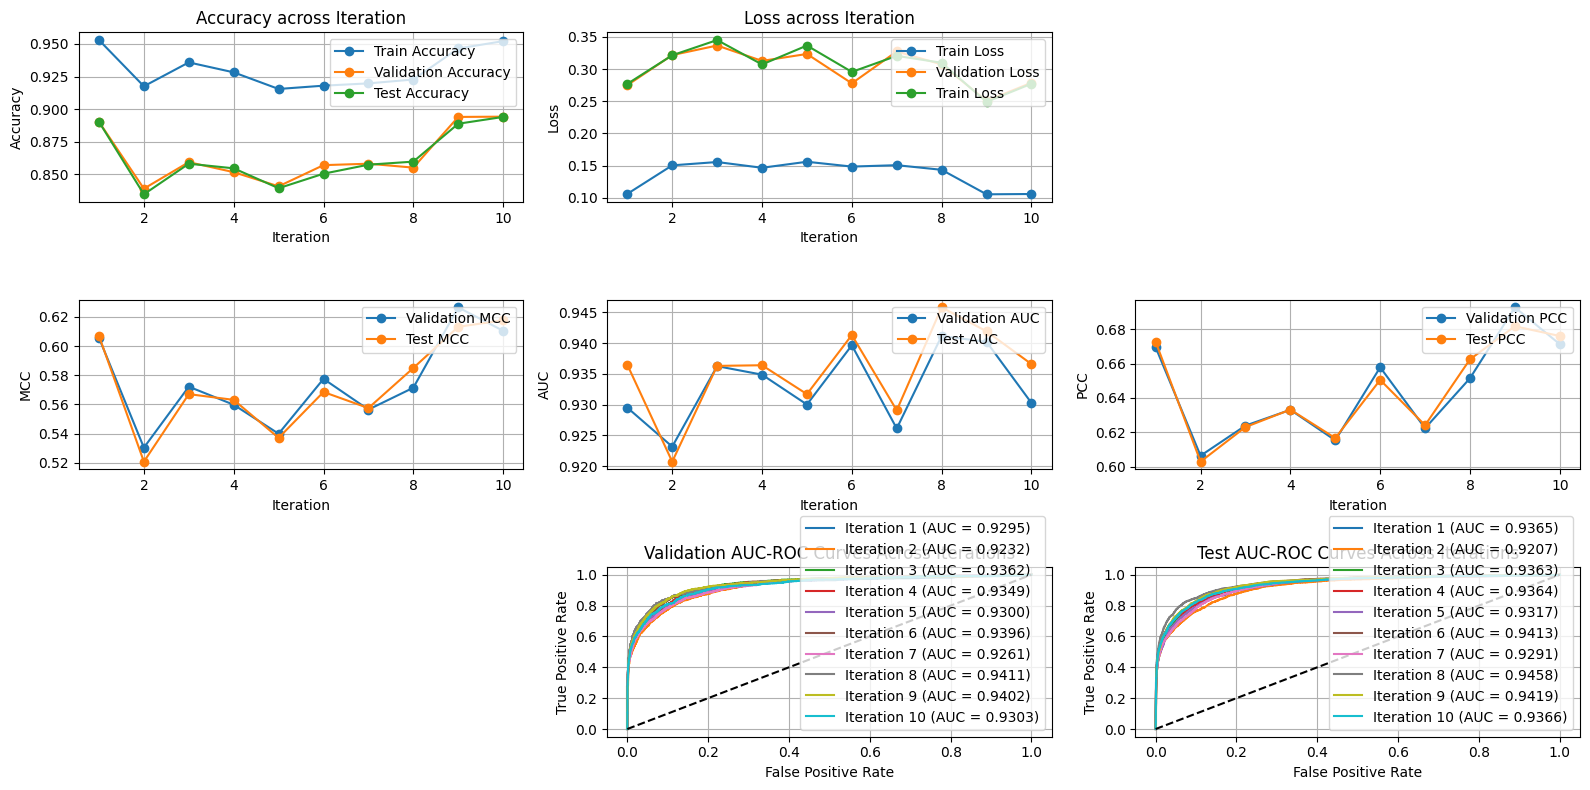

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment4.png')
plt.show()

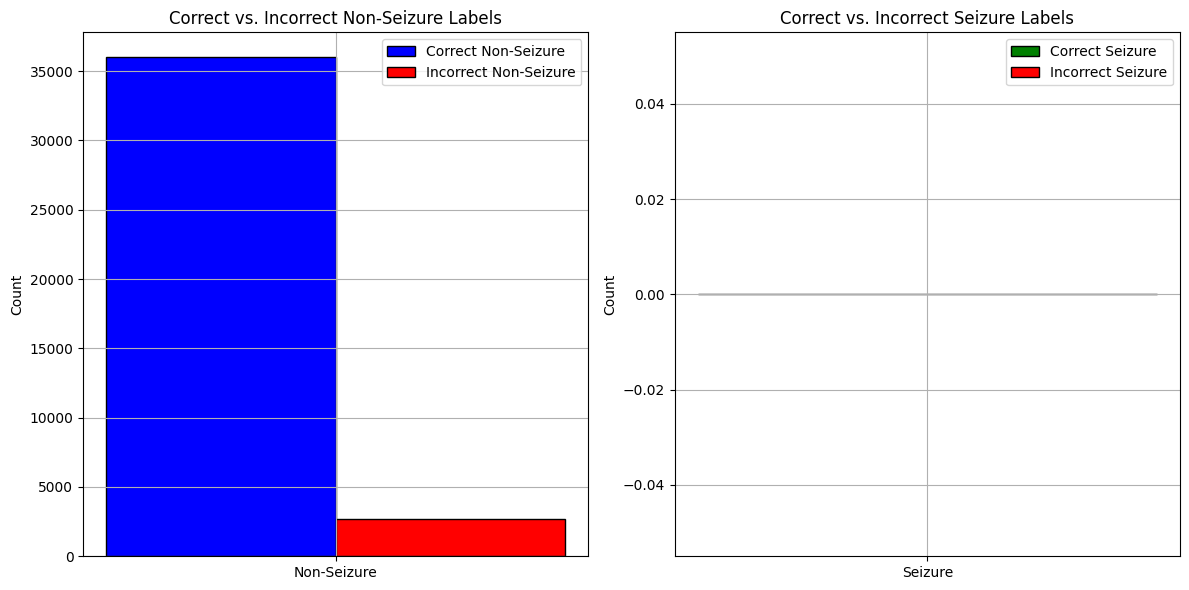

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 5

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_5']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp5.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp5.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp5.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp5.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp5.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 5.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp5.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp5.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step

Number of confident indices: 19797
Number of confident pseudo-labelled segments = 19797 out of 50271
Percentage of confident pseudo labels = 39.38%
Previous shape of training data: (20037, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 38ms/step - accuracy: 0.6437 - loss: 0.6682 - val_accuracy: 0.9013 - val_loss: 0.4071
Epoch 2/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.8541 - loss: 0.4551 - val_accuracy: 0.8596 - val_loss: 0.3670
Epoch 3/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.8741 - loss: 0.3595 - val_accuracy: 0.8973 - val_loss: 0.3063
Epoch 4/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.8902 - loss: 0.3135 - val_accuracy: 0.8820 - val_loss: 0.3060
Epoch 5/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9017 - loss: 0.2882 - val_accuracy: 0.8670 - val_loss: 0.3249
Epoch 6/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9067 - loss: 0.2687 - val_accuracy: 0.8427 - val_loss: 0.3547
Epoch 7/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9166 - loss: 0.2466 - val_accuracy: 0.8535 - val_loss: 0.3187
Epoch 8/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9078 -

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.5492 - loss: 0.7712 - val_accuracy: 0.8837 - val_loss: 0.4253
Epoch 2/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - accuracy: 0.8731 - loss: 0.4168 - val_accuracy: 0.9119 - val_loss: 0.2848
Epoch 3/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.9044 - loss: 0.3358 - val_accuracy: 0.8668 - val_loss: 0.3531
Epoch 4/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.9027 - loss: 0.3100 - val_accuracy: 0.8956 - val_loss: 0.2926
Epoch 5/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.9063 - loss: 0.2887 - val_accuracy: 0.9085 - val_loss: 0.2609
Epoch 6/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.9113 - loss: 0.2691 - val_accuracy: 0.8985 - val_loss: 0.2613
Epoch 7/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9155 - loss: 0.2539 - val_accuracy: 0.8949 - val_loss: 0.3064
Epoch 8/30
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.9251 -

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 63s 36ms/step - accuracy: 0.6310 - loss: 0.7074 - val_accuracy: 0.8674 - val_loss: 0.3861
Epoch 2/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.9023 - loss: 0.3476 - val_accuracy: 0.9145 - val_loss: 0.2673
Epoch 3/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.9125 - loss: 0.2928 - val_accuracy: 0.9185 - val_loss: 0.2730
Epoch 4/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.9160 - loss: 0.2699 - val_accuracy: 0.8768 - val_loss: 0.3281
Epoch 5/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.9242 - loss: 0.2423 - val_accuracy: 0.8864 - val_loss: 0.2937
Epoch 6/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.9241 - loss: 0.2329 - val_accuracy: 0.8859 - val_loss: 0.2803
Epoch 7/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.9291 - loss: 0.2164 - val_accuracy: 0.8817 - val_loss: 0.3035
Epoch 8/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.9311 -

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.5243 - loss: 0.7251 - val_accuracy: 0.8710 - val_loss: 0.4304
Epoch 2/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.8847 - loss: 0.3867 - val_accuracy: 0.9061 - val_loss: 0.3110
Epoch 3/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9201 - loss: 0.3140 - val_accuracy: 0.9023 - val_loss: 0.3247
Epoch 4/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - accuracy: 0.9268 - loss: 0.2872 - val_accuracy: 0.8996 - val_loss: 0.2844
Epoch 5/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.9342 - loss: 0.2589 - val_accuracy: 0.8874 - val_loss: 0.3074
Epoch 6/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.9350 - loss: 0.2347 - val_accuracy: 0.9050 - val_loss: 0.2598
Epoch 7/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.9360 - loss: 0.2215 - val_accuracy: 0.9068 - val_loss: 0.2619
Epoch 8/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.9365 -

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5866 - loss: 0.6879 - val_accuracy: 0.8607 - val_loss: 0.4538
Epoch 2/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8940 - loss: 0.3699 - val_accuracy: 0.8841 - val_loss: 0.3628
Epoch 3/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.9156 - loss: 0.2986 - val_accuracy: 0.9048 - val_loss: 0.3020
Epoch 4/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.9200 - loss: 0.2736 - val_accuracy: 0.8278 - val_loss: 0.3697
Epoch 5/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.9193 - loss: 0.2461 - val_accuracy: 0.8768 - val_loss: 0.3338
Epoch 6/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9244 - loss: 0.2290 - val_accuracy: 0.9123 - val_loss: 0.2744
Epoch 7/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9318 - loss: 0.2056 - val_accuracy: 0.9181 - val_loss: 0.2215
Epoch 8/30
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9289 -

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - accuracy: 0.6117 - loss: 0.7791 - val_accuracy: 0.7043 - val_loss: 0.6447
Epoch 2/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8892 - loss: 0.3830 - val_accuracy: 0.8474 - val_loss: 0.4108
Epoch 3/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.9138 - loss: 0.3068 - val_accuracy: 0.8772 - val_loss: 0.3461
Epoch 4/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9093 - loss: 0.2845 - val_accuracy: 0.8484 - val_loss: 0.3876
Epoch 5/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9173 - loss: 0.2577 - val_accuracy: 0.8794 - val_loss: 0.3150
Epoch 6/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.9207 - loss: 0.2531 - val_accuracy: 0.8790 - val_loss: 0.3497
Epoch 7/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9229 - loss: 0.2361 - val_accuracy: 0.8216 - val_loss: 0.4013
Epoch 8/30
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9263 -

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - accuracy: 0.7131 - loss: 0.6048 - val_accuracy: 0.8425 - val_loss: 0.4246
Epoch 2/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.9066 - loss: 0.3148 - val_accuracy: 0.8893 - val_loss: 0.3048
Epoch 3/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.9207 - loss: 0.2681 - val_accuracy: 0.8977 - val_loss: 0.2856
Epoch 4/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.9244 - loss: 0.2301 - val_accuracy: 0.9119 - val_loss: 0.2383
Epoch 5/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9269 - loss: 0.2200 - val_accuracy: 0.9100 - val_loss: 0.2398
Epoch 6/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9336 - loss: 0.2028 - val_accuracy: 0.9230 - val_loss: 0.2200
Epoch 7/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9382 - loss: 0.1982 - val_accuracy: 0.9082 - val_loss: 0.2366
Epoch 8/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.9412 -

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.6534 - loss: 0.6194 - val_accuracy: 0.8942 - val_loss: 0.2897
Epoch 2/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.9072 - loss: 0.3358 - val_accuracy: 0.9100 - val_loss: 0.2650
Epoch 3/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9170 - loss: 0.2811 - val_accuracy: 0.9043 - val_loss: 0.2839
Epoch 4/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9261 - loss: 0.2585 - val_accuracy: 0.8667 - val_loss: 0.3269
Epoch 5/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9314 - loss: 0.2283 - val_accuracy: 0.9181 - val_loss: 0.2456
Epoch 6/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9334 - loss: 0.2240 - val_accuracy: 0.8915 - val_loss: 0.2745
Epoch 7/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9328 - loss: 0.2055 - val_accuracy: 0.9004 - val_loss: 0.2381
Epoch 8/30
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9369 -

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 65s 38ms/step - accuracy: 0.5736 - loss: 0.7531 - val_accuracy: 0.9143 - val_loss: 0.2997
Epoch 2/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.8785 - loss: 0.3654 - val_accuracy: 0.8924 - val_loss: 0.3008
Epoch 3/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.9082 - loss: 0.3012 - val_accuracy: 0.8830 - val_loss: 0.3148
Epoch 4/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.9167 - loss: 0.2730 - val_accuracy: 0.8614 - val_loss: 0.3486
Epoch 5/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - accuracy: 0.9229 - loss: 0.2525 - val_accuracy: 0.8930 - val_loss: 0.2714
Epoch 6/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.9288 - loss: 0.2353 - val_accuracy: 0.9141 - val_loss: 0.2475
Epoch 7/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.9333 - loss: 0.2182 - val_accuracy: 0.9153 - val_loss: 0.2278
Epoch 8/30
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.9307 -

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 70s 36ms/step - accuracy: 0.6808 - loss: 0.6956 - val_accuracy: 0.9113 - val_loss: 0.2968
Epoch 2/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9017 - loss: 0.3595 - val_accuracy: 0.9058 - val_loss: 0.3127
Epoch 3/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9280 - loss: 0.2995 - val_accuracy: 0.8886 - val_loss: 0.3263
Epoch 4/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.9311 - loss: 0.2698 - val_accuracy: 0.8784 - val_loss: 0.3365
Epoch 5/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.9281 - loss: 0.2628 - val_accuracy: 0.8189 - val_loss: 0.4308
Epoch 6/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.9265 - loss: 0.2583 - val_accuracy: 0.8779 - val_loss: 0.3211
Epoch 7/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.9328 - loss: 0.2363 - val_accuracy: 0.8950 - val_loss: 0.2903
Epoch 8/30
1802/1802 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9307 -

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.94

Iteration 10 complete. Test MCC: 0.6466086677041942, Best MCC so far: 0.6716200113699227
Best model found after 10 iterations with MCC: 0.6716200113699227

aug_model_v10 saved as the best augmented model of experiment 5.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+

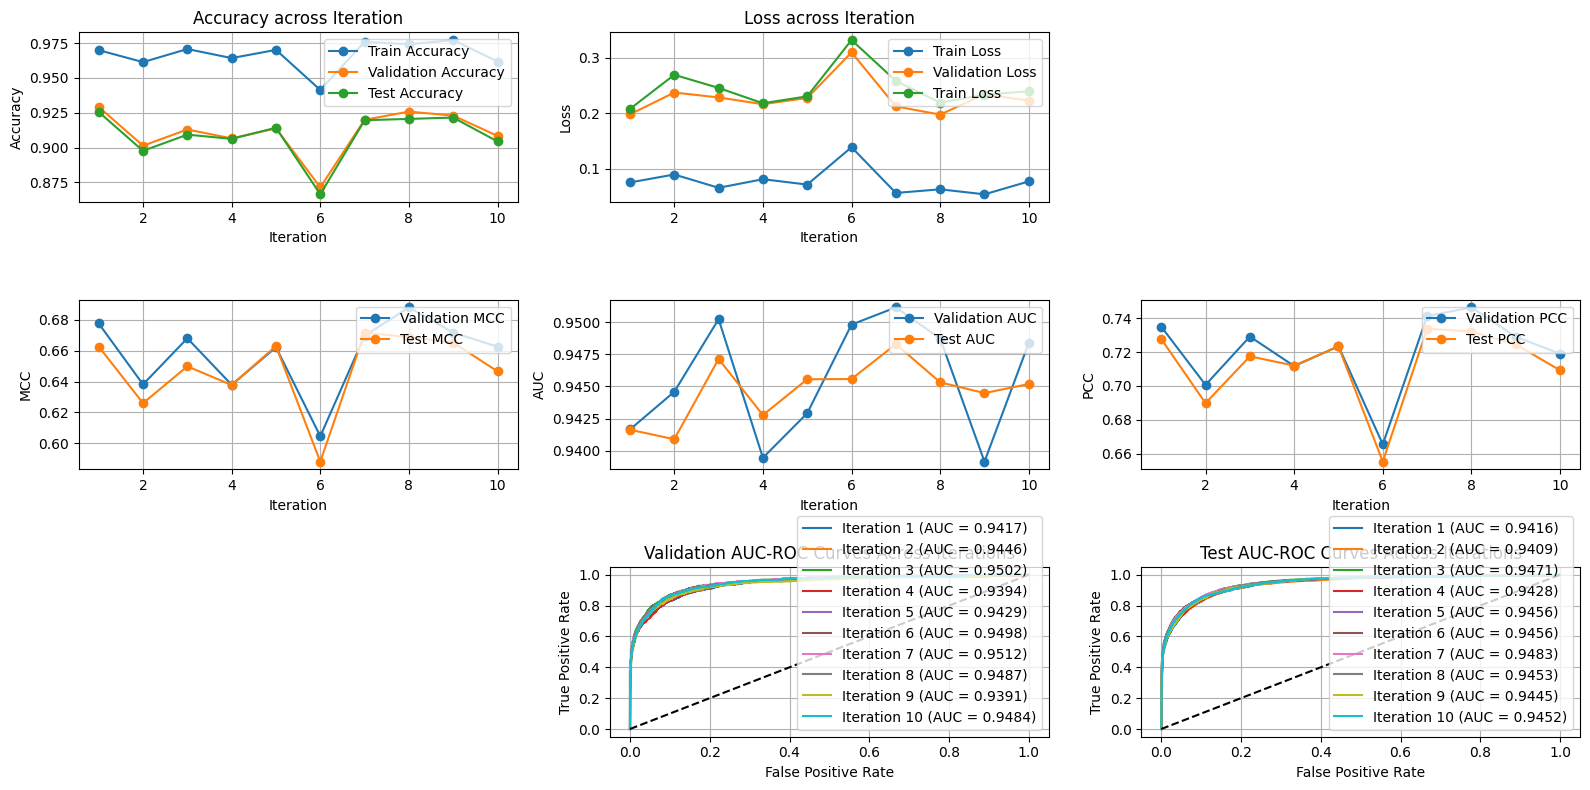

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment5.png')
plt.show()

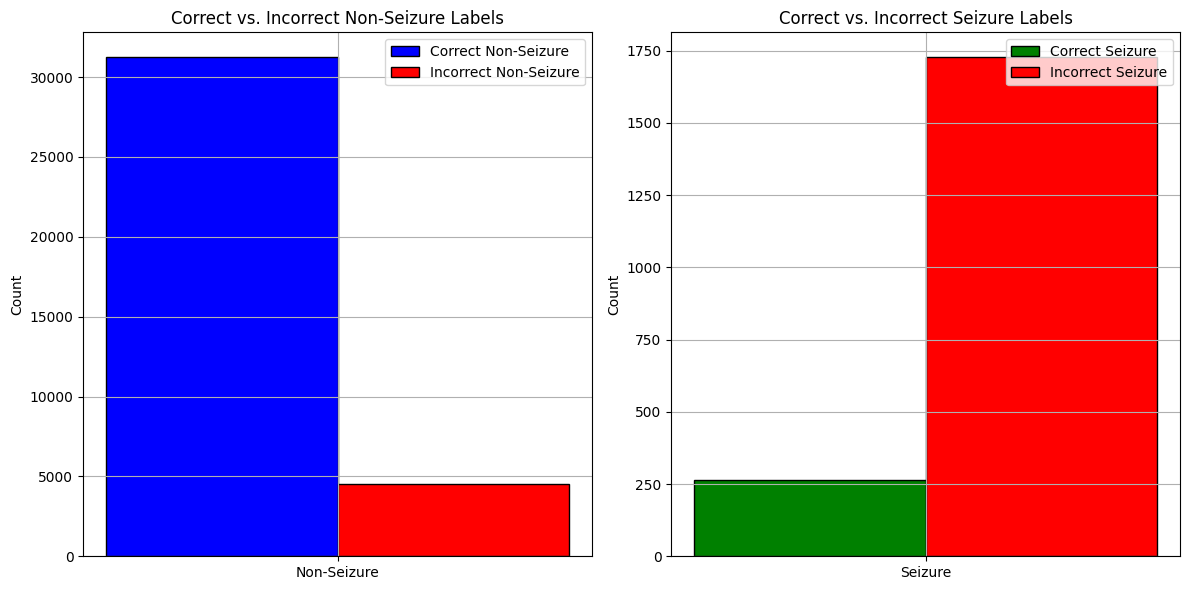

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 6

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_6']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp6.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp6.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp6.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp6.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp6.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 6.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp6.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp6.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Number of confident indices: 3426
Number of confident pseudo-labelled segments = 3426 out of 50271
Percentage of confident pseudo labels = 6.82%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6065 - loss: 0.7569 - val_accuracy: 0.9086 - val_loss: 0.3674
Epoch 2/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8779 - loss: 0.4142 - val_accuracy: 0.8213 - val_loss: 0.5180
Epoch 3/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8975 - loss: 0.3586 - val_accuracy: 0.9285 - val_loss: 0.2872
Epoch 4/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9080 - loss: 0.3366 - val_accuracy: 0.9238 - val_loss: 0.2835
Epoch 5/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9106 - loss: 0.3148 - val_accuracy: 0.9222 - val_loss: 0.2641
Epoch 6/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9119 - loss: 0.2973 - val_accuracy: 0.8915 - val_loss: 0.3351
Epoch 7/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9100 - loss: 0.2814 - val_accuracy: 0.8969 - val_loss: 0.2815
Epoch 8/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9063 - loss: 0.2579 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |     0.124213 |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6062 - loss: 0.7609 - val_accuracy: 0.8976 - val_loss: 0.3212
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8336 - loss: 0.4570 - val_accuracy: 0.9134 - val_loss: 0.2992
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8834 - loss: 0.3639 - val_accuracy: 0.9222 - val_loss: 0.2766
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9003 - loss: 0.3121 - val_accuracy: 0.9291 - val_loss: 0.2348
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9115 - loss: 0.2855 - val_accuracy: 0.9251 - val_loss: 0.2452
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9167 - loss: 0.2680 - val_accuracy: 0.9263 - val_loss: 0.2568
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9209 - loss: 0.2583 - val_accuracy: 0.9326 - val_loss: 0.2096
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9170 - loss: 0.2452 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |     0.124213 |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5295 - loss: 0.8950 - val_accuracy: 0.9064 - val_loss: 0.4101
Epoch 2/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8415 - loss: 0.4442 - val_accuracy: 0.9269 - val_loss: 0.2950
Epoch 3/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8957 - loss: 0.3596 - val_accuracy: 0.9287 - val_loss: 0.2659
Epoch 4/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9099 - loss: 0.3137 - val_accuracy: 0.9243 - val_loss: 0.2883
Epoch 5/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9183 - loss: 0.2902 - val_accuracy: 0.9310 - val_loss: 0.2488
Epoch 6/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9203 - loss: 0.2801 - val_accuracy: 0.9335 - val_loss: 0.2505
Epoch 7/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9228 - loss: 0.2623 - val_accuracy: 0.9312 - val_loss: 0.2374
Epoch 8/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9290 - loss: 0.2466 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |     0.124213 |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5486 - loss: 0.7809 - val_accuracy: 0.9112 - val_loss: 0.4125
Epoch 2/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8711 - loss: 0.3906 - val_accuracy: 0.9224 - val_loss: 0.2765
Epoch 3/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9000 - loss: 0.3226 - val_accuracy: 0.9264 - val_loss: 0.2523
Epoch 4/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9109 - loss: 0.2823 - val_accuracy: 0.8961 - val_loss: 0.2904
Epoch 5/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9110 - loss: 0.2655 - val_accuracy: 0.9348 - val_loss: 0.2510
Epoch 6/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9245 - loss: 0.2476 - val_accuracy: 0.9271 - val_loss: 0.2210
Epoch 7/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9238 - loss: 0.2336 - val_accuracy: 0.9360 - val_loss: 0.2119
Epoch 8/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9286 - loss: 0.2224 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5773 - loss: 0.8039 - val_accuracy: 0.9095 - val_loss: 0.3904
Epoch 2/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8271 - loss: 0.4563 - val_accuracy: 0.8934 - val_loss: 0.3675
Epoch 3/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8716 - loss: 0.3795 - val_accuracy: 0.9207 - val_loss: 0.3114
Epoch 4/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8953 - loss: 0.3368 - val_accuracy: 0.9281 - val_loss: 0.2575
Epoch 5/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9012 - loss: 0.3140 - val_accuracy: 0.9326 - val_loss: 0.2153
Epoch 6/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9137 - loss: 0.2898 - val_accuracy: 0.8671 - val_loss: 0.3710
Epoch 7/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9126 - loss: 0.2876 - val_accuracy: 0.9273 - val_loss: 0.2214
Epoch 8/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9172 - loss: 0.2655 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4789 - loss: 0.8023 - val_accuracy: 0.8888 - val_loss: 0.4008
Epoch 2/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7814 - loss: 0.4872 - val_accuracy: 0.9201 - val_loss: 0.2856
Epoch 3/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8886 - loss: 0.3496 - val_accuracy: 0.8984 - val_loss: 0.3229
Epoch 4/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9058 - loss: 0.3047 - val_accuracy: 0.9242 - val_loss: 0.2483
Epoch 5/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9192 - loss: 0.2736 - val_accuracy: 0.9245 - val_loss: 0.2328
Epoch 6/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9214 - loss: 0.2630 - val_accuracy: 0.9175 - val_loss: 0.2389
Epoch 7/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9237 - loss: 0.2421 - val_accuracy: 0.9058 - val_loss: 0.2490
Epoch 8/30
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9271 - loss: 0.2291 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6437 - loss: 0.6993 - val_accuracy: 0.9024 - val_loss: 0.3457
Epoch 2/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8653 - loss: 0.3931 - val_accuracy: 0.9177 - val_loss: 0.2781
Epoch 3/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8949 - loss: 0.3320 - val_accuracy: 0.9235 - val_loss: 0.2466
Epoch 4/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9023 - loss: 0.3054 - val_accuracy: 0.8945 - val_loss: 0.3130
Epoch 5/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9129 - loss: 0.2839 - val_accuracy: 0.9302 - val_loss: 0.2072
Epoch 6/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9164 - loss: 0.2599 - val_accuracy: 0.9246 - val_loss: 0.2247
Epoch 7/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9200 - loss: 0.2480 - val_accuracy: 0.9265 - val_loss: 0.2276
Epoch 8/30
818/818 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9239 - loss: 0.2360 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5673 - loss: 0.8563 - val_accuracy: 0.8878 - val_loss: 0.3883
Epoch 2/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8318 - loss: 0.4285 - val_accuracy: 0.9226 - val_loss: 0.2904
Epoch 3/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8837 - loss: 0.3573 - val_accuracy: 0.9206 - val_loss: 0.2741
Epoch 4/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9012 - loss: 0.3246 - val_accuracy: 0.9206 - val_loss: 0.2839
Epoch 5/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8983 - loss: 0.3054 - val_accuracy: 0.9281 - val_loss: 0.2406
Epoch 6/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9049 - loss: 0.2853 - val_accuracy: 0.9194 - val_loss: 0.2329
Epoch 7/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9129 - loss: 0.2652 - val_accuracy: 0.9276 - val_loss: 0.2200
Epoch 8/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9192 - loss: 0.2547 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5939 - loss: 0.6986 - val_accuracy: 0.9191 - val_loss: 0.3089
Epoch 2/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8610 - loss: 0.4155 - val_accuracy: 0.9271 - val_loss: 0.2553
Epoch 3/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8952 - loss: 0.3340 - val_accuracy: 0.9323 - val_loss: 0.2423
Epoch 4/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9062 - loss: 0.3080 - val_accuracy: 0.9275 - val_loss: 0.2277
Epoch 5/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9067 - loss: 0.2932 - val_accuracy: 0.9295 - val_loss: 0.2118
Epoch 6/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9147 - loss: 0.2658 - val_accuracy: 0.9349 - val_loss: 0.1980
Epoch 7/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9152 - loss: 0.2523 - val_accuracy: 0.9342 - val_loss: 0.1972
Epoch 8/30
829/829 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9159 - loss: 0.2447 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.941

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5349 - loss: 0.7835 - val_accuracy: 0.9041 - val_loss: 0.4064
Epoch 2/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8286 - loss: 0.4358 - val_accuracy: 0.9259 - val_loss: 0.2791
Epoch 3/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8982 - loss: 0.3345 - val_accuracy: 0.9327 - val_loss: 0.2602
Epoch 4/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9162 - loss: 0.2979 - val_accuracy: 0.9314 - val_loss: 0.2386
Epoch 5/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9186 - loss: 0.2832 - val_accuracy: 0.9304 - val_loss: 0.2287
Epoch 6/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9246 - loss: 0.2665 - val_accuracy: 0.9318 - val_loss: 0.2167
Epoch 7/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9236 - loss: 0.2539 - val_accuracy: 0.9310 - val_loss: 0.2044
Epoch 8/30
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9183 - loss: 0.2536 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.947577 |    0.124213  |              0.911091 |          0.241515 |         0.720365 |         0.653197 |         0.94

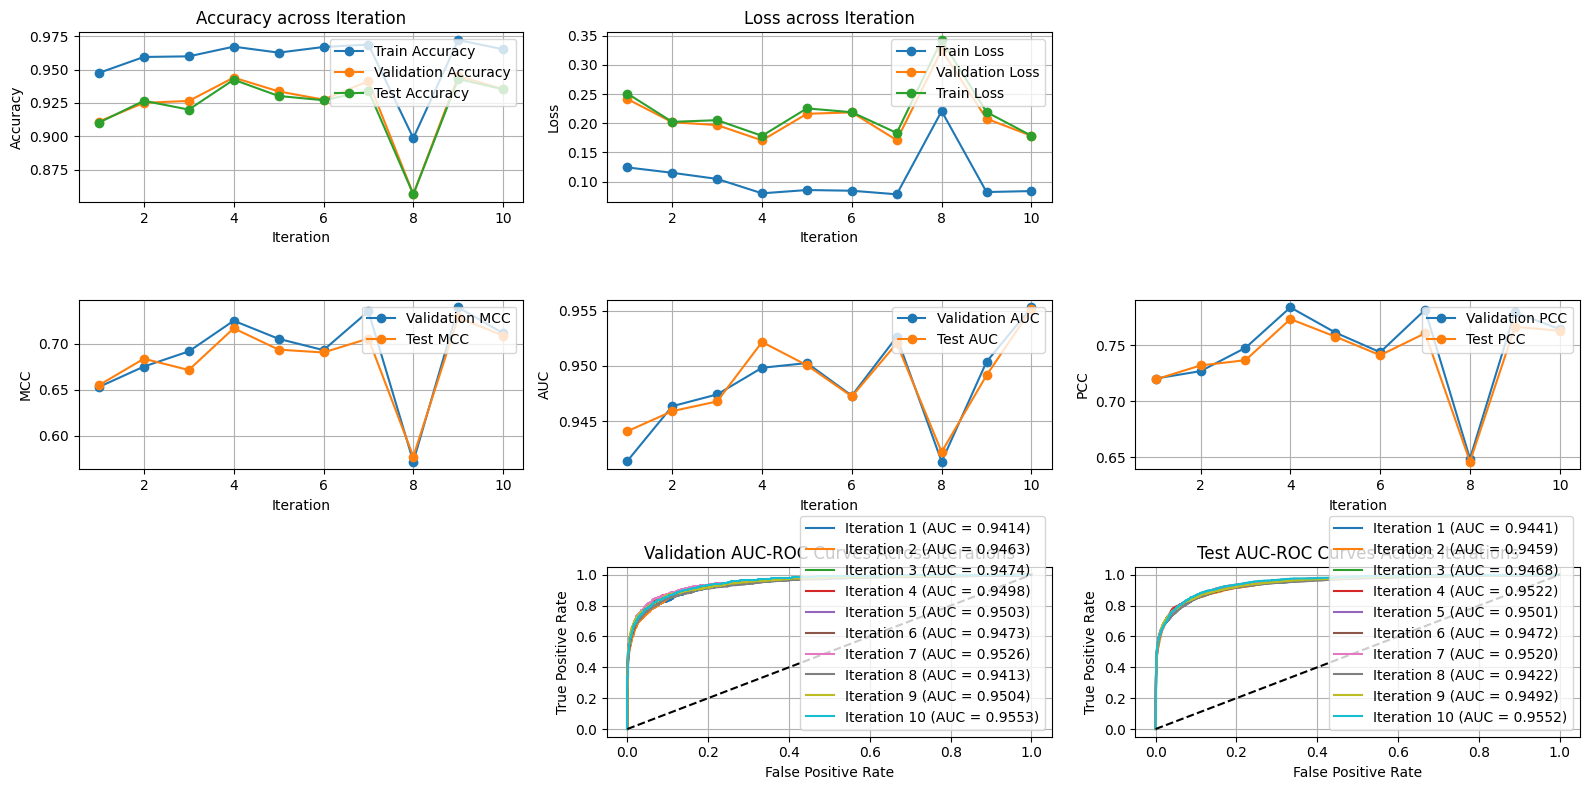

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment6.png')
plt.show()

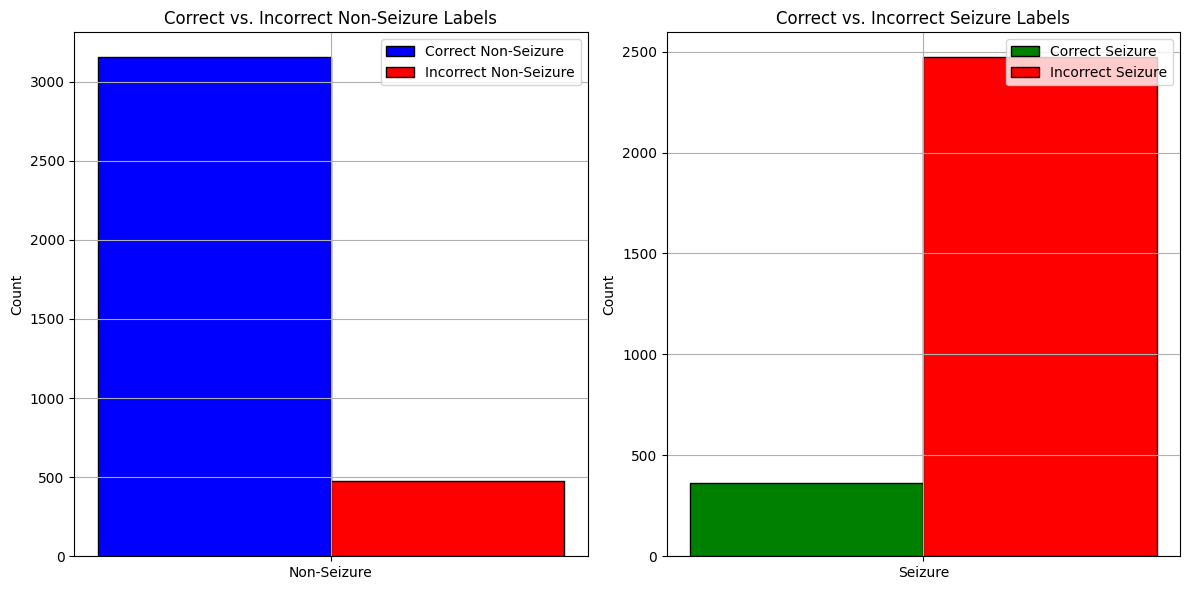

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 7

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_7']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp7.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp7.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp7.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp7.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp7.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 7.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp7.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp7.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Number of confident indices: 1713
Number of confident pseudo-labelled segments = 1713 out of 50271
Percentage of confident pseudo labels = 3.41%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5593 - loss: 0.8326 - val_accuracy: 0.9091 - val_loss: 0.4006
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8194 - loss: 0.4735 - val_accuracy: 0.9190 - val_loss: 0.3738
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8679 - loss: 0.4101 - val_accuracy: 0.9240 - val_loss: 0.3416
Epoch 4/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8919 - loss: 0.3592 - val_accuracy: 0.9260 - val_loss: 0.3216
Epoch 5/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8950 - loss: 0.3476 - val_accuracy: 0.9238 - val_loss: 0.3145
Epoch 6/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9077 - loss: 0.3159 - val_accuracy: 0.9249 - val_loss: 0.2785
Epoch 7/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9120 - loss: 0.2937 - val_accuracy: 0.9305 - val_loss: 0.2537
Epoch 8/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9079 - loss: 0.2849 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |     0.138811 |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6037 - loss: 0.7719 - val_accuracy: 0.9125 - val_loss: 0.3204
Epoch 2/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8620 - loss: 0.4041 - val_accuracy: 0.9158 - val_loss: 0.2984
Epoch 3/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8909 - loss: 0.3524 - val_accuracy: 0.9177 - val_loss: 0.3106
Epoch 4/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9062 - loss: 0.3077 - val_accuracy: 0.9296 - val_loss: 0.2677
Epoch 5/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9083 - loss: 0.2864 - val_accuracy: 0.9131 - val_loss: 0.3212
Epoch 6/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9164 - loss: 0.2668 - val_accuracy: 0.9253 - val_loss: 0.2469
Epoch 7/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9199 - loss: 0.2580 - val_accuracy: 0.9328 - val_loss: 0.2356
Epoch 8/30
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9258 - loss: 0.2369 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5661 - loss: 0.8361 - val_accuracy: 0.8958 - val_loss: 0.3750
Epoch 2/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8322 - loss: 0.4332 - val_accuracy: 0.9119 - val_loss: 0.2949
Epoch 3/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8802 - loss: 0.3571 - val_accuracy: 0.9274 - val_loss: 0.2485
Epoch 4/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9037 - loss: 0.3132 - val_accuracy: 0.9293 - val_loss: 0.2208
Epoch 5/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9122 - loss: 0.2860 - val_accuracy: 0.9232 - val_loss: 0.2497
Epoch 6/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9128 - loss: 0.2752 - val_accuracy: 0.9307 - val_loss: 0.2020
Epoch 7/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9153 - loss: 0.2644 - val_accuracy: 0.9285 - val_loss: 0.2064
Epoch 8/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9272 - loss: 0.2410 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5763 - loss: 0.8107 - val_accuracy: 0.8923 - val_loss: 0.4179
Epoch 2/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8451 - loss: 0.4304 - val_accuracy: 0.9115 - val_loss: 0.3038
Epoch 3/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8812 - loss: 0.3676 - val_accuracy: 0.9251 - val_loss: 0.2769
Epoch 4/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9004 - loss: 0.3076 - val_accuracy: 0.9227 - val_loss: 0.2856
Epoch 5/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9088 - loss: 0.2892 - val_accuracy: 0.9337 - val_loss: 0.2125
Epoch 6/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9122 - loss: 0.2788 - val_accuracy: 0.9322 - val_loss: 0.2148
Epoch 7/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9146 - loss: 0.2625 - val_accuracy: 0.9331 - val_loss: 0.1989
Epoch 8/30
710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9217 - loss: 0.2493 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6044 - loss: 0.7490 - val_accuracy: 0.9099 - val_loss: 0.3617
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8591 - loss: 0.4155 - val_accuracy: 0.9232 - val_loss: 0.3198
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8888 - loss: 0.3476 - val_accuracy: 0.9246 - val_loss: 0.2383
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9099 - loss: 0.3001 - val_accuracy: 0.9308 - val_loss: 0.2276
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9177 - loss: 0.2819 - val_accuracy: 0.9282 - val_loss: 0.2142
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9166 - loss: 0.2667 - val_accuracy: 0.9335 - val_loss: 0.1935
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9272 - loss: 0.2421 - val_accuracy: 0.9311 - val_loss: 0.1954
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9241 - loss: 0.2481 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5490 - loss: 0.8285 - val_accuracy: 0.8613 - val_loss: 0.4716
Epoch 2/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7972 - loss: 0.4696 - val_accuracy: 0.8779 - val_loss: 0.3717
Epoch 3/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8786 - loss: 0.3609 - val_accuracy: 0.9143 - val_loss: 0.2984
Epoch 4/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9018 - loss: 0.3231 - val_accuracy: 0.9250 - val_loss: 0.2600
Epoch 5/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9095 - loss: 0.2997 - val_accuracy: 0.8994 - val_loss: 0.3020
Epoch 6/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9153 - loss: 0.2780 - val_accuracy: 0.9314 - val_loss: 0.2360
Epoch 7/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9131 - loss: 0.2670 - val_accuracy: 0.9121 - val_loss: 0.2586
Epoch 8/30
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9185 - loss: 0.2567 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5702 - loss: 0.7685 - val_accuracy: 0.8932 - val_loss: 0.4544
Epoch 2/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8179 - loss: 0.4617 - val_accuracy: 0.9240 - val_loss: 0.2775
Epoch 3/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8844 - loss: 0.3511 - val_accuracy: 0.9218 - val_loss: 0.2519
Epoch 4/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8964 - loss: 0.3135 - val_accuracy: 0.9307 - val_loss: 0.2276
Epoch 5/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9077 - loss: 0.2982 - val_accuracy: 0.9141 - val_loss: 0.2598
Epoch 6/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9084 - loss: 0.2814 - val_accuracy: 0.9327 - val_loss: 0.2005
Epoch 7/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9194 - loss: 0.2641 - val_accuracy: 0.9306 - val_loss: 0.2046
Epoch 8/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9203 - loss: 0.2451 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5787 - loss: 0.7795 - val_accuracy: 0.8886 - val_loss: 0.4262
Epoch 2/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8029 - loss: 0.5119 - val_accuracy: 0.9038 - val_loss: 0.3055
Epoch 3/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8596 - loss: 0.3947 - val_accuracy: 0.9126 - val_loss: 0.2651
Epoch 4/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8890 - loss: 0.3381 - val_accuracy: 0.8949 - val_loss: 0.2998
Epoch 5/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9017 - loss: 0.3103 - val_accuracy: 0.9251 - val_loss: 0.2222
Epoch 6/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9087 - loss: 0.2928 - val_accuracy: 0.9148 - val_loss: 0.2519
Epoch 7/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9139 - loss: 0.2680 - val_accuracy: 0.9242 - val_loss: 0.2336
Epoch 8/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9153 - loss: 0.2628 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6079 - loss: 0.6852 - val_accuracy: 0.8928 - val_loss: 0.3946
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8226 - loss: 0.4613 - val_accuracy: 0.9205 - val_loss: 0.3266
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8914 - loss: 0.3712 - val_accuracy: 0.8939 - val_loss: 0.3418
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9124 - loss: 0.3205 - val_accuracy: 0.8670 - val_loss: 0.3856
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9112 - loss: 0.3064 - val_accuracy: 0.8651 - val_loss: 0.3660
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9157 - loss: 0.2866 - val_accuracy: 0.9204 - val_loss: 0.2613
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9230 - loss: 0.2728 - val_accuracy: 0.9341 - val_loss: 0.2207
Epoch 8/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9271 - loss: 0.2604 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.939

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5298 - loss: 0.8439 - val_accuracy: 0.8888 - val_loss: 0.4243
Epoch 2/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8078 - loss: 0.4776 - val_accuracy: 0.8821 - val_loss: 0.4126
Epoch 3/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8768 - loss: 0.3882 - val_accuracy: 0.9292 - val_loss: 0.2477
Epoch 4/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8931 - loss: 0.3457 - val_accuracy: 0.9297 - val_loss: 0.2820
Epoch 5/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9017 - loss: 0.3161 - val_accuracy: 0.9216 - val_loss: 0.2565
Epoch 6/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9059 - loss: 0.2978 - val_accuracy: 0.9305 - val_loss: 0.2517
Epoch 7/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9091 - loss: 0.2931 - val_accuracy: 0.9262 - val_loss: 0.2367
Epoch 8/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9112 - loss: 0.2760 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953149 |    0.138811  |              0.920649 |          0.213959 |         0.731342 |         0.669586 |         0.93

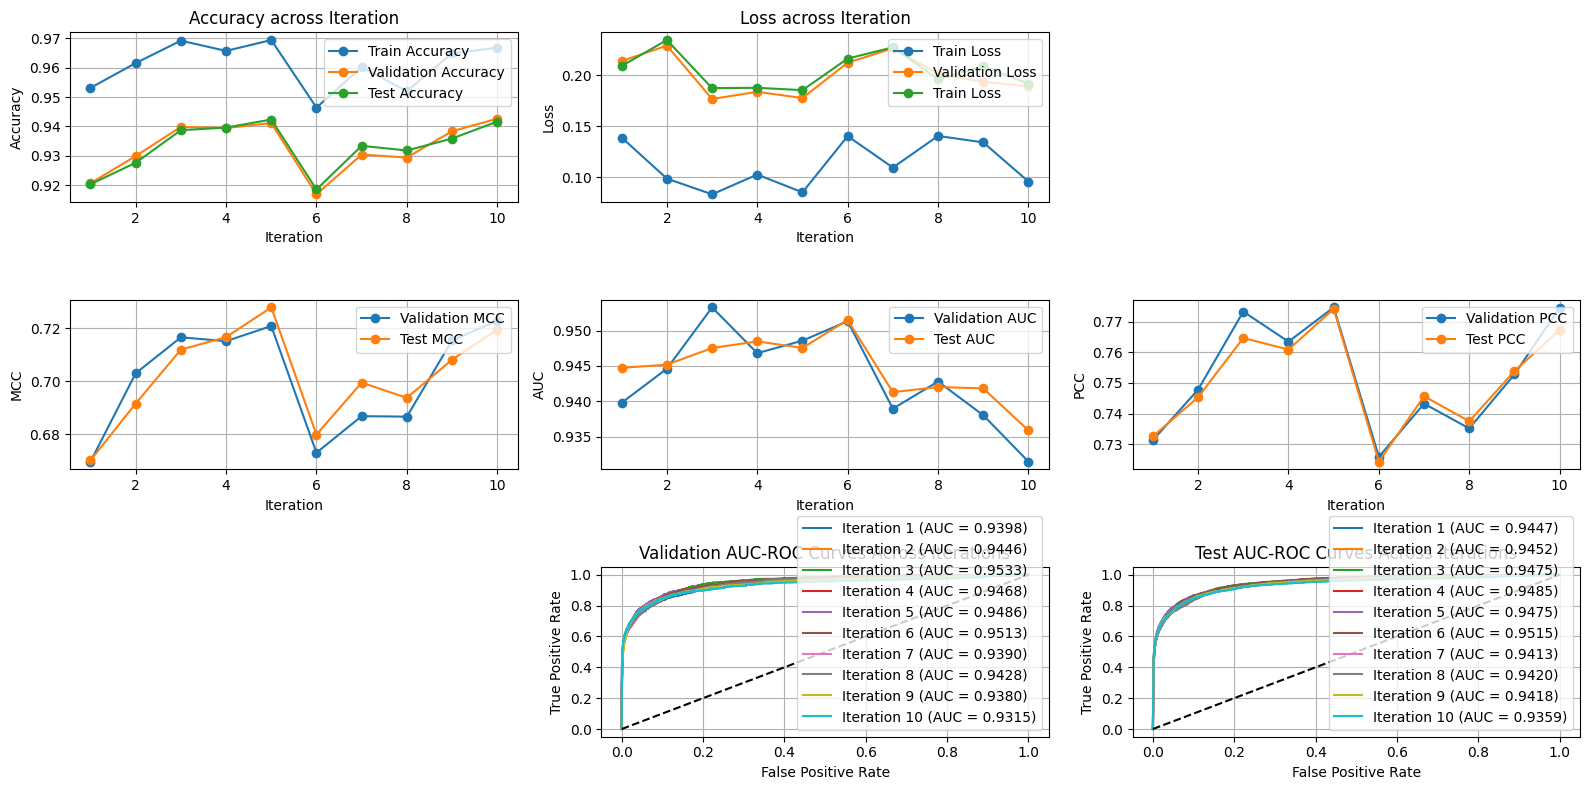

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment7.png')
plt.show()

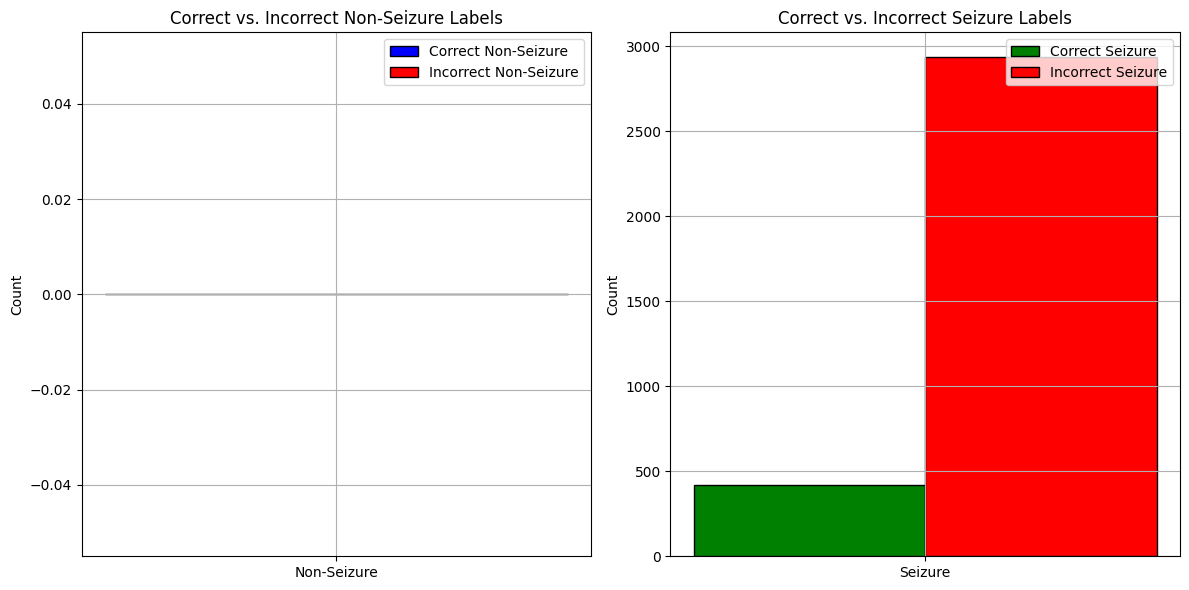

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 8

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_8']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp8.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp8.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp8.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp8.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp8.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 8.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp8.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp8.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step

Number of confident indices: 18082
Number of confident pseudo-labelled segments = 18082 out of 50271
Percentage of confident pseudo labels = 35.97%
Previous shape of training data: (20037, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.5724 - loss: 0.7623 - val_accuracy: 0.4850 - val_loss: 0.7055
Epoch 2/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7079 - loss: 0.5977 - val_accuracy: 0.7900 - val_loss: 0.5197
Epoch 3/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.7734 - loss: 0.5078 - val_accuracy: 0.7389 - val_loss: 0.5091
Epoch 4/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.7971 - loss: 0.4511 - val_accuracy: 0.7541 - val_loss: 0.4823
Epoch 5/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8278 - loss: 0.3978 - val_accuracy: 0.7864 - val_loss: 0.4313
Epoch 6/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8544 - loss: 0.3638 - val_accuracy: 0.8358 - val_loss: 0.3755
Epoch 7/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.8701 - loss: 0.3298 - val_accuracy: 0.7952 - val_loss: 0.4310
Epoch 8/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8773 -

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - accuracy: 0.5409 - loss: 0.7851 - val_accuracy: 0.5489 - val_loss: 0.7614
Epoch 2/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.7734 - loss: 0.5280 - val_accuracy: 0.8481 - val_loss: 0.4457
Epoch 3/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.8418 - loss: 0.4345 - val_accuracy: 0.7279 - val_loss: 0.5770
Epoch 4/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.8439 - loss: 0.4058 - val_accuracy: 0.7664 - val_loss: 0.5348
Epoch 5/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.8640 - loss: 0.3764 - val_accuracy: 0.9105 - val_loss: 0.2932
Epoch 6/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.8736 - loss: 0.3510 - val_accuracy: 0.8736 - val_loss: 0.3411
Epoch 7/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.8760 - loss: 0.3438 - val_accuracy: 0.8683 - val_loss: 0.3317
Epoch 8/30
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.8839 -


augmented_model_v2 saved for iteration 2.
Iteration 2 complete. Test MCC: 0.5530353687513856, Best MCC so far: 0.6341681776824355

Iteration 3
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step

Number of confident indices: 26833
Number of confident pseudo-labelled segments = 26833 out of 50271
Percentage of confident pseudo labels = 53.38%
Previous shape of training data: (53555, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - accuracy: 0.4276 - loss: 0.8986 - val_accuracy: 0.7499 - val_loss: 0.6095
Epoch 2/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.7048 - loss: 0.6160 - val_accuracy: 0.8359 - val_loss: 0.4490
Epoch 3/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 50s 34ms/step - accuracy: 0.8140 - loss: 0.4777 - val_accuracy: 0.8451 - val_loss: 0.3924
Epoch 4/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8425 - loss: 0.4098 - val_accuracy: 0.8927 - val_loss: 0.2833
Epoch 5/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8412 - loss: 0.3682 - val_accuracy: 0.7844 - val_loss: 0.5490
Epoch 6/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8637 - loss: 0.3489 - val_accuracy: 0.8162 - val_loss: 0.4127
Epoch 7/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8656 - loss: 0.3382 - val_accuracy: 0.8673 - val_loss: 0.3512
Epoch 8/30
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8842 -

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.4937 - loss: 0.7630 - val_accuracy: 0.4696 - val_loss: 0.6935
Epoch 2/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.6436 - loss: 0.6280 - val_accuracy: 0.6095 - val_loss: 0.6929
Epoch 3/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8018 - loss: 0.4970 - val_accuracy: 0.8557 - val_loss: 0.3991
Epoch 4/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8333 - loss: 0.4280 - val_accuracy: 0.8189 - val_loss: 0.4373
Epoch 5/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8503 - loss: 0.3836 - val_accuracy: 0.8014 - val_loss: 0.4473
Epoch 6/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8709 - loss: 0.3521 - val_accuracy: 0.8572 - val_loss: 0.3645
Epoch 7/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8831 - loss: 0.3320 - val_accuracy: 0.8204 - val_loss: 0.3990
Epoch 8/30
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8822 -


+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933462 |        0.908258 |    0.272738 

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.6040 - loss: 0.7542 - val_accuracy: 0.5932 - val_loss: 0.6906
Epoch 2/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.7299 - loss: 0.6135 - val_accuracy: 0.8363 - val_loss: 0.4633
Epoch 3/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.8304 - loss: 0.4983 - val_accuracy: 0.8926 - val_loss: 0.3331
Epoch 4/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.8428 - loss: 0.4279 - val_accuracy: 0.9013 - val_loss: 0.2932
Epoch 5/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.8503 - loss: 0.4003 - val_accuracy: 0.8740 - val_loss: 0.3235
Epoch 6/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.8704 - loss: 0.3550 - val_accuracy: 0.8882 - val_loss: 0.3254
Epoch 7/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.8795 - loss: 0.3407 - val_accuracy: 0.8867 - val_loss: 0.3025
Epoch 8/30
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.8818 -

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - accuracy: 0.5597 - loss: 0.8453 - val_accuracy: 0.7218 - val_loss: 0.6083
Epoch 2/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.7415 - loss: 0.5801 - val_accuracy: 0.8018 - val_loss: 0.5019
Epoch 3/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8263 - loss: 0.4929 - val_accuracy: 0.8931 - val_loss: 0.3773
Epoch 4/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8432 - loss: 0.4159 - val_accuracy: 0.8991 - val_loss: 0.3643
Epoch 5/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8679 - loss: 0.3705 - val_accuracy: 0.9052 - val_loss: 0.2978
Epoch 6/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.8784 - loss: 0.3391 - val_accuracy: 0.8440 - val_loss: 0.4065
Epoch 7/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.8748 - loss: 0.3432 - val_accuracy: 0.8836 - val_loss: 0.3164
Epoch 8/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8895 -

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - accuracy: 0.5647 - loss: 0.7334 - val_accuracy: 0.7674 - val_loss: 0.5743
Epoch 2/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.8070 - loss: 0.5461 - val_accuracy: 0.8622 - val_loss: 0.4188
Epoch 3/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.8511 - loss: 0.4350 - val_accuracy: 0.8652 - val_loss: 0.3949
Epoch 4/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.8680 - loss: 0.3906 - val_accuracy: 0.9238 - val_loss: 0.2750
Epoch 5/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.8765 - loss: 0.3781 - val_accuracy: 0.8676 - val_loss: 0.3646
Epoch 6/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.8839 - loss: 0.3427 - val_accuracy: 0.8861 - val_loss: 0.3024
Epoch 7/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.8899 - loss: 0.3023 - val_accuracy: 0.8738 - val_loss: 0.3351
Epoch 8/30
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.8952 -

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 53s 37ms/step - accuracy: 0.5216 - loss: 0.7043 - val_accuracy: 0.6121 - val_loss: 0.6899
Epoch 2/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.7649 - loss: 0.5373 - val_accuracy: 0.4974 - val_loss: 0.9858
Epoch 3/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8343 - loss: 0.4336 - val_accuracy: 0.7741 - val_loss: 0.5137
Epoch 4/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8554 - loss: 0.3924 - val_accuracy: 0.7005 - val_loss: 0.5422
Epoch 5/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8568 - loss: 0.3539 - val_accuracy: 0.6606 - val_loss: 0.6419
Epoch 6/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8652 - loss: 0.3371 - val_accuracy: 0.8059 - val_loss: 0.4250
Epoch 7/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8749 - loss: 0.3181 - val_accuracy: 0.7379 - val_loss: 0.5336
Epoch 8/30
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8839 -

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - accuracy: 0.4761 - loss: 0.8972 - val_accuracy: 0.5056 - val_loss: 0.6940
Epoch 2/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.6664 - loss: 0.6191 - val_accuracy: 0.7621 - val_loss: 0.5915
Epoch 3/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.8384 - loss: 0.4544 - val_accuracy: 0.8105 - val_loss: 0.4850
Epoch 4/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8538 - loss: 0.4181 - val_accuracy: 0.7916 - val_loss: 0.4875
Epoch 5/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8617 - loss: 0.3823 - val_accuracy: 0.8205 - val_loss: 0.3949
Epoch 6/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8640 - loss: 0.3514 - val_accuracy: 0.8043 - val_loss: 0.4188
Epoch 7/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8698 - loss: 0.3247 - val_accuracy: 0.7959 - val_loss: 0.4184
Epoch 8/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8780 -

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.933

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - accuracy: 0.5899 - loss: 0.8115 - val_accuracy: 0.8537 - val_loss: 0.5525
Epoch 2/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.7971 - loss: 0.5169 - val_accuracy: 0.8317 - val_loss: 0.4490
Epoch 3/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8341 - loss: 0.4318 - val_accuracy: 0.8306 - val_loss: 0.4883
Epoch 4/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8405 - loss: 0.3979 - val_accuracy: 0.8853 - val_loss: 0.3383
Epoch 5/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8304 - loss: 0.3856 - val_accuracy: 0.6833 - val_loss: 0.5972
Epoch 6/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.8544 - loss: 0.3525 - val_accuracy: 0.8026 - val_loss: 0.4027
Epoch 7/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8624 - loss: 0.3262 - val_accuracy: 0.9019 - val_loss: 0.2371
Epoch 8/30
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8716 -

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.964348 |    0.0822533 |              0.909697 |          0.279119 |         0.700059 |         0.639566 |         0.93

Iteration 10 complete. Test MCC: 0.6046494819130045, Best MCC so far: 0.6515241944365948
Best model found after 10 iterations with MCC: 0.6515241944365948

aug_model_v10 saved as the best augmented model of experiment 8.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+

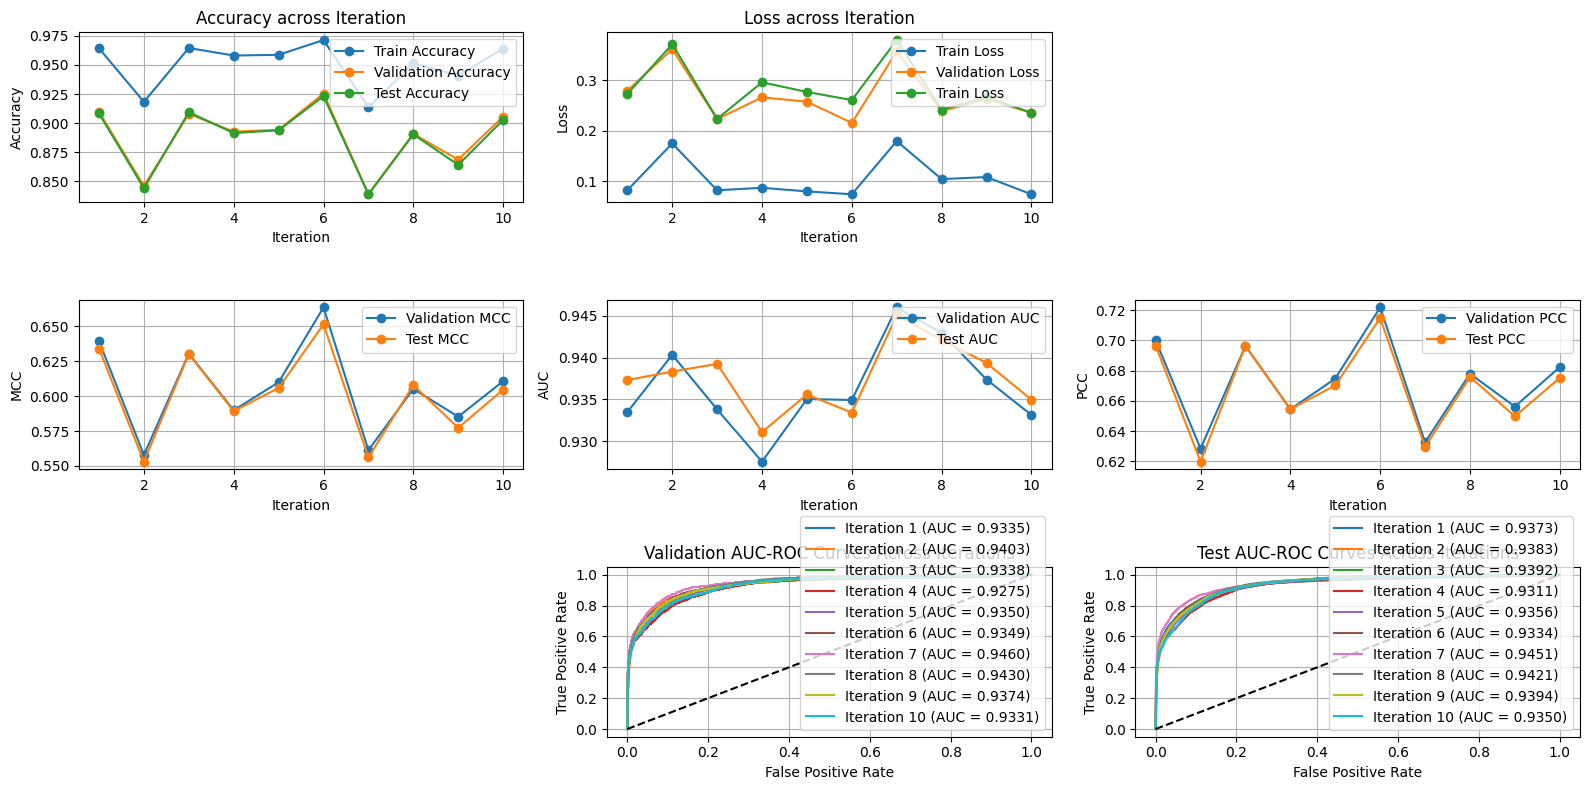

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment8.png')
plt.show()

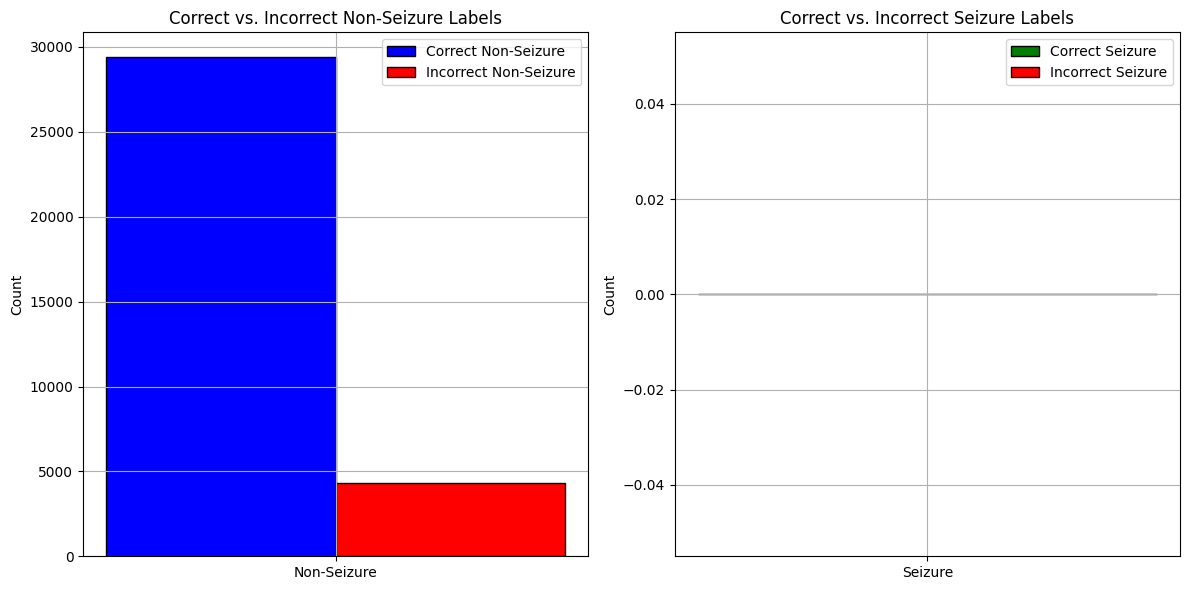

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 9

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_9']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp9.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp9.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp9.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp9.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp9.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 9.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp9.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp9.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Number of confident indices: 100
Number of confident pseudo-labelled segments = 100 out of 50271
Percentage of confident pseudo labels = 0.20%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4885 - loss: 0.8849 - val_accuracy: 0.7595 - val_loss: 0.6593
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6595 - loss: 0.6624 - val_accuracy: 0.8957 - val_loss: 0.5405
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7477 - loss: 0.5773 - val_accuracy: 0.8815 - val_loss: 0.5066
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8122 - loss: 0.5300 - val_accuracy: 0.8782 - val_loss: 0.4371
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8294 - loss: 0.4879 - val_accuracy: 0.9184 - val_loss: 0.3206
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8314 - loss: 0.4561 - val_accuracy: 0.9232 - val_loss: 0.3150
Epoch 7/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8484 - loss: 0.4156 - val_accuracy: 0.9036 - val_loss: 0.3334
Epoch 8/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8592 - loss: 0.3898 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |       0.2412 |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5127 - loss: 0.9663 - val_accuracy: 0.2686 - val_loss: 0.7577
Epoch 2/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5333 - loss: 0.6452 - val_accuracy: 0.6480 - val_loss: 0.6761
Epoch 3/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7747 - loss: 0.5445 - val_accuracy: 0.8706 - val_loss: 0.4207
Epoch 4/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8071 - loss: 0.5093 - val_accuracy: 0.8569 - val_loss: 0.4574
Epoch 5/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8446 - loss: 0.4495 - val_accuracy: 0.9013 - val_loss: 0.3684
Epoch 6/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8485 - loss: 0.4288 - val_accuracy: 0.9161 - val_loss: 0.2896
Epoch 7/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8558 - loss: 0.4108 - val_accuracy: 0.9144 - val_loss: 0.3339
Epoch 8/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8592 - loss: 0.3913 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5615 - loss: 0.7971 - val_accuracy: 0.5776 - val_loss: 0.6964
Epoch 2/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7331 - loss: 0.6408 - val_accuracy: 0.8003 - val_loss: 0.5473
Epoch 3/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8098 - loss: 0.5440 - val_accuracy: 0.8363 - val_loss: 0.4882
Epoch 4/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8307 - loss: 0.5007 - val_accuracy: 0.8802 - val_loss: 0.4120
Epoch 5/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8408 - loss: 0.4613 - val_accuracy: 0.9079 - val_loss: 0.3649
Epoch 6/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8468 - loss: 0.4386 - val_accuracy: 0.9115 - val_loss: 0.3106
Epoch 7/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8426 - loss: 0.4154 - val_accuracy: 0.9150 - val_loss: 0.2946
Epoch 8/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8514 - loss: 0.3960 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5040 - loss: 0.7967 - val_accuracy: 0.8602 - val_loss: 0.5875
Epoch 2/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7502 - loss: 0.6128 - val_accuracy: 0.9004 - val_loss: 0.3890
Epoch 3/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8270 - loss: 0.5354 - val_accuracy: 0.8859 - val_loss: 0.4317
Epoch 4/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8468 - loss: 0.4715 - val_accuracy: 0.8770 - val_loss: 0.4069
Epoch 5/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8505 - loss: 0.4586 - val_accuracy: 0.9054 - val_loss: 0.3658
Epoch 6/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8599 - loss: 0.4122 - val_accuracy: 0.9116 - val_loss: 0.2848
Epoch 7/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8532 - loss: 0.4102 - val_accuracy: 0.9117 - val_loss: 0.2933
Epoch 8/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8539 - loss: 0.3759 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5288 - loss: 1.1439 - val_accuracy: 0.3933 - val_loss: 0.6949
Epoch 2/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5389 - loss: 0.6772 - val_accuracy: 0.6990 - val_loss: 0.6593
Epoch 3/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7004 - loss: 0.5798 - val_accuracy: 0.7659 - val_loss: 0.5917
Epoch 4/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8057 - loss: 0.4999 - val_accuracy: 0.9133 - val_loss: 0.3820
Epoch 5/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8356 - loss: 0.4356 - val_accuracy: 0.8975 - val_loss: 0.4183
Epoch 6/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8449 - loss: 0.4070 - val_accuracy: 0.9095 - val_loss: 0.3806
Epoch 7/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8620 - loss: 0.3740 - val_accuracy: 0.8725 - val_loss: 0.3986
Epoch 8/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8538 - loss: 0.3651 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5171 - loss: 0.8458 - val_accuracy: 0.7416 - val_loss: 0.6146
Epoch 2/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6638 - loss: 0.6043 - val_accuracy: 0.8985 - val_loss: 0.4011
Epoch 3/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8040 - loss: 0.4805 - val_accuracy: 0.8408 - val_loss: 0.4618
Epoch 4/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8525 - loss: 0.4260 - val_accuracy: 0.9182 - val_loss: 0.3109
Epoch 5/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8719 - loss: 0.3862 - val_accuracy: 0.9197 - val_loss: 0.2897
Epoch 6/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8729 - loss: 0.3709 - val_accuracy: 0.8548 - val_loss: 0.3968
Epoch 7/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8692 - loss: 0.3606 - val_accuracy: 0.8865 - val_loss: 0.3053
Epoch 8/30
645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8668 - loss: 0.3408 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5065 - loss: 0.8350 - val_accuracy: 0.5422 - val_loss: 0.6981
Epoch 2/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6325 - loss: 0.6448 - val_accuracy: 0.7939 - val_loss: 0.5480
Epoch 3/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7966 - loss: 0.5378 - val_accuracy: 0.8908 - val_loss: 0.4336
Epoch 4/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8349 - loss: 0.4647 - val_accuracy: 0.9082 - val_loss: 0.3489
Epoch 5/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8484 - loss: 0.4243 - val_accuracy: 0.9068 - val_loss: 0.3298
Epoch 6/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8659 - loss: 0.3935 - val_accuracy: 0.9170 - val_loss: 0.3092
Epoch 7/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8731 - loss: 0.3740 - val_accuracy: 0.8930 - val_loss: 0.3180
Epoch 8/30
649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8794 - loss: 0.3429 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.4986 - loss: 0.8835 - val_accuracy: 0.6889 - val_loss: 0.6442
Epoch 2/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6957 - loss: 0.5869 - val_accuracy: 0.8487 - val_loss: 0.4942
Epoch 3/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8341 - loss: 0.4712 - val_accuracy: 0.8908 - val_loss: 0.3653
Epoch 4/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8506 - loss: 0.4301 - val_accuracy: 0.9035 - val_loss: 0.3573
Epoch 5/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8537 - loss: 0.4139 - val_accuracy: 0.8847 - val_loss: 0.3519
Epoch 6/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8631 - loss: 0.3811 - val_accuracy: 0.8208 - val_loss: 0.4259
Epoch 7/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8593 - loss: 0.3679 - val_accuracy: 0.9058 - val_loss: 0.2845
Epoch 8/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8697 - loss: 0.3402 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5407 - loss: 0.8843 - val_accuracy: 0.8886 - val_loss: 0.4515
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7491 - loss: 0.5661 - val_accuracy: 0.9152 - val_loss: 0.3643
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8292 - loss: 0.4645 - val_accuracy: 0.8647 - val_loss: 0.4232
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8481 - loss: 0.4244 - val_accuracy: 0.9145 - val_loss: 0.3404
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8548 - loss: 0.3997 - val_accuracy: 0.8677 - val_loss: 0.3693
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8569 - loss: 0.3740 - val_accuracy: 0.9070 - val_loss: 0.2822
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8629 - loss: 0.3641 - val_accuracy: 0.9251 - val_loss: 0.2383
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8684 - loss: 0.3490 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5611 - loss: 0.7903 - val_accuracy: 0.7758 - val_loss: 0.6617
Epoch 2/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6855 - loss: 0.6085 - val_accuracy: 0.7968 - val_loss: 0.5333
Epoch 3/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8111 - loss: 0.4925 - val_accuracy: 0.9033 - val_loss: 0.3809
Epoch 4/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8472 - loss: 0.4403 - val_accuracy: 0.8578 - val_loss: 0.4633
Epoch 5/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8690 - loss: 0.4005 - val_accuracy: 0.8971 - val_loss: 0.3758
Epoch 6/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8731 - loss: 0.3832 - val_accuracy: 0.9285 - val_loss: 0.2933
Epoch 7/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8807 - loss: 0.3557 - val_accuracy: 0.9113 - val_loss: 0.3107
Epoch 8/30
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8814 - loss: 0.3568 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                 100 |         0.898495 |     0.2412   |              0.869176 |          0.299811 |         0.648289 |         0.584804 |         0.94

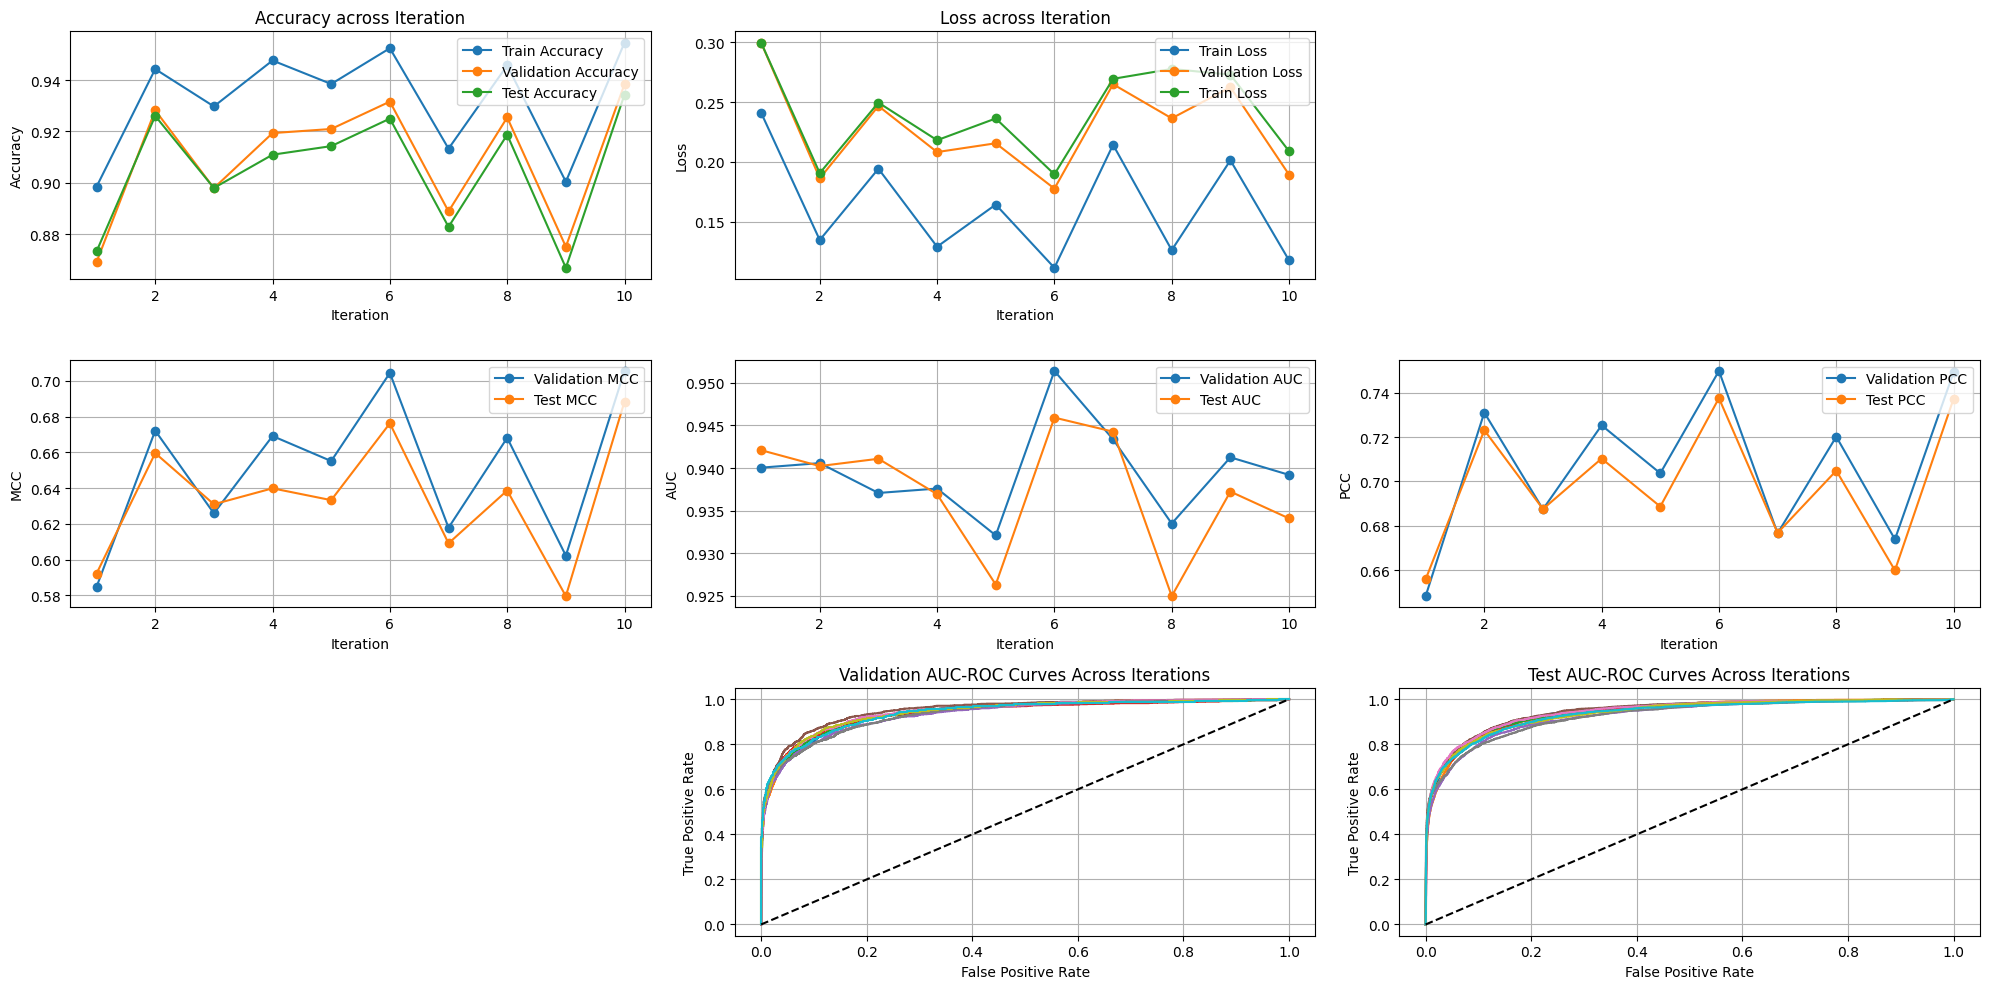

In [ ]:
#plots
#metrics_df = pd.read_csv(f'Performance_Metrics_Exp9.csv')
plt.figure(figsize=(20, 10))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

#plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

#diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment9.png')
plt.show()

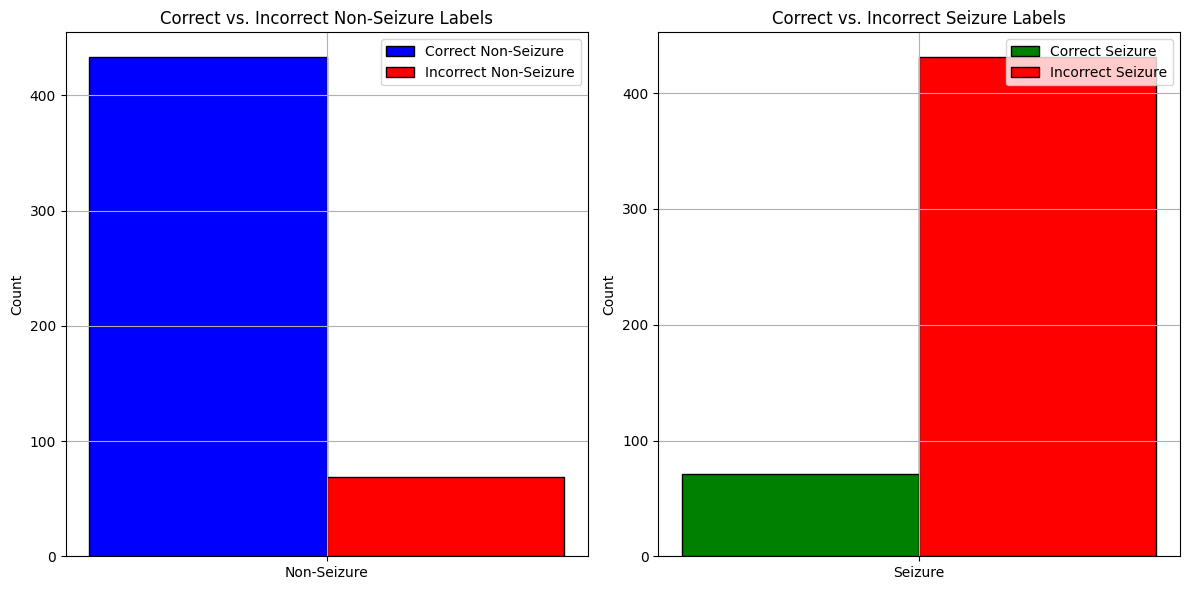

In [ ]:
#pseudo_labelled_segments = pd.read_csv(f'Pseudo_Labels_Exp9.csv')

#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 10

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_10']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp10.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp10.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp10.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp10.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp10.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 10.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp10.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp10.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Number of confident indices: 50
Number of confident pseudo-labelled segments = 50 out of 50271
Percentage of confident pseudo labels = 0.10%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5175 - loss: 0.8419 - val_accuracy: 0.5115 - val_loss: 0.6868
Epoch 2/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5761 - loss: 0.6621 - val_accuracy: 0.8944 - val_loss: 0.5444
Epoch 3/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7183 - loss: 0.5968 - val_accuracy: 0.8595 - val_loss: 0.5237
Epoch 4/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7947 - loss: 0.5019 - val_accuracy: 0.8467 - val_loss: 0.5064
Epoch 5/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8179 - loss: 0.4691 - val_accuracy: 0.8873 - val_loss: 0.4370
Epoch 6/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8214 - loss: 0.4397 - val_accuracy: 0.9155 - val_loss: 0.3954
Epoch 7/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8449 - loss: 0.4197 - val_accuracy: 0.8761 - val_loss: 0.3976
Epoch 8/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8424 - loss: 0.3925 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5191 - loss: 0.7568 - val_accuracy: 0.6324 - val_loss: 0.6523
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6156 - loss: 0.6502 - val_accuracy: 0.8273 - val_loss: 0.5586
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7537 - loss: 0.5703 - val_accuracy: 0.9062 - val_loss: 0.4244
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8064 - loss: 0.5095 - val_accuracy: 0.8773 - val_loss: 0.4075
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8297 - loss: 0.4626 - val_accuracy: 0.9045 - val_loss: 0.3472
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8478 - loss: 0.4306 - val_accuracy: 0.8475 - val_loss: 0.4194
Epoch 7/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8428 - loss: 0.4285 - val_accuracy: 0.8456 - val_loss: 0.4601
Epoch 8/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8493 - loss: 0.4060 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5193 - loss: 0.8255 - val_accuracy: 0.6915 - val_loss: 0.6225
Epoch 2/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7048 - loss: 0.5788 - val_accuracy: 0.7877 - val_loss: 0.5022
Epoch 3/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7904 - loss: 0.4939 - val_accuracy: 0.8676 - val_loss: 0.3630
Epoch 4/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8138 - loss: 0.4504 - val_accuracy: 0.8118 - val_loss: 0.4576
Epoch 5/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8370 - loss: 0.4170 - val_accuracy: 0.9009 - val_loss: 0.3183
Epoch 6/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8559 - loss: 0.3814 - val_accuracy: 0.8760 - val_loss: 0.3350
Epoch 7/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8503 - loss: 0.3656 - val_accuracy: 0.8815 - val_loss: 0.3166
Epoch 8/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8552 - loss: 0.3503 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.4876 - loss: 0.7986 - val_accuracy: 0.8101 - val_loss: 0.5694
Epoch 2/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7439 - loss: 0.5862 - val_accuracy: 0.8530 - val_loss: 0.4226
Epoch 3/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8238 - loss: 0.4829 - val_accuracy: 0.9079 - val_loss: 0.3237
Epoch 4/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8467 - loss: 0.4401 - val_accuracy: 0.9175 - val_loss: 0.2659
Epoch 5/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8597 - loss: 0.4098 - val_accuracy: 0.9124 - val_loss: 0.2675
Epoch 6/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8583 - loss: 0.3895 - val_accuracy: 0.9261 - val_loss: 0.2604
Epoch 7/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8702 - loss: 0.3634 - val_accuracy: 0.9226 - val_loss: 0.2442
Epoch 8/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8706 - loss: 0.3394 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4684 - loss: 0.7634 - val_accuracy: 0.2989 - val_loss: 0.6929
Epoch 2/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4566 - loss: 0.6620 - val_accuracy: 0.8331 - val_loss: 0.5379
Epoch 3/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6737 - loss: 0.6045 - val_accuracy: 0.8807 - val_loss: 0.4666
Epoch 4/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7438 - loss: 0.5397 - val_accuracy: 0.9047 - val_loss: 0.4138
Epoch 5/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7885 - loss: 0.4827 - val_accuracy: 0.8966 - val_loss: 0.3853
Epoch 6/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8033 - loss: 0.4395 - val_accuracy: 0.8216 - val_loss: 0.4362
Epoch 7/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8136 - loss: 0.4313 - val_accuracy: 0.8903 - val_loss: 0.3800
Epoch 8/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8428 - loss: 0.3919 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5146 - loss: 0.7750 - val_accuracy: 0.4211 - val_loss: 0.6940
Epoch 2/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6636 - loss: 0.6457 - val_accuracy: 0.8742 - val_loss: 0.4800
Epoch 3/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8082 - loss: 0.5163 - val_accuracy: 0.9095 - val_loss: 0.4207
Epoch 4/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8356 - loss: 0.4519 - val_accuracy: 0.8814 - val_loss: 0.3594
Epoch 5/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8453 - loss: 0.4167 - val_accuracy: 0.9088 - val_loss: 0.3494
Epoch 6/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8564 - loss: 0.3906 - val_accuracy: 0.9129 - val_loss: 0.2792
Epoch 7/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8621 - loss: 0.3773 - val_accuracy: 0.8985 - val_loss: 0.2829
Epoch 8/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8689 - loss: 0.3472 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5438 - loss: 0.9649 - val_accuracy: 0.8116 - val_loss: 0.6156
Epoch 2/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7014 - loss: 0.6028 - val_accuracy: 0.8091 - val_loss: 0.5524
Epoch 3/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8315 - loss: 0.4980 - val_accuracy: 0.9111 - val_loss: 0.3509
Epoch 4/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8582 - loss: 0.4296 - val_accuracy: 0.8865 - val_loss: 0.4084
Epoch 5/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8660 - loss: 0.3949 - val_accuracy: 0.9225 - val_loss: 0.3043
Epoch 6/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8717 - loss: 0.3847 - val_accuracy: 0.8133 - val_loss: 0.4347
Epoch 7/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8688 - loss: 0.3672 - val_accuracy: 0.8655 - val_loss: 0.3313
Epoch 8/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8705 - loss: 0.3486 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5501 - loss: 0.7750 - val_accuracy: 0.8673 - val_loss: 0.5139
Epoch 2/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7679 - loss: 0.5637 - val_accuracy: 0.8906 - val_loss: 0.4057
Epoch 3/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8332 - loss: 0.4596 - val_accuracy: 0.8822 - val_loss: 0.3878
Epoch 4/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8511 - loss: 0.4346 - val_accuracy: 0.9119 - val_loss: 0.3372
Epoch 5/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8595 - loss: 0.4081 - val_accuracy: 0.9248 - val_loss: 0.2699
Epoch 6/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8674 - loss: 0.3738 - val_accuracy: 0.9133 - val_loss: 0.2836
Epoch 7/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8666 - loss: 0.3708 - val_accuracy: 0.8867 - val_loss: 0.3236
Epoch 8/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8761 - loss: 0.3388 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5256 - loss: 0.7352 - val_accuracy: 0.8473 - val_loss: 0.5850
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7700 - loss: 0.5653 - val_accuracy: 0.8403 - val_loss: 0.4608
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8101 - loss: 0.4903 - val_accuracy: 0.8865 - val_loss: 0.3905
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8237 - loss: 0.4540 - val_accuracy: 0.8498 - val_loss: 0.4153
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8355 - loss: 0.4232 - val_accuracy: 0.9199 - val_loss: 0.3096
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8428 - loss: 0.4083 - val_accuracy: 0.9198 - val_loss: 0.2763
Epoch 7/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8534 - loss: 0.3811 - val_accuracy: 0.9176 - val_loss: 0.2717
Epoch 8/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8594 - loss: 0.3499 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.942

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5092 - loss: 0.9442 - val_accuracy: 0.7397 - val_loss: 0.6403
Epoch 2/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6515 - loss: 0.6325 - val_accuracy: 0.8987 - val_loss: 0.4447
Epoch 3/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8103 - loss: 0.4932 - val_accuracy: 0.8997 - val_loss: 0.3998
Epoch 4/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8347 - loss: 0.4465 - val_accuracy: 0.8753 - val_loss: 0.4550
Epoch 5/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8479 - loss: 0.4099 - val_accuracy: 0.8642 - val_loss: 0.4131
Epoch 6/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8556 - loss: 0.3921 - val_accuracy: 0.8615 - val_loss: 0.4257
Epoch 7/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8577 - loss: 0.3793 - val_accuracy: 0.8802 - val_loss: 0.3708
Epoch 8/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8678 - loss: 0.3412 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.927963 |     0.155712 |              0.898546 |          0.224784 |         0.707256 |         0.637863 |         0.94

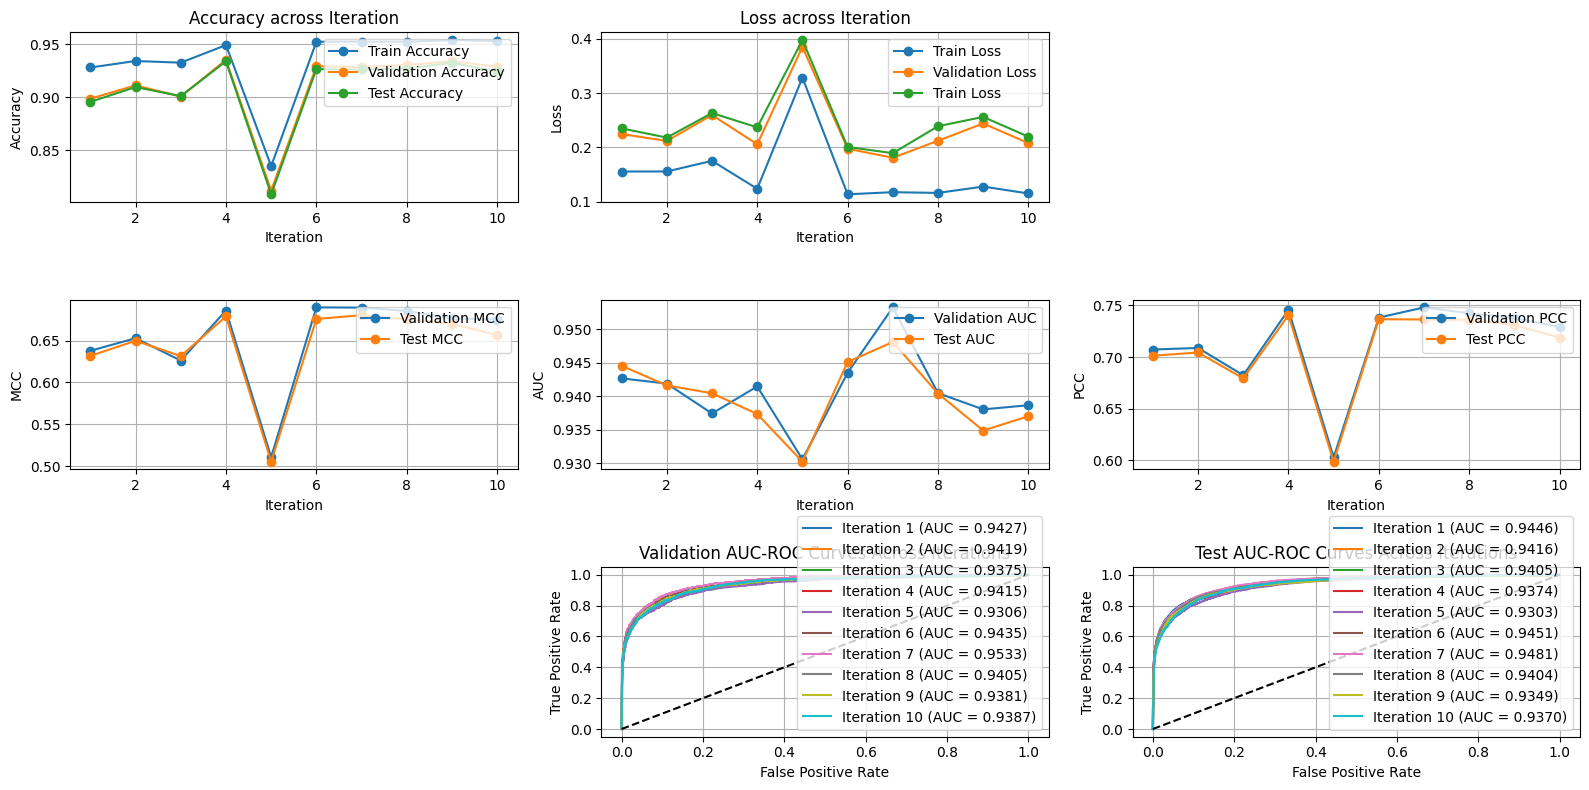

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment10.png')
plt.show()

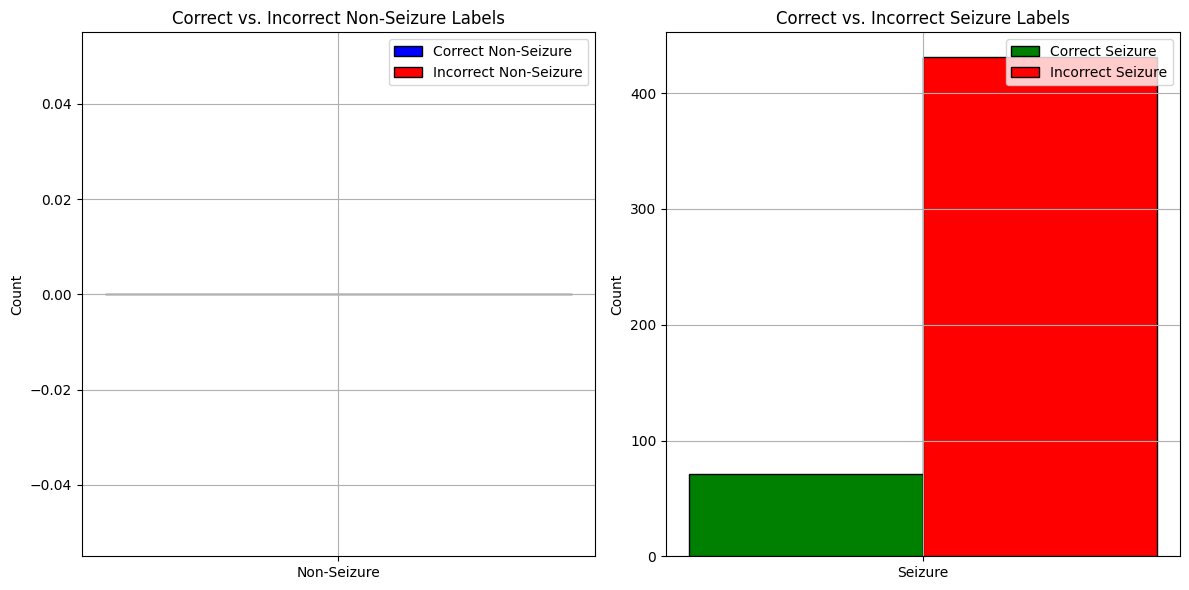

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 11

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_11']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp11.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp11.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp11.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp11.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp11.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 11.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp11.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp11.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Number of confident indices: 50
Number of confident pseudo-labelled segments = 50 out of 50271
Percentage of confident pseudo labels = 0.10%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.4999 - loss: 0.8703 - val_accuracy: 0.6425 - val_loss: 0.6613
Epoch 2/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5524 - loss: 0.6589 - val_accuracy: 0.8134 - val_loss: 0.6121
Epoch 3/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6991 - loss: 0.6094 - val_accuracy: 0.8023 - val_loss: 0.5530
Epoch 4/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7243 - loss: 0.5780 - val_accuracy: 0.5887 - val_loss: 0.6900
Epoch 5/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7573 - loss: 0.5421 - val_accuracy: 0.8741 - val_loss: 0.5069
Epoch 6/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7934 - loss: 0.5007 - val_accuracy: 0.8943 - val_loss: 0.4354
Epoch 7/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7914 - loss: 0.4848 - val_accuracy: 0.8974 - val_loss: 0.4217
Epoch 8/30
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8093 - loss: 0.4436 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5229 - loss: 0.7608 - val_accuracy: 0.2810 - val_loss: 0.7019
Epoch 2/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5375 - loss: 0.6669 - val_accuracy: 0.8692 - val_loss: 0.6300
Epoch 3/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7067 - loss: 0.5974 - val_accuracy: 0.8887 - val_loss: 0.5217
Epoch 4/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7569 - loss: 0.5306 - val_accuracy: 0.9096 - val_loss: 0.3461
Epoch 5/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7978 - loss: 0.4700 - val_accuracy: 0.9188 - val_loss: 0.3415
Epoch 6/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8221 - loss: 0.4271 - val_accuracy: 0.8633 - val_loss: 0.4092
Epoch 7/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8355 - loss: 0.4024 - val_accuracy: 0.8646 - val_loss: 0.3825
Epoch 8/30
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8388 - loss: 0.3877 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5257 - loss: 0.8467 - val_accuracy: 0.4272 - val_loss: 0.7352
Epoch 2/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6832 - loss: 0.6237 - val_accuracy: 0.6124 - val_loss: 0.6457
Epoch 3/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7712 - loss: 0.5364 - val_accuracy: 0.8757 - val_loss: 0.4192
Epoch 4/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8267 - loss: 0.4737 - val_accuracy: 0.9029 - val_loss: 0.3498
Epoch 5/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8324 - loss: 0.4524 - val_accuracy: 0.7896 - val_loss: 0.4775
Epoch 6/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8356 - loss: 0.4201 - val_accuracy: 0.8473 - val_loss: 0.4443
Epoch 7/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8325 - loss: 0.4041 - val_accuracy: 0.8884 - val_loss: 0.3152
Epoch 8/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8468 - loss: 0.3819 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.4285 - loss: 0.8296 - val_accuracy: 0.2514 - val_loss: 0.7173
Epoch 2/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5855 - loss: 0.6770 - val_accuracy: 0.7208 - val_loss: 0.6585
Epoch 3/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7719 - loss: 0.6123 - val_accuracy: 0.8955 - val_loss: 0.4799
Epoch 4/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8072 - loss: 0.5349 - val_accuracy: 0.8996 - val_loss: 0.3741
Epoch 5/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8288 - loss: 0.4718 - val_accuracy: 0.9160 - val_loss: 0.3570
Epoch 6/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8486 - loss: 0.4327 - val_accuracy: 0.8488 - val_loss: 0.4006
Epoch 7/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8513 - loss: 0.4164 - val_accuracy: 0.8760 - val_loss: 0.3676
Epoch 8/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8514 - loss: 0.3911 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4774 - loss: 0.7713 - val_accuracy: 0.1680 - val_loss: 0.7248
Epoch 2/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3297 - loss: 0.6808 - val_accuracy: 0.2528 - val_loss: 0.7538
Epoch 3/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4186 - loss: 0.6646 - val_accuracy: 0.3594 - val_loss: 0.7172
Epoch 4/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6177 - loss: 0.6246 - val_accuracy: 0.8455 - val_loss: 0.5067
Epoch 5/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7754 - loss: 0.5424 - val_accuracy: 0.8752 - val_loss: 0.4715
Epoch 6/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8088 - loss: 0.4944 - val_accuracy: 0.8988 - val_loss: 0.3955
Epoch 7/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8356 - loss: 0.4627 - val_accuracy: 0.8578 - val_loss: 0.4482
Epoch 8/30
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8386 - loss: 0.4279 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5232 - loss: 0.8031 - val_accuracy: 0.8153 - val_loss: 0.6527
Epoch 2/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5176 - loss: 0.6810 - val_accuracy: 0.8470 - val_loss: 0.6000
Epoch 3/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6948 - loss: 0.6161 - val_accuracy: 0.8971 - val_loss: 0.4488
Epoch 4/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7854 - loss: 0.5404 - val_accuracy: 0.8258 - val_loss: 0.5019
Epoch 5/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8077 - loss: 0.4871 - val_accuracy: 0.9037 - val_loss: 0.3414
Epoch 6/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8199 - loss: 0.4540 - val_accuracy: 0.8724 - val_loss: 0.3890
Epoch 7/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8523 - loss: 0.4235 - val_accuracy: 0.7729 - val_loss: 0.4824
Epoch 8/30
636/636 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8377 - loss: 0.4027 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5189 - loss: 0.9564 - val_accuracy: 0.5600 - val_loss: 0.6777
Epoch 2/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6839 - loss: 0.6397 - val_accuracy: 0.7217 - val_loss: 0.6425
Epoch 3/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7784 - loss: 0.5615 - val_accuracy: 0.6313 - val_loss: 0.6676
Epoch 4/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8245 - loss: 0.4999 - val_accuracy: 0.8468 - val_loss: 0.4773
Epoch 5/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8287 - loss: 0.4473 - val_accuracy: 0.7350 - val_loss: 0.5307
Epoch 6/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8331 - loss: 0.4283 - val_accuracy: 0.8403 - val_loss: 0.4502
Epoch 7/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8474 - loss: 0.4003 - val_accuracy: 0.9076 - val_loss: 0.3557
Epoch 8/30
638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8562 - loss: 0.3831 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5503 - loss: 0.7826 - val_accuracy: 0.7368 - val_loss: 0.6596
Epoch 2/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7252 - loss: 0.6286 - val_accuracy: 0.8568 - val_loss: 0.5327
Epoch 3/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8121 - loss: 0.5352 - val_accuracy: 0.8944 - val_loss: 0.4213
Epoch 4/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8284 - loss: 0.4793 - val_accuracy: 0.8727 - val_loss: 0.4209
Epoch 5/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8319 - loss: 0.4530 - val_accuracy: 0.9010 - val_loss: 0.3519
Epoch 6/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8329 - loss: 0.4254 - val_accuracy: 0.8465 - val_loss: 0.4080
Epoch 7/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8424 - loss: 0.4017 - val_accuracy: 0.8390 - val_loss: 0.3981
Epoch 8/30
639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8466 - loss: 0.3866 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4583 - loss: 0.7498 - val_accuracy: 0.8176 - val_loss: 0.5847
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7064 - loss: 0.6044 - val_accuracy: 0.8494 - val_loss: 0.4867
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7658 - loss: 0.5410 - val_accuracy: 0.8964 - val_loss: 0.3933
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7920 - loss: 0.4911 - val_accuracy: 0.9032 - val_loss: 0.3343
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8111 - loss: 0.4410 - val_accuracy: 0.8781 - val_loss: 0.3760
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8293 - loss: 0.4231 - val_accuracy: 0.8632 - val_loss: 0.3679
Epoch 7/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8347 - loss: 0.3972 - val_accuracy: 0.9080 - val_loss: 0.3069
Epoch 8/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8503 - loss: 0.3854 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.934

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.4829 - loss: 0.9164 - val_accuracy: 0.2278 - val_loss: 0.7442
Epoch 2/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5006 - loss: 0.6756 - val_accuracy: 0.4483 - val_loss: 0.7341
Epoch 3/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7281 - loss: 0.5956 - val_accuracy: 0.6356 - val_loss: 0.6936
Epoch 4/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8218 - loss: 0.5146 - val_accuracy: 0.7742 - val_loss: 0.5621
Epoch 5/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8302 - loss: 0.4656 - val_accuracy: 0.7457 - val_loss: 0.5428
Epoch 6/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8349 - loss: 0.4451 - val_accuracy: 0.7849 - val_loss: 0.4557
Epoch 7/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8493 - loss: 0.4316 - val_accuracy: 0.7373 - val_loss: 0.4985
Epoch 8/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8451 - loss: 0.4116 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                  50 |         0.928262 |     0.188772 |              0.905814 |          0.233253 |         0.698424 |         0.632645 |         0.93

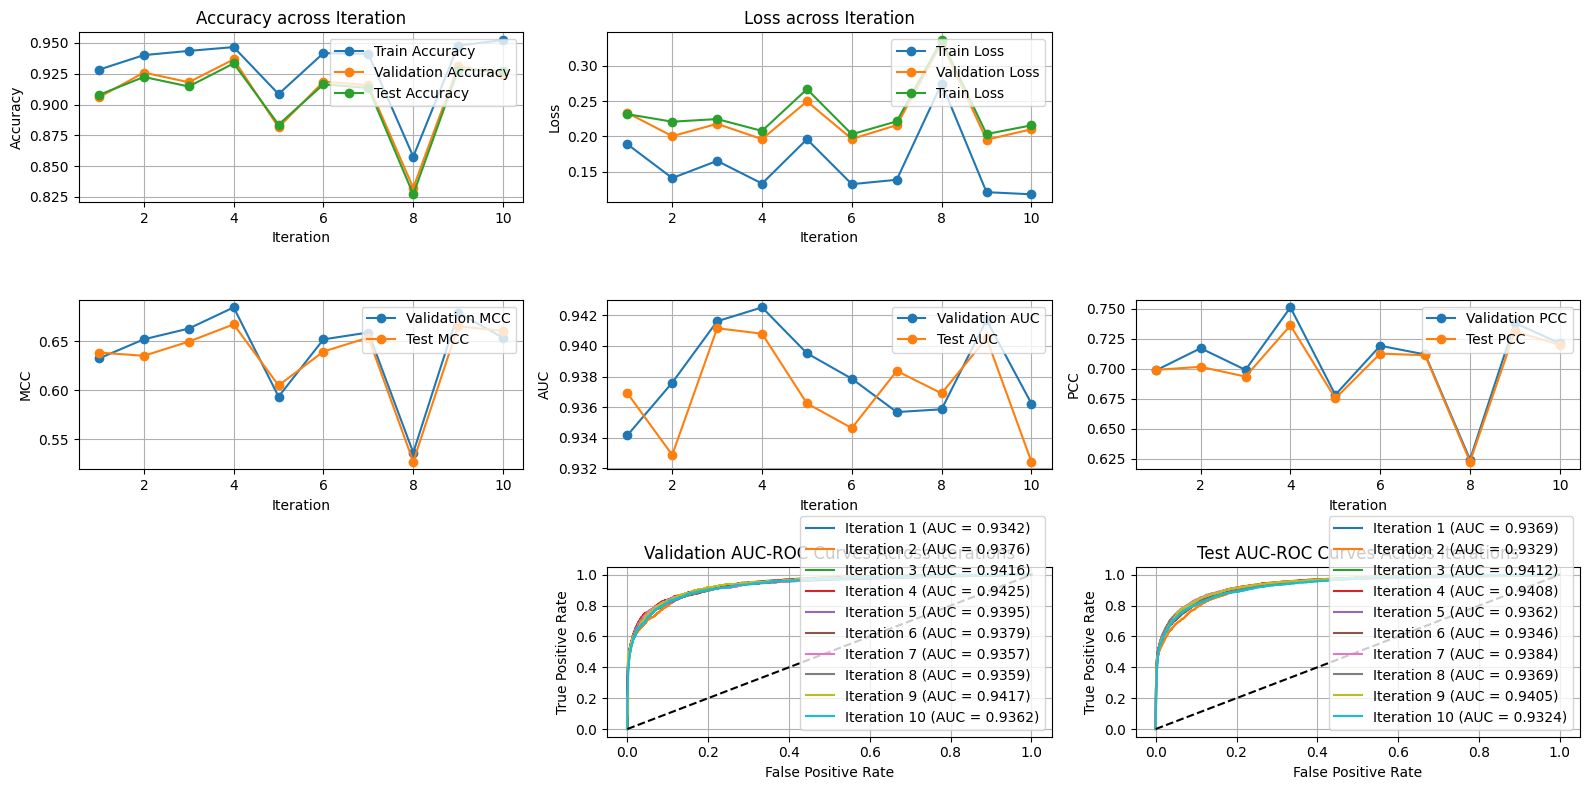

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment11.png')
plt.show()

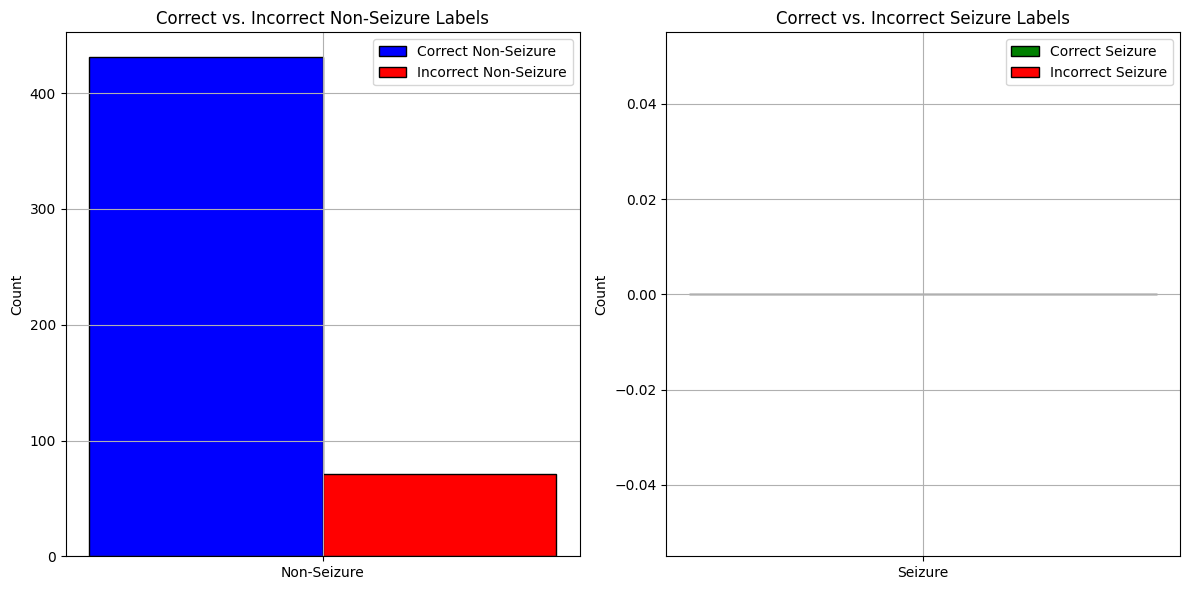

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Comparison Between The Experiments

In [ ]:
#load the models

base_model = tf.keras.models.load_model('base_model.h5')
ideal_model = tf.keras.models.load_model('ideal_model.h5')

aug_model = {}

#loading the final iteration model instead of the best model
for i in range(1, 12):

    aug_model[i] = tf.keras.models.load_model(f'AugModel_v10_Exp{i}.h5')


Evaluation of Base Model
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8895 - loss: 0.2637
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Ideal Model
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9439 - loss: 0.1573
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 1 - Conf Thresh, add both, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9362 - loss: 0.1978
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 2 - Conf Thresh, add both equally, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8677 - loss: 0.3283
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 3 - Conf Thresh, add only seizures, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9358 - loss: 0.2728
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 4 - Conf Thresh, add only non-seizures, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.2757
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3m

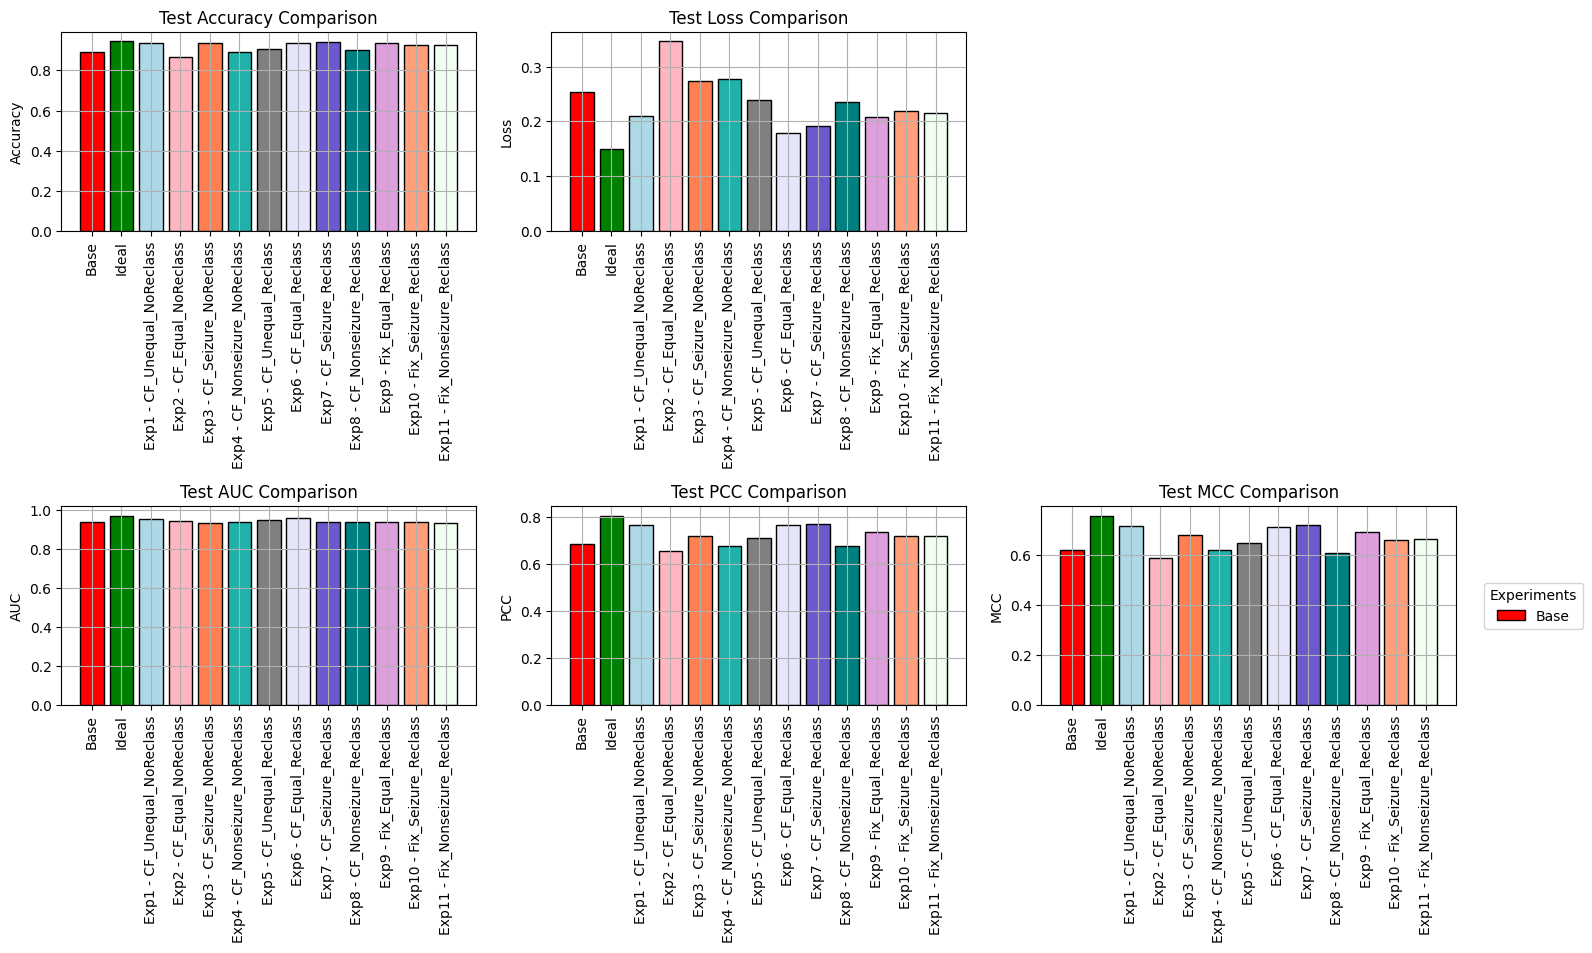

In [ ]:
#store the performance metrics for each model
comparison_metrics = {
    'Model': [],
    'Name': [],
    'Test Accuracy': [],
    'Test Loss': [],
    'Test PCC': [],
    'Test MCC': [],
    'Test AUC': []
}

#evaluate the models
def eval_models(model, name):

    print(f'\nEvaluation of {name}')
    test_loss, test_acc = model.evaluate(test_seg, test_labels)
    #print(f"Test Loss: {test_loss*100:.4f}%")
    #print(f"Test Accuracy: {test_acc*100:.4f}%")

    #predictions and probabilities
    test_probs = model.predict(test_seg).ravel()
    test_preds = (test_probs > 0.5).astype(int)

    #Pearson correlation coefficient
    test_pcc = pearsonr(test_probs, test_labels)[0]
    #print(f"Pearson Correlation Coefficient of {name}: {test_pcc}")

    #Matthews correlation coefficient
    test_mcc = matthews_corrcoef(test_labels, test_preds)
    #print(f"Matthews Correlation Coefficient of {name}: {test_mcc}")

    #AUC-ROC
    test_auc = roc_auc_score(test_labels, test_probs)
    #print(f"AUC-ROC of {name}: {test_auc:.4f}")

    fpr, tpr, _ = roc_curve(test_labels, test_probs)

    #update the comparison table
    comparison_metrics['Model'].append(f'{name}')
    comparison_metrics['Test Accuracy'].append(test_acc)
    comparison_metrics['Test Loss'].append(test_loss)
    comparison_metrics['Test PCC'].append(test_pcc)
    comparison_metrics['Test MCC'].append(test_mcc)
    comparison_metrics['Test AUC'].append(test_auc)

eval_models(base_model, "Base Model")
eval_models(ideal_model, "Ideal Model")

eval_models(aug_model[1], "Exp 1 - Conf Thresh, add both, no reclass")
eval_models(aug_model[2], "Exp 2 - Conf Thresh, add both equally, no reclass")
eval_models(aug_model[3], "Exp 3 - Conf Thresh, add only seizures, no reclass")
eval_models(aug_model[4], "Exp 4 - Conf Thresh, add only non-seizures, no reclass")

eval_models(aug_model[5], "Exp 5 - Conf Thresh, add both, with reclass")
eval_models(aug_model[6], "Exp 6 - Conf Thresh, add both equally, with reclass")
eval_models(aug_model[7], "Exp 7 - Conf Thresh, add only seizures, with reclass")
eval_models(aug_model[8], "Exp 8 - Conf Thresh, add only non-seizures, with reclass")

eval_models(aug_model[9], "Exp 9 - Fixed Percentage, add both equally (2.5% each), with reclass")
eval_models(aug_model[10], "Exp 10 - Fixed Percentage, add only seizures (2.5%), with reclass")
eval_models(aug_model[11], "Exp 11 - Fixed Percentage, add only non-seizures (2.5%), with reclass")

#names for the models/experiments
short_names = ['Base',
               'Ideal',

               'Exp1 - CF_Unequal_NoReclass',
               'Exp2 - CF_Equal_NoReclass',
               'Exp3 - CF_Seizure_NoReclass',
               'Exp4 - CF_Nonseizure_NoReclass',

               'Exp5 - CF_Unequal_Reclass',
               'Exp6 - CF_Equal_Reclass',
               'Exp7 - CF_Seizure_Reclass',
               'Exp8 - CF_Nonseizure_Reclass',

               'Exp9 - Fix_Equal_Reclass',
               'Exp10 - Fix_Seizure_Reclass',
               'Exp11 - Fix_Nonseizure_Reclass']

comparison_metrics['Name'] = short_names

#convert to df and save
comparison_df = pd.DataFrame(comparison_metrics)
print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=False))

comparison_df.to_csv('Exp_Comparison_Results.csv', index=False)

#plot

#colors for each experiment/model
colors = ['red', 'green', 'lightblue', 'lightpink', 'coral', 'lightseagreen', 'gray', 'lavender', 'slateblue', 'teal', 'plum', 'lightsalmon', 'honeydew']

plt.figure(figsize=(16, 12))

#Test Accuracy
plt.subplot(3, 3, 1)
plt.bar(comparison_df['Name'], comparison_df['Test Accuracy'], color=colors, edgecolor='black')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.grid(True)

#Test Loss
plt.subplot(3, 3, 2)
plt.bar(comparison_df['Name'], comparison_df['Test Loss'], color=colors, edgecolor='black')
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.xticks(rotation=90)
plt.grid(True)

#Test AUC
plt.subplot(3, 3, 4)
plt.bar(comparison_df['Name'], comparison_df['Test AUC'], color=colors, edgecolor='black')
plt.title('Test AUC Comparison')
plt.ylabel('AUC')
plt.xticks(rotation=90)
plt.grid(True)

#Test PCC
plt.subplot(3, 3, 5)
plt.bar(comparison_df['Name'], comparison_df['Test PCC'], color=colors, edgecolor='black')
plt.title('Test PCC Comparison')
plt.ylabel('PCC')
plt.xticks(rotation=90)
plt.grid(True)

#Test MCC
plt.subplot(3, 3, 6)
plt.bar(comparison_df['Name'], comparison_df['Test MCC'], color=colors, edgecolor='black')
plt.title('Test MCC Comparison')
plt.ylabel('MCC')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(short_names, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Experiments")

plt.tight_layout()
plt.show()

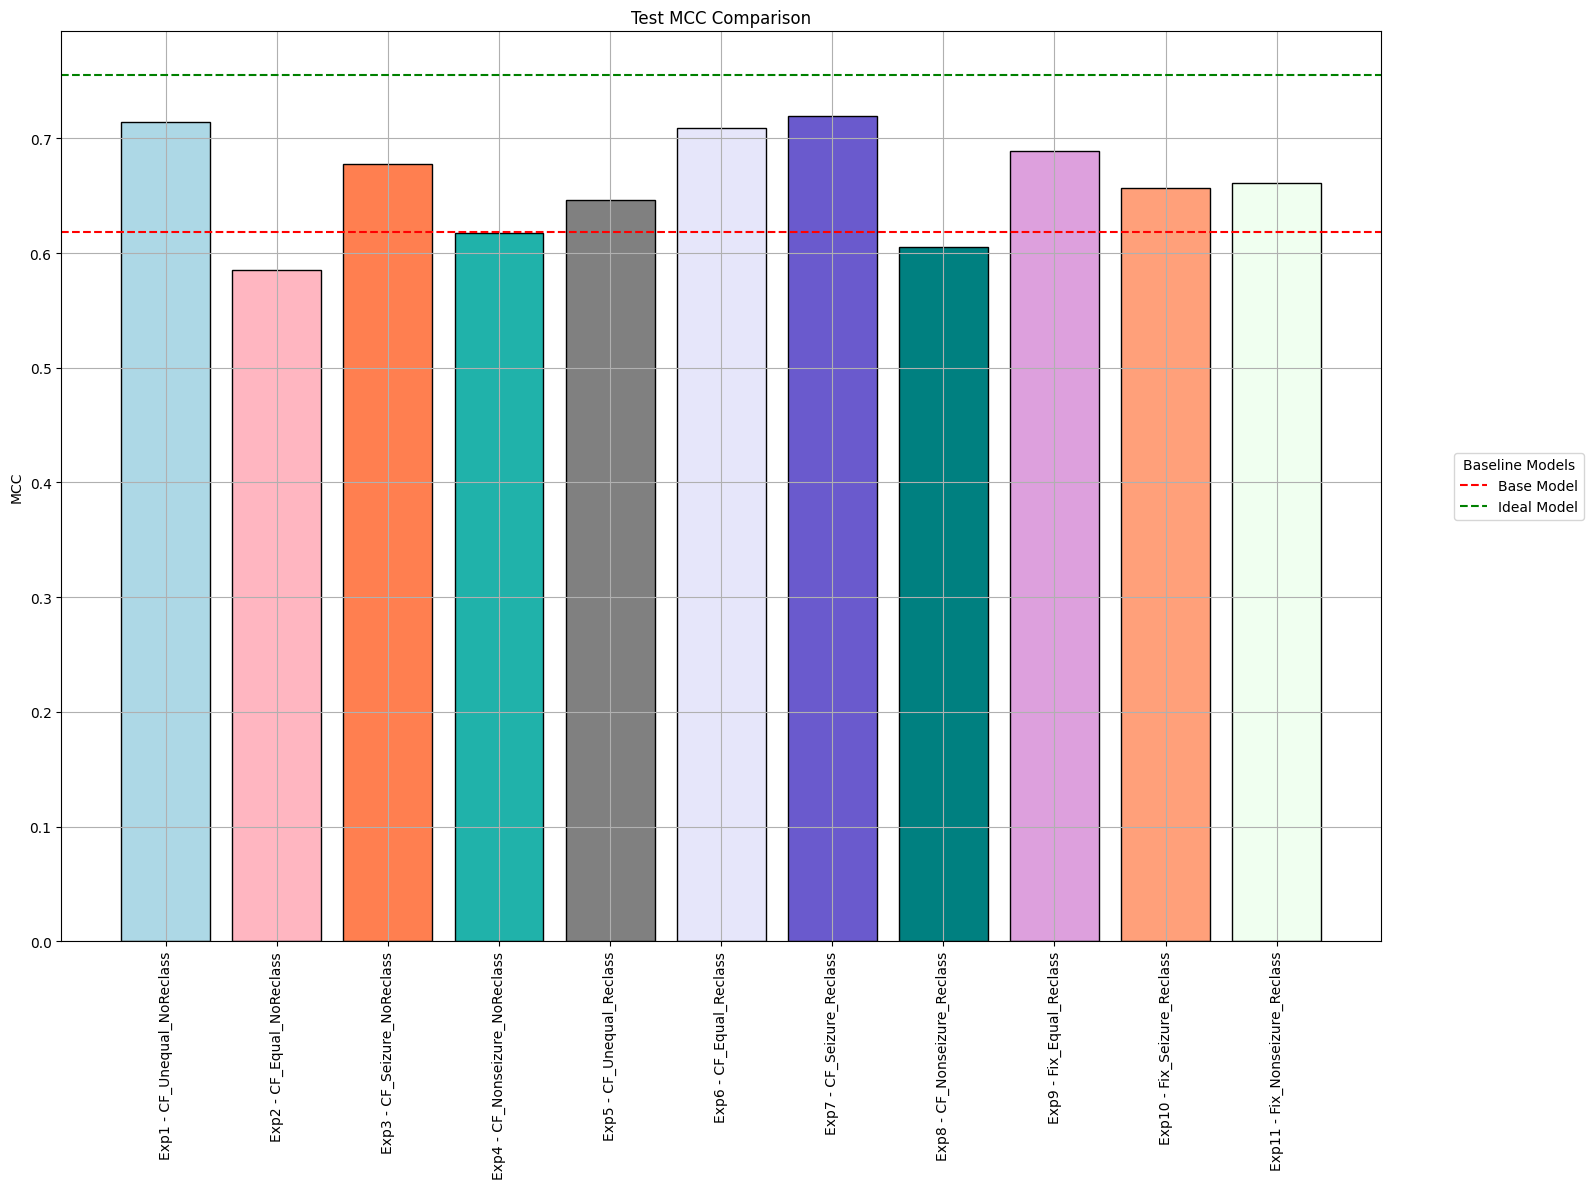

In [ ]:
comparison_df = pd.read_csv('Exp_Comparison_Results.csv')

base_vals = comparison_df[comparison_df['Name'] == 'Base']
ideal_vals = comparison_df[comparison_df['Name'] == 'Ideal']

comparison_df = comparison_df[~comparison_df['Name'].isin(['Base', 'Ideal'])]

#plotting
colors = ['lightblue', 'lightpink', 'coral', 'lightseagreen', 'gray', 'lavender', 'slateblue', 'teal', 'plum', 'lightsalmon', 'honeydew']

plt.figure(figsize=(16, 12))

#test MCC Bar Plot
plt.bar(comparison_df['Name'], comparison_df['Test MCC'], color=colors, edgecolor='black')

#horizontal lines for Base and Ideal model MCC values
plt.axhline(y=base_vals['Test MCC'].values[0], color='red', linestyle='--', label='Base Model')
plt.axhline(y=ideal_vals['Test MCC'].values[0], color='green', linestyle='--', label='Ideal Model')

plt.title('Test MCC Comparison')
plt.ylabel('MCC')
plt.xticks(rotation=90)
plt.grid(True)

#legend for Base and Ideal model
plt.legend(['Base Model', 'Ideal Model'], loc='center left', bbox_to_anchor=(1.05, 0.5), title="Baseline Models")

plt.tight_layout()
plt.show()


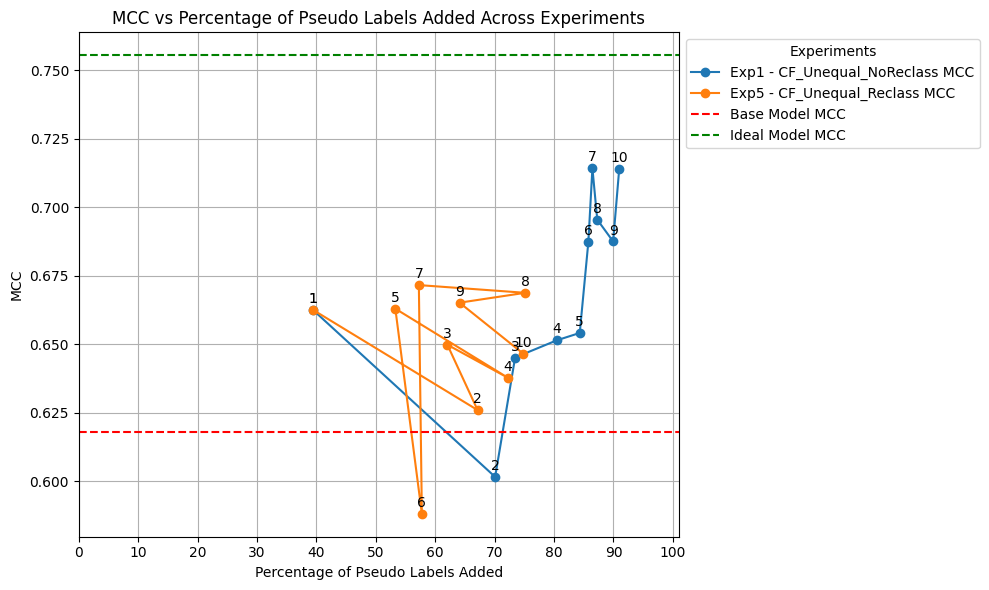

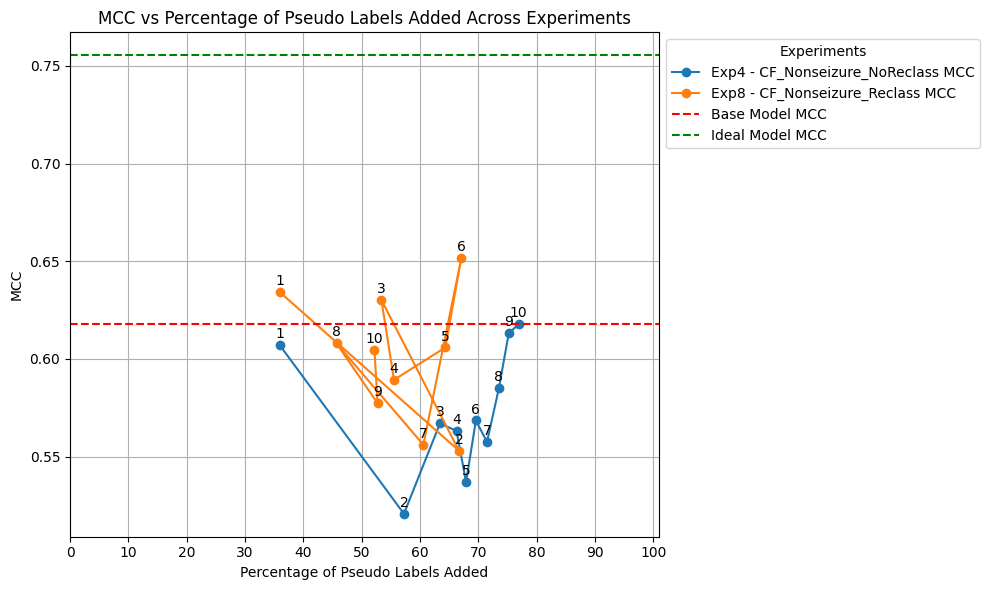

In [ ]:
metrics_exp = {}

#load the performance metrics for each experiment
for i in range(1, 12):
    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'Exp1 - CF_Unequal_NoReclass': metrics_exp[1],
    'Exp2 - CF_Equal_NoReclass': metrics_exp[2],
    'Exp3 - CF_Seizure_NoReclass': metrics_exp[3],
    'Exp4 - CF_Nonseizure_NoReclass': metrics_exp[4],

    'Exp5 - CF_Unequal_Reclass': metrics_exp[5],
    'Exp6 - CF_Equal_Reclass': metrics_exp[6],
    'Exp7 - CF_Seizure_Reclass': metrics_exp[7],
    'Exp8 - CF_Nonseizure_Reclass': metrics_exp[8],

    'Exp9 - Fix_Equal_Reclass': metrics_exp[9],
    'Exp10 - Fix_Seizure_Reclass': metrics_exp[10],
    'Exp11 - Fix_Nonseizure_Reclass': metrics_exp[11]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_auc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test AUC'].values[0]
ideal_auc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test AUC'].values[0]

base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}


#iterate over the experiments
for exp_num, exp_name in enumerate(metrics_history.keys(), start=1):

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #experiments 1 and 4, cumulative number of pseudo-labels added
        if exp_name in ['Exp1 - CF_Unequal_NoReclass', 'Exp4 - CF_Nonseizure_NoReclass']:

            num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])

        #experiments 5 and 8, iterative number of pseudo-labels added
        else:

            num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]

        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#experiment pairs for comparison
exp_pairs = [('Exp1 - CF_Unequal_NoReclass', 'Exp5 - CF_Unequal_Reclass'), ('Exp4 - CF_Nonseizure_NoReclass', 'Exp8 - CF_Nonseizure_Reclass')]

for exp_pair in exp_pairs:
    exp_a, exp_b = exp_pair

    #plot MCC vs number/percentage of pseudo-labels added for each experiment
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(perc_plabels[exp_a], mcc[exp_a], label=f'{exp_a} MCC', marker='o')
    ax1.plot(perc_plabels[exp_b], mcc[exp_b], label=f'{exp_b} MCC', marker='o')

    #base model and ideal model MCC baseline references
    ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
    ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

    #annotate each point with the iteration number for experiment a
    for i, txt in enumerate(metrics_history[exp_a]['Iteration']):
        ax1.annotate(txt, (perc_plabels[exp_a][i], mcc[exp_a][i]), textcoords="offset points", xytext=(0,5), ha='center')

    #annotate each point with the iteration number for experiment b
    for i, txt in enumerate(metrics_history[exp_b]['Iteration']):
        ax1.annotate(txt, (perc_plabels[exp_b][i], mcc[exp_b][i]), textcoords="offset points", xytext=(0,5), ha='center')

    #calculate the min and max values for x-axis
    min_perc_a, max_perc_a = min(perc_plabels[exp_a]), max(perc_plabels[exp_a])
    min_perc_b, max_perc_b = min(perc_plabels[exp_b]), max(perc_plabels[exp_b])

    #x axis limits based on the maximum of both experiments
    #x_min = min(min_perc_a, min_perc_b)
    x_max = max(max_perc_a, max_perc_b)

    #x-axis ticks in increments of 5% within the range
    ax1.set_xticks(np.arange(0, 100+1, 10))
    ax1.set_xlim([0, 100+1])

    ax1.set_xlabel('Percentage of Pseudo Labels Added')
    ax1.set_ylabel('MCC')

    ax1.set_title('MCC vs Percentage of Pseudo Labels Added Across Experiments')
    ax1.grid(True)

    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

    plt.tight_layout()
    plt.show()

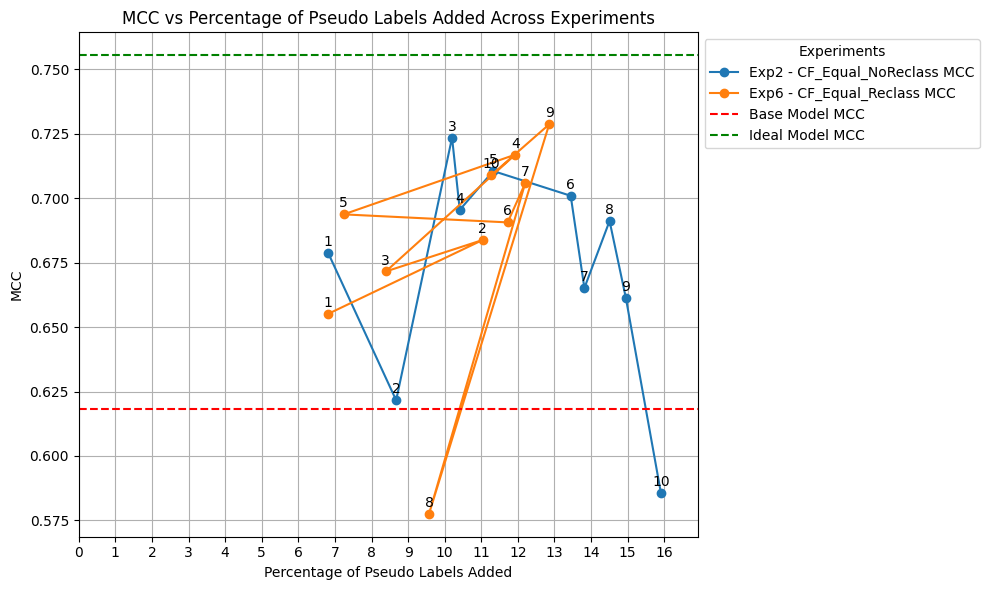

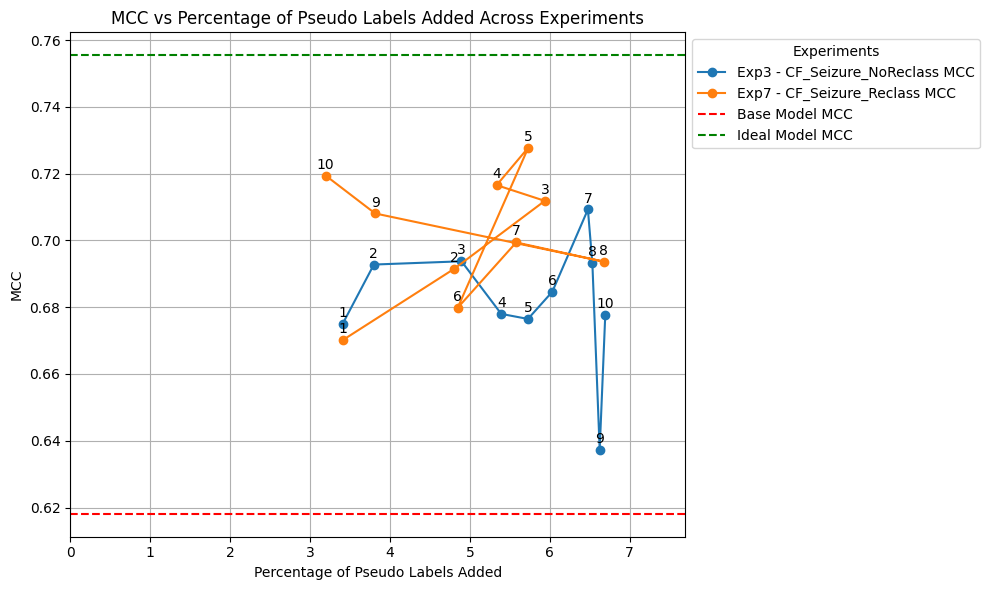

In [ ]:
metrics_exp = {}

#load the performance metrics for each experiment
for i in range(1, 12):
    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'Exp1 - CF_Unequal_NoReclass': metrics_exp[1],
    'Exp2 - CF_Equal_NoReclass': metrics_exp[2],
    'Exp3 - CF_Seizure_NoReclass': metrics_exp[3],
    'Exp4 - CF_Nonseizure_NoReclass': metrics_exp[4],

    'Exp5 - CF_Unequal_Reclass': metrics_exp[5],
    'Exp6 - CF_Equal_Reclass': metrics_exp[6],
    'Exp7 - CF_Seizure_Reclass': metrics_exp[7],
    'Exp8 - CF_Nonseizure_Reclass': metrics_exp[8],

    'Exp9 - Fix_Equal_Reclass': metrics_exp[9],
    'Exp10 - Fix_Seizure_Reclass': metrics_exp[10],
    'Exp11 - Fix_Nonseizure_Reclass': metrics_exp[11]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_auc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test AUC'].values[0]
ideal_auc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test AUC'].values[0]

base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}


#iterate over the experiments
for exp_num, exp_name in enumerate(metrics_history.keys(), start=1):

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #experiments 2 and 3, cumulative number of pseudo-labels added
        if exp_name in ['Exp2 - CF_Equal_NoReclass', 'Exp3 - CF_Seizure_NoReclass']:

            num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])

        #experiments 6 and 7, iterative number of pseudo-labels added
        else:

            num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]

        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#experiment pairs for comparison
exp_pairs = [('Exp2 - CF_Equal_NoReclass', 'Exp6 - CF_Equal_Reclass'), ('Exp3 - CF_Seizure_NoReclass', 'Exp7 - CF_Seizure_Reclass')]

for exp_pair in exp_pairs:
    exp_a, exp_b = exp_pair

    #plot MCC vs number/percentage of pseudo-labels added for each experiment
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(perc_plabels[exp_a], mcc[exp_a], label=f'{exp_a} MCC', marker='o')
    ax1.plot(perc_plabels[exp_b], mcc[exp_b], label=f'{exp_b} MCC', marker='o')

    #base model and ideal model MCC baseline references
    ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
    ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

    #annotate each point with the iteration number for experiment a
    for i, txt in enumerate(metrics_history[exp_a]['Iteration']):
        ax1.annotate(txt, (perc_plabels[exp_a][i], mcc[exp_a][i]), textcoords="offset points", xytext=(0,5), ha='center')

    #annotate each point with the iteration number for experiment b
    for i, txt in enumerate(metrics_history[exp_b]['Iteration']):
        ax1.annotate(txt, (perc_plabels[exp_b][i], mcc[exp_b][i]), textcoords="offset points", xytext=(0,5), ha='center')

    #calculate the min and max values for x-axis
    min_perc_a, max_perc_a = min(perc_plabels[exp_a]), max(perc_plabels[exp_a])
    min_perc_b, max_perc_b = min(perc_plabels[exp_b]), max(perc_plabels[exp_b])

    #x axis limits based on the maximum of both experiments
    #x_min = min(min_perc_a, min_perc_b)
    x_max = max(max_perc_a, max_perc_b)

    #x-axis ticks in increments of 5% within the range
    ax1.set_xticks(np.arange(0, x_max+1, 1))
    ax1.set_xlim([0, x_max+1])

    ax1.set_xlabel('Percentage of Pseudo Labels Added')
    ax1.set_ylabel('MCC')

    ax1.set_title('MCC vs Percentage of Pseudo Labels Added Across Experiments')
    ax1.grid(True)

    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

    plt.tight_layout()
    plt.show()

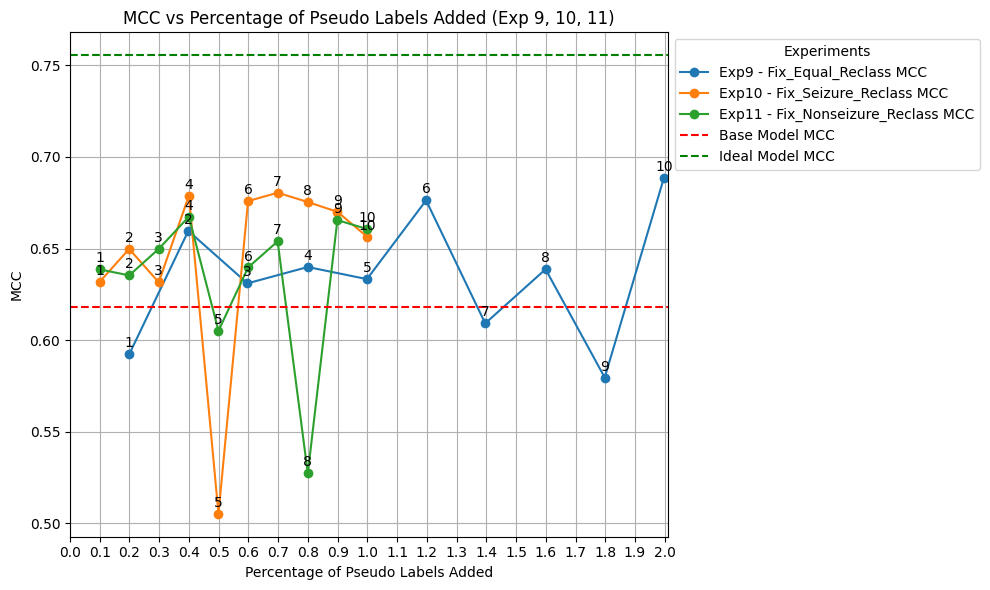

In [ ]:
metrics_exp = {}

for i in range(9, 12):

    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'Exp9 - Fix_Equal_Reclass': metrics_exp[9],
    'Exp10 - Fix_Seizure_Reclass': metrics_exp[10],
    'Exp11 - Fix_Nonseizure_Reclass': metrics_exp[11]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
#total_unlabelled = len(y_train_unlabels)
total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}

for exp_name in metrics_history.keys():

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #number of pseudo-labels added
        #num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])
        num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]
        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#plot MCC vs number/percentage of pseudo-labels added for experiments 9, 10, and 11
exp_names = ['Exp9 - Fix_Equal_Reclass', 'Exp10 - Fix_Seizure_Reclass', 'Exp11 - Fix_Nonseizure_Reclass']

fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in exp_names:

    ax1.plot(perc_plabels[exp_name], mcc[exp_name], label=f'{exp_name} MCC', marker='o')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#annotate each point with the iteration number for each experiment
for exp_name in exp_names:

    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], mcc[exp_name][i]), textcoords="offset points", xytext=(0, 5), ha='center')

#x-axis limits and ticks
min_perc = min(perc_plabels[exp_name])
max_perc = max(perc_plabels[exp_name])

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 1.1, 0.1))
ax1.set_xlim([0, np.ceil(max_perc) + 1.01])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added (Exp 9, 10, 11)')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()


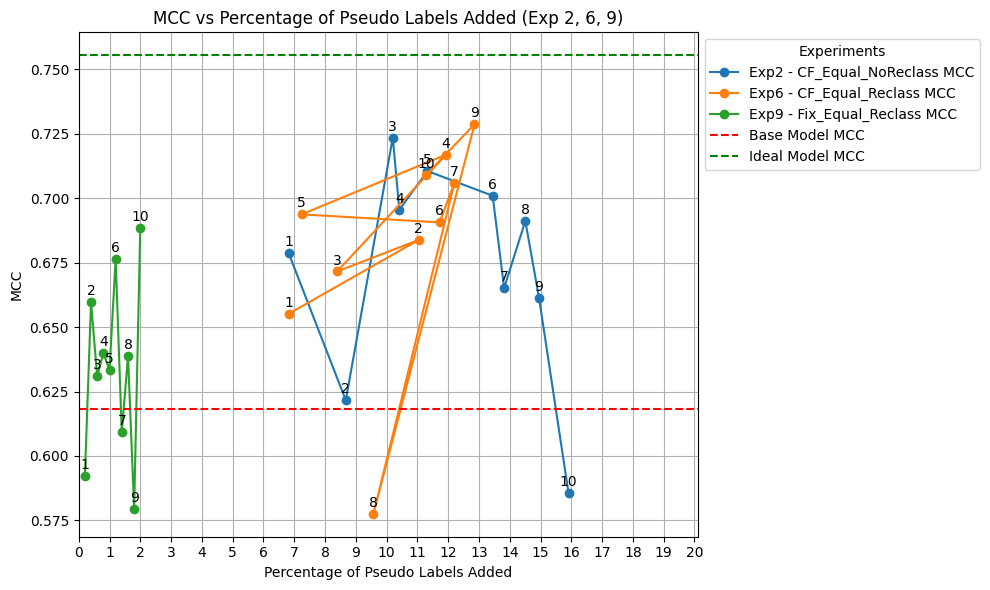

In [ ]:
metrics_exp = {}

for i in [2, 6, 9]:

    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'Exp2 - CF_Equal_NoReclass': metrics_exp[2],
    'Exp6 - CF_Equal_Reclass': metrics_exp[6],
    'Exp9 - Fix_Equal_Reclass': metrics_exp[9]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}

for exp_name in metrics_history.keys():

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #number of pseudo-labels added
        #experiments 2, cumulative number of pseudo-labels added
        if exp_name in ['Exp2 - CF_Equal_NoReclass']:

            num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])

        #experiments 6 and 9, iterative number of pseudo-labels added
        else:

            num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]

        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#plot MCC vs number/percentage of pseudo-labels added
exp_names = ['Exp2 - CF_Equal_NoReclass', 'Exp6 - CF_Equal_Reclass', 'Exp9 - Fix_Equal_Reclass']

fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in exp_names:

    ax1.plot(perc_plabels[exp_name], mcc[exp_name], label=f'{exp_name} MCC', marker='o')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#annotate each point with the iteration number for each experiment
for exp_name in exp_names:

    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], mcc[exp_name][i]), textcoords="offset points", xytext=(0, 5), ha='center')

#x-axis limits and ticks
min_perc = min(perc_plabels[exp_name])
max_perc = max(perc_plabels[exp_name])

ax1.set_xticks(np.arange(0, 20.1, 1))
ax1.set_xlim([0, 20.1])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added (Exp 2, 6, 9)')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()


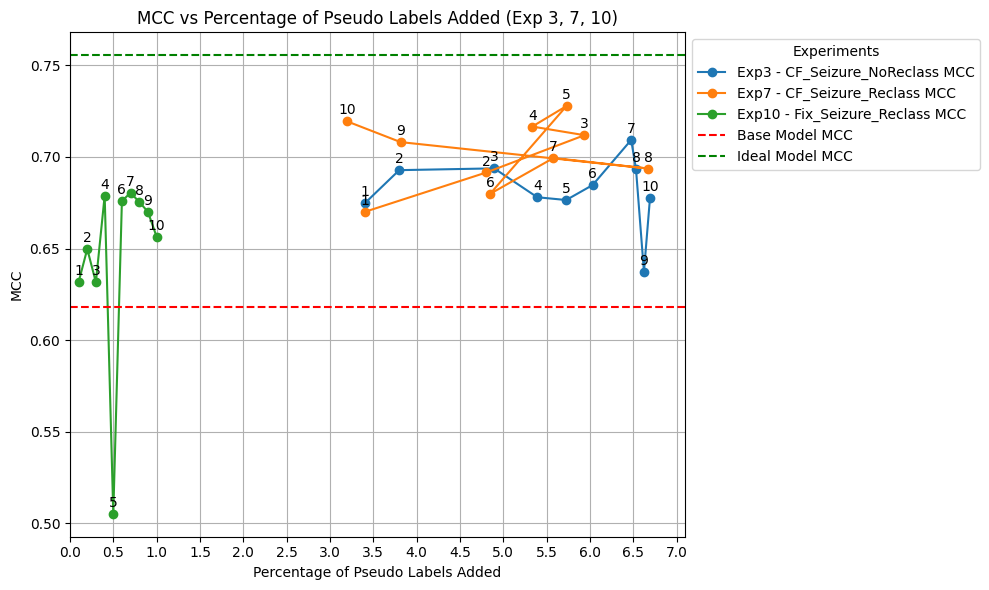

In [ ]:
metrics_exp = {}

for i in [3, 7, 10]:

    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'Exp3 - CF_Seizure_NoReclass': metrics_exp[3],
    'Exp7 - CF_Seizure_Reclass': metrics_exp[7],
    'Exp10 - Fix_Seizure_Reclass': metrics_exp[10]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}

for exp_name in metrics_history.keys():

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #number of pseudo-labels added
        #experiments 3, cumulative number of pseudo-labels added
        if exp_name in ['Exp3 - CF_Seizure_NoReclass']:

            num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])

        #experiments 7 and 10, iterative number of pseudo-labels added
        else:

            num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]

        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#plot MCC vs number/percentage of pseudo-labels added
exp_names = ['Exp3 - CF_Seizure_NoReclass', 'Exp7 - CF_Seizure_Reclass', 'Exp10 - Fix_Seizure_Reclass']

fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in exp_names:

    ax1.plot(perc_plabels[exp_name], mcc[exp_name], label=f'{exp_name} MCC', marker='o')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#annotate each point with the iteration number for each experiment
for exp_name in exp_names:

    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], mcc[exp_name][i]), textcoords="offset points", xytext=(0, 5), ha='center')

#x-axis limits and ticks
min_perc = min(perc_plabels[exp_name])
max_perc = max(perc_plabels[exp_name])

ax1.set_xticks(np.arange(0, 7.1, 0.5))
ax1.set_xlim([0, 7.1])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added (Exp 3, 7, 10)')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()


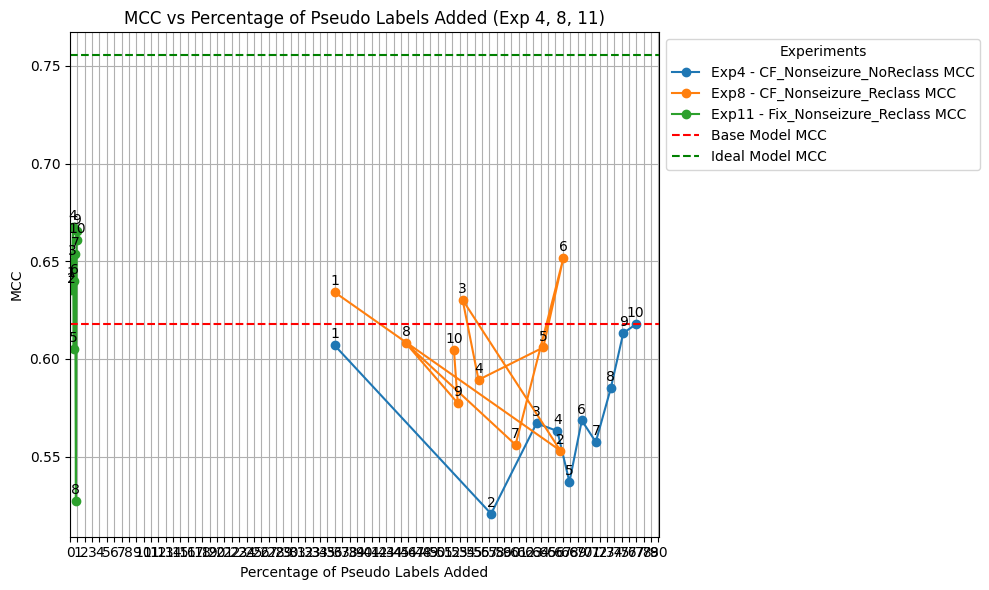

In [ ]:
metrics_exp = {}

for i in [4, 8, 11]:

    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'Exp4 - CF_Nonseizure_NoReclass': metrics_exp[4],
    'Exp8 - CF_Nonseizure_Reclass': metrics_exp[8],
    'Exp11 - Fix_Nonseizure_Reclass': metrics_exp[11]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}

for exp_name in metrics_history.keys():

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #number of pseudo-labels added
        #experiments 4, cumulative number of pseudo-labels added
        if exp_name in ['Exp4 - CF_Nonseizure_NoReclass']:

            num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])

        #experiments 8 and 11, iterative number of pseudo-labels added
        else:

            num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]

        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#plot MCC vs number/percentage of pseudo-labels added
exp_names = ['Exp4 - CF_Nonseizure_NoReclass', 'Exp8 - CF_Nonseizure_Reclass', 'Exp11 - Fix_Nonseizure_Reclass']

fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in exp_names:

    ax1.plot(perc_plabels[exp_name], mcc[exp_name], label=f'{exp_name} MCC', marker='o')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#annotate each point with the iteration number for each experiment
for exp_name in exp_names:

    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], mcc[exp_name][i]), textcoords="offset points", xytext=(0, 5), ha='center')

#x-axis limits and ticks
min_perc = min(perc_plabels[exp_name])
max_perc = max(perc_plabels[exp_name])

ax1.set_xticks(np.arange(0, 80.1, 1))
ax1.set_xlim([0, 80.1])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added (Exp 4, 8, 11)')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()


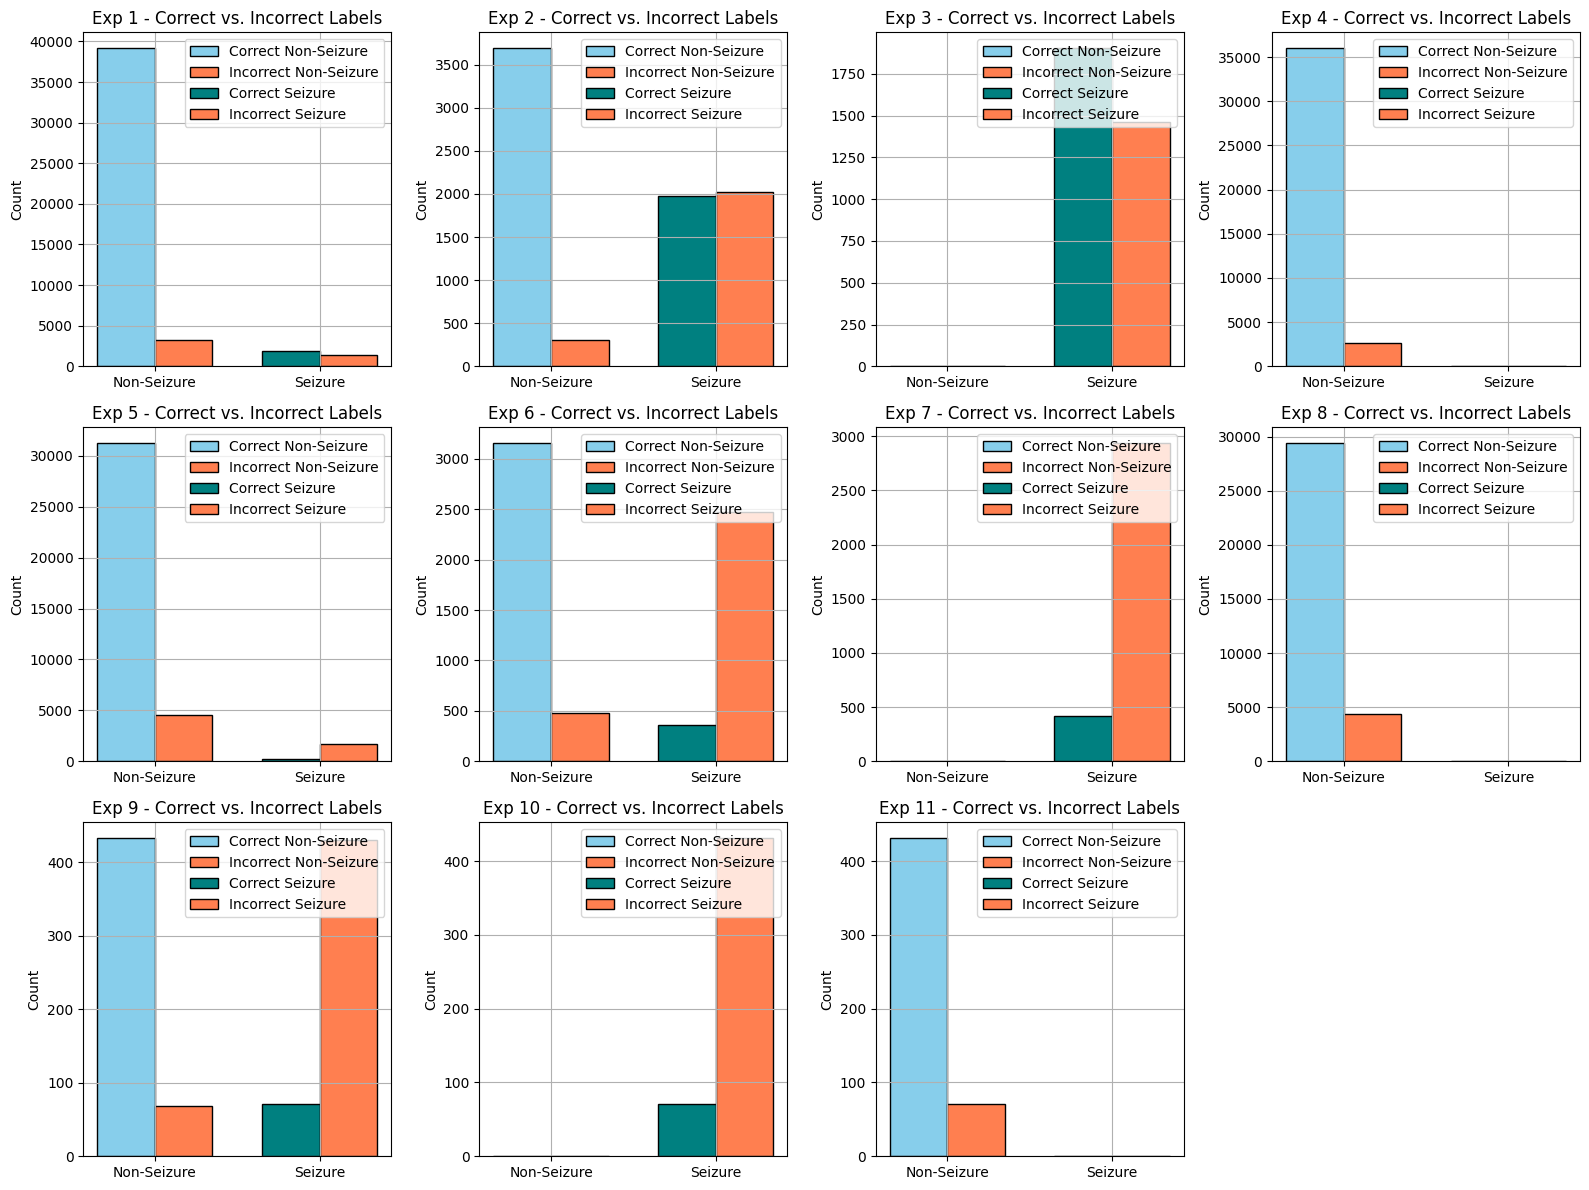

In [ ]:
#function to count correct and incorrect labels
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))

    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))

    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


def get_labels(pseudo_labelled_segments):

    pseudo_indices = np.array(pseudo_labelled_segments['Indices'])

    pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

    actual_labels = y_train_unlabels[pseudo_indices]

    return pseudo_labels, actual_labels

#dictionaries to store results for each experiment
correct_seizure = {}
incorrect_seizure = {}
correct_nonseizure = {}
incorrect_nonseizure = {}

#load the pseudo labelled segments for each experiment

for i in range(1, 12):

    pseudo_labelled_segments_df = pd.read_csv(f'Pseudo_Labels_Exp{i}.csv')

    pseudo_labels, actual_labels = get_labels(pseudo_labelled_segments_df)

    #count the correct and incorrect labels for each experiment
    correct_seizure[i], incorrect_seizure[i], correct_nonseizure[i], incorrect_nonseizure[i] = count_labels(pseudo_labels, actual_labels)

#plotting the results
bw = 0.35
index = np.arange(2)  #for 2 classes

plt.figure(figsize=(16, 12))

for i in range(1, 12):

    #exp i
        plt.subplot(3, 4, i)

        plt.bar(index[0] - bw / 2, correct_nonseizure[i], bw, color='skyblue', edgecolor='black', label='Correct Non-Seizure')
        plt.bar(index[0] + bw / 2, incorrect_nonseizure[i], bw, color='coral', edgecolor='black', label='Incorrect Non-Seizure')
        plt.bar(index[1] - bw / 2, correct_seizure[i], bw, color='teal', edgecolor='black', label='Correct Seizure')
        plt.bar(index[1] + bw / 2, incorrect_seizure[i], bw, color='coral', edgecolor='black', label='Incorrect Seizure')

        plt.xticks(index, ['Non-Seizure', 'Seizure'])
        plt.title(f'Exp {i} - Correct vs. Incorrect Labels')
        plt.ylabel('Count')
        plt.legend(loc='upper right')
        plt.grid(True)

plt.tight_layout()
plt.show()